In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import h5py
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut

from importlib import reload
reload(ut)
import scipy.ndimage.filters as sfi
import scipy.stats as sst
import scipy.ndimage.measurements as snm
from mpl_toolkits.mplot3d import Axes3D
import size_contrast_opto_analysis as scoa
reload(scoa)
import retinotopy_analysis as rt
reload(rt)
import naka_rushton_analysis as nra
import pdb
import size_contrast_analysis as sca
import skimage.segmentation as sks
import skimage.morphology as skm
import sklearn

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
ds = sio.loadmat('/home/mossing/Documents/notebooks/size_contrast/pyr_l23_data_struct.mat',squeeze_me=True) #,struct_as_record=True)

In [3]:
keylist = [x for x in list(ds.keys()) if not x[0]=='_']

In [4]:
for k in range(len(keylist)):
    nangle = 8
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    print(ontarget_ret_lax.sum())

191
350
230
76
346
690
792
654
179
645


/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [5]:
keylist[1]

'session_181213_M8536'

In [6]:
for k in range(len(keylist)):
    print(np.nanmean(ds[keylist[k]]['running_speed_cm_s'][()]))

6.08450931939
50.3874252992
23.5956539465
2.33126464141
49.6074870187
2.00265037742
2.68606714995
35.9569319107
22.1687918868
5.51092901921


In [9]:
matfile = sio.loadmat('/home/mossing/Documents/notebooks/eye_tracking/eye_tracking_181213_M8536.mat',squeeze_me=True)
ctrx_trialwise = matfile['ctrx_trialwise']
ctry_trialwise = matfile['ctry_trialwise']
area_trialwise = matfile['area_trialwise']

In [10]:
def trialavg(arr):
    return np.nanmean(arr[:,8:-8],1)
ctrx = trialavg(ctrx_trialwise)
ctry = trialavg(ctry_trialwise)
area = trialavg(area_trialwise)

In [11]:
eye_dist = np.sqrt((ctrx-np.nanmean(ctrx))**2+(ctry-np.nanmean(ctry))**2)

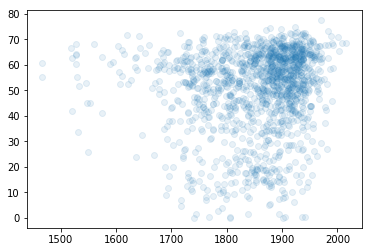

In [88]:
plt.figure()
plt.scatter(area,running_speed_cm_s,alpha=0.1)

In [243]:
nbefore = 8
nafter = 8
eye_mvt = np.nanpercentile(ctrx_trialwise[:,nbefore:-nafter],90,axis=1)-np.nanpercentile(ctrx_trialwise[:,nbefore:-nafter],10,axis=1)

In [848]:
ctrx_trialwise.shape

(1400, 46)

<IPython.core.display.Javascript object>


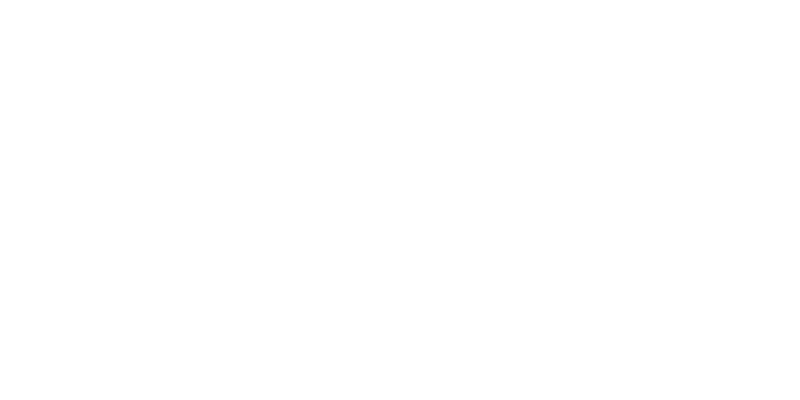

In [847]:
plt.figure(figsize=(8,4))
t = np.arange(ctrx_trialwise.shape[1]/2)/31
plt.subplot(1,2,1)
plt.plot(t,ctrx_trialwise[101:104,::2].T)
plt.fill_between((t[4],t[-4]),(309,309),(316,316),FaceColor='r',alpha=0.1)
plt.xlabel('t (s)')
plt.ylabel('horizontal pupil location (pix)')
plt.subplot(1,2,2)
plt.plot(t,ctry_trialwise[101:104,::2].T)
plt.fill_between((t[4],t[-4]),(62,62),(69,69),FaceColor='r',alpha=0.1)
plt.xlabel('t (s)')
plt.ylabel('vertical pupil location (pix)')
plt.tight_layout()
plt.savefig('eye_tracking_traces.pdf')

<IPython.core.display.Javascript object>


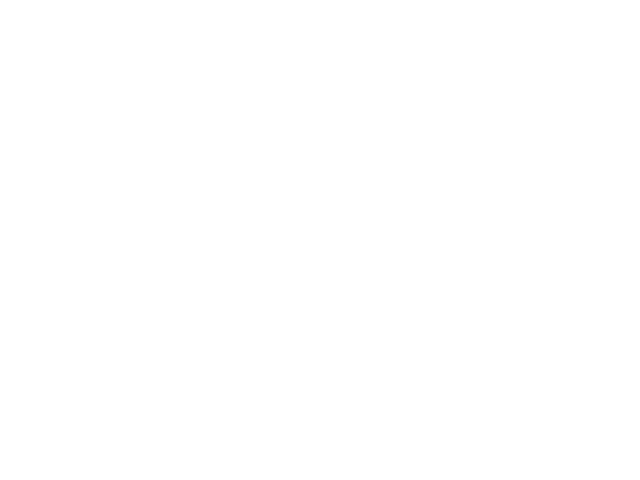

In [826]:
plt.figure()
plt.plot(ctrx_trialwise[eye_mvt>2].T,alpha=0.1,c='g')

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


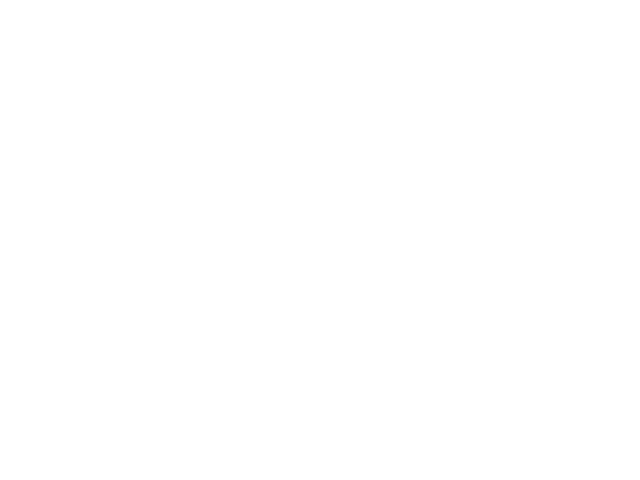

(array([ 25.,  74.,  89.,  71.,  53.,  58.,  31.,  15.,  30.,  24.,  27.,
         23.,  17.,  18.,  15.,  21.,  20.,  24.,  21.,  26.,   9.,  12.,
          9.,   9.,  18.,  13.,  16.,  16.,  17.,  13.,  17.,  19.,  11.,
         23.,  21.,  13.,  20.,  17.,  12.,  16.,  13.,  14.,  14.,  12.,
         10.,   7.,  12.,  18.,  10.,   7.,  22.,   7.,  15.,  13.,  13.,
          9.,  11.,  10.,   6.,  15.,   9.,  11.,   7.,   5.,   5.,   8.,
          3.,   6.,   7.,   3.,   2.,   7.,   2.,   5.,   3.,   2.,   3.,
          4.,   4.,   4.,   4.,   3.,   0.,   6.,   2.,   0.,   2.,   3.,
          3.,   5.,   1.,   0.,   4.,   2.,   1.,   2.,   1.,   0.,   1.,
          2.,   0.,   0.,   0.,   3.,   0.,   3.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [214]:
plt.figure()
plt.hist(eye_mvt[~np.isnan(eye_mvt)],bins=200)

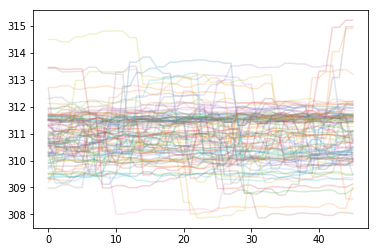

In [17]:
plt.figure()
plt.plot(ctrx_trialwise[:100].T,alpha=0.2)

In [18]:
def k_and(*args):
    if len(args)>2:
        return np.logical_and(args[0],k_and(*args[1:]))
    else:
        return np.logical_and(args[0],args[1])

In [226]:
eye_mvt

array([ 2.98883366,  1.65028713,  0.17455328, ...,  0.65668601,
        0.56492205,  0.48068747])

In [251]:
# Here, we plot the distribution of responses to zero-contrast vs. non-zero contrast stimuli, for all the on-target neurons in a particular mouse
k = 1
nroi = ds[keylist[k]]['decon'][()].shape[0]
nsize = 5
ncontrast = 6
nangle = 8
size = ds[keylist[k]]['stimulus_id'][()][0]
contrast = ds[keylist[k]]['stimulus_id'][()][1]
running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
angle = ds[keylist[k]]['stimulus_id'][()][-1]
pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
response = np.zeros((2,nroi,nsize,ncontrast,nangle))

# criterion = area>np.percentile(area,50)
# criterion = ctrx>np.percentile(ctrx,50)
# criterion = eye_dist>np.percentile(eye_dist,50)
criterion = eye_mvt>np.percentile(eye_mvt[~np.isnan(eye_mvt)],50)

for z in range(2):
    for s in range(nsize):
        for c in range(ncontrast):
            for i in range(nangle):
                stim_of_interest = k_and(angle==i,size==s,contrast==c,running_speed_cm_s>50,criterion==z)
                response[z,:,s,c,i] = np.nanmean(ds[keylist[k]]['decon'][()][:,stim_of_interest],1)

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


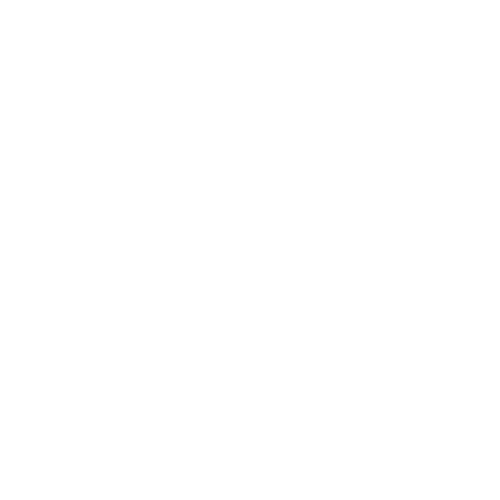

In [228]:
ut.imshow_in_rows(np.nanmean(response[1,:100],-1))

In [193]:
def multi_mean(arr,dims):
    working = arr.copy()
    while len(dims):
        working = np.nanmean(working,dims[0])
        dims = dims[1:]
    return working

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


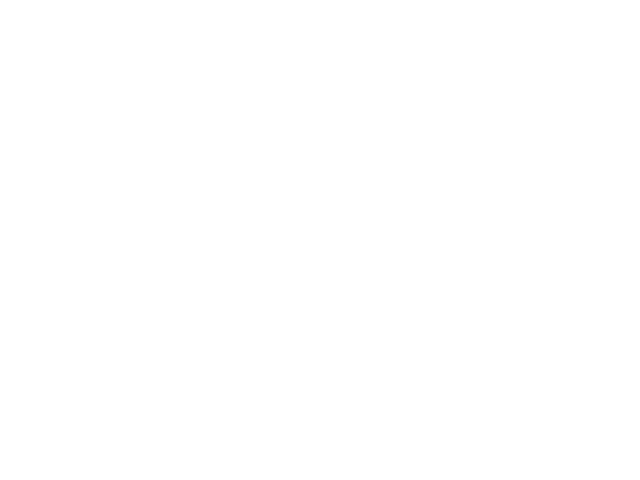

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


 ...]

In [236]:
plt.figure()
r = np.reshape(multi_mean(response,(-1,-1,-1)),(2,-1))
r = r/r.max(0)[np.newaxis]
plt.plot(r,alpha=1e-2)

<IPython.core.display.Javascript object>


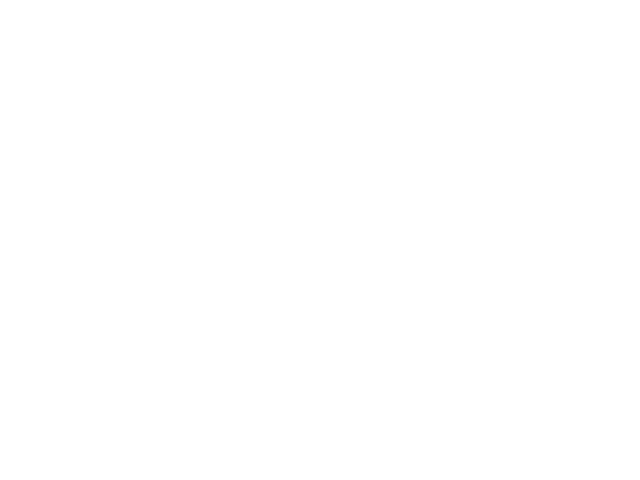

In [280]:
plt.figure()
plt.scatter(running_speed_cm_s,eye_mvt)

In [238]:
plt.close('all')

<IPython.core.display.Javascript object>


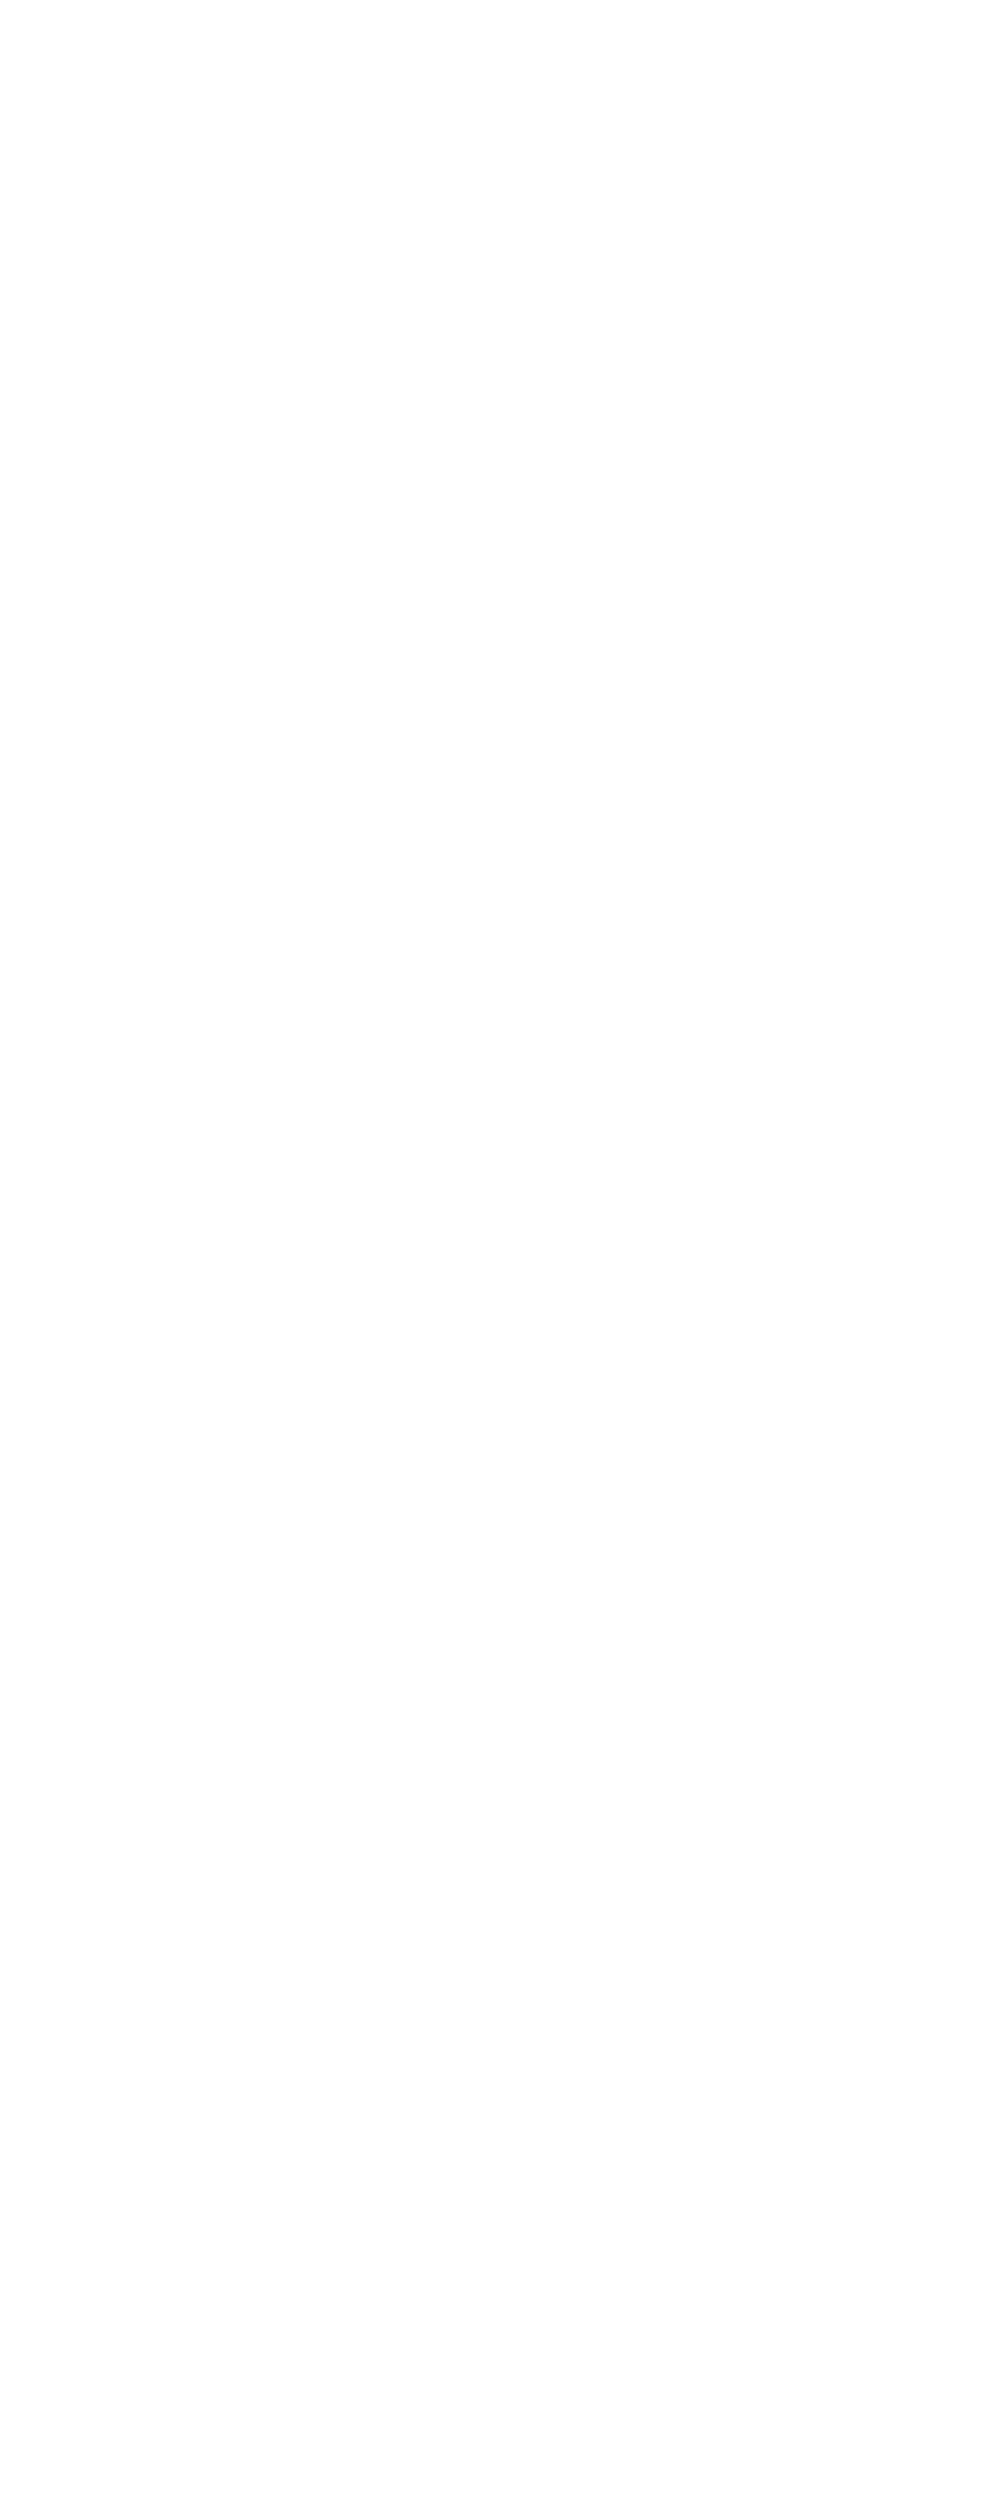

In [239]:
ut.imshow_in_pairs(np.nanmean(response[0,:500],-1),np.nanmean(response[1,:500],-1))

In [218]:
small_tuned = np.argmax(multi_mean(response,(-1,))[0,:,:,-1],axis=1)==0

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


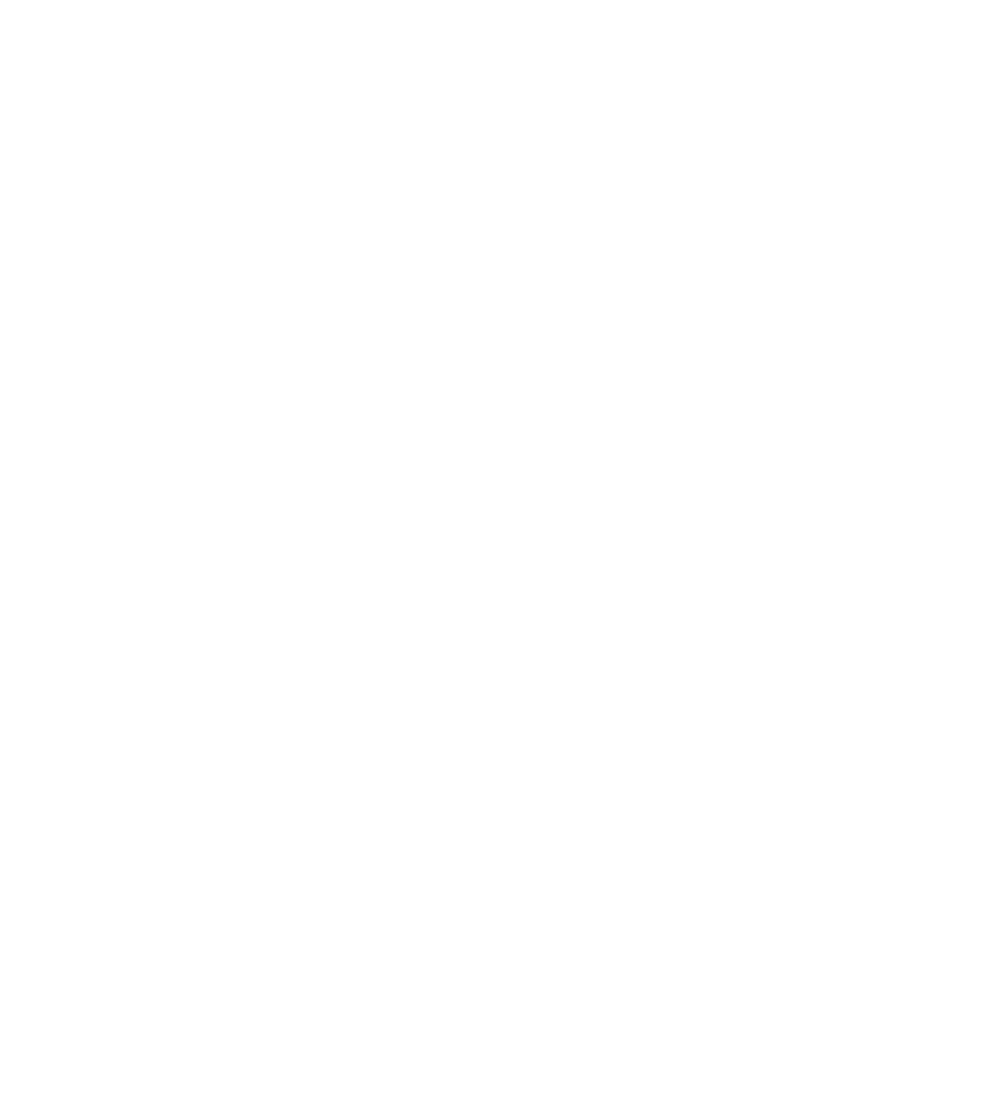

In [219]:
ut.imshow_in_pairs(np.nanmean(response[0,small_tuned],-1),np.nanmean(response[1,small_tuned],-1))

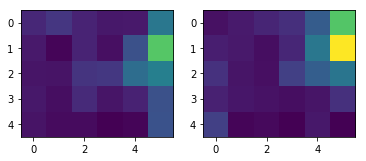

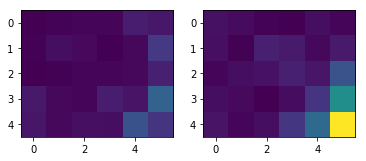

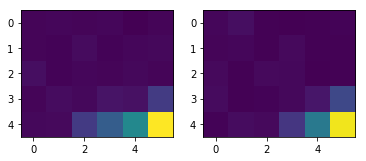

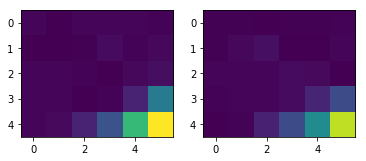

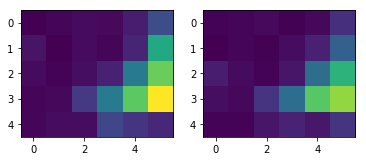

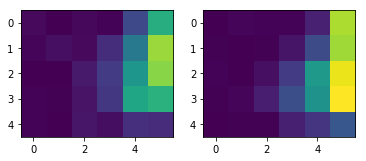

In [89]:
for ind in (8,17,18,19,25,36):
    plt.figure()
    data = np.nanmean(response[:,ind],-1)
    for z in range(2):
        plt.subplot(1,2,z+1)
        plt.imshow(data[z],vmax=data.max())

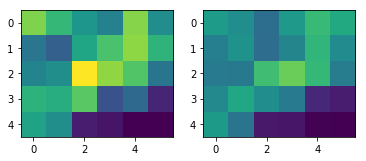

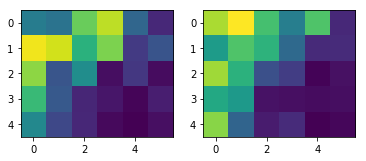

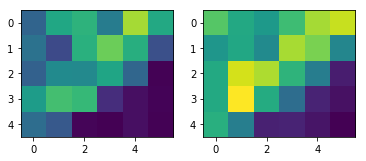

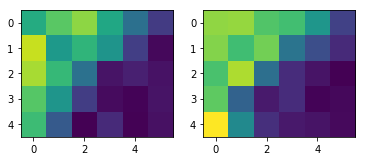

In [70]:
for ind in (16,37,40,49):
    plt.figure()
    data = np.nanmean(response[:,ind],-1)
    for z in range(2):
        plt.subplot(1,2,z+1)
        plt.imshow(data[z],vmax=data.max())

In [7]:
k = 1
data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
data[np.isnan(data)] = 0
u,s,v = np.linalg.svd(data)

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


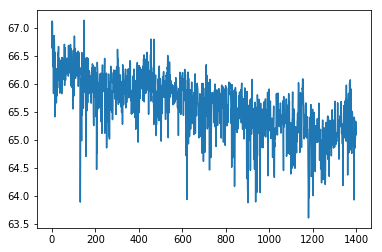

In [102]:
plt.figure()
plt.plot(ctry)

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


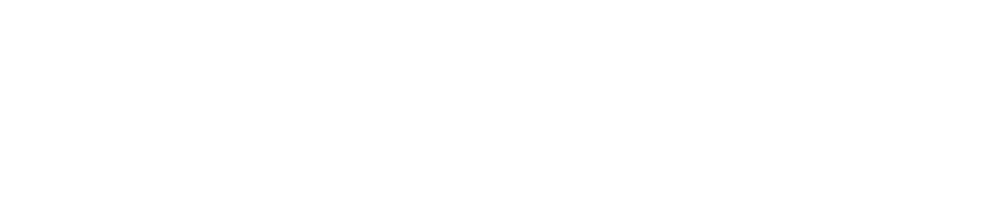

(0, 0, 20, 0.19276442089746837)
(0, 0, 20, 0.2403098688248444)
(0, 0, 20, 0.10538674879268801)
(0, 0, 20, -0.040434426166004157)
(0, 0, 20, -0.018263722106364916)
(0, 0, 20, 0.076239888783304524)
(0, 0, 20, 0.21923639080710708)
(0, 0, 20, 0.40694962229537213)
(0, 1, 20, 0.36527977359793723)
(0, 1, 20, 0.63746195362253133)
(0, 1, 20, 0.085887021106638373)
(0, 1, 20, 0.10227849915733722)
(0, 1, 20, 0.013738925170223163)
(0, 1, 20, -0.23169471552179599)
(0, 1, 20, 0.43861346468647294)
(0, 1, 20, 0.15415670228617209)
(0, 2, 20, 0.11172915184919807)
(0, 2, 20, -0.080966079392048848)
(0, 2, 20, 0.07738333181405628)
(0, 2, 20, 0.22730942711819332)
(0, 2, 20, 0.26218988998954001)
(0, 2, 20, 0.22167818718428667)
(0, 2, 20, 0.32938290135639314)
(0, 2, 20, 0.16949131031351553)
(0, 3, 20, -0.1963806725892667)
(0, 3, 20, 0.086174835203538747)
(0, 3, 20, -0.310810552502643)
(0, 3, 20, -0.97090253738859833)
(0, 3, 20, 0.11092796824758921)
(0, 3, 20, 0.1258412596918401)
(0, 3, 20, -0.04980125025648996

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 0, 20, -0.012517397748822582)
(1, 0, 20, -0.19857110866123459)
(1, 0, 20, 0.27418212096858424)
(1, 0, 20, 0.42238792960400406)
(1, 0, 20, 0.5069306685582915)
(1, 0, 20, -0.023115410965053762)
(1, 0, 20, -0.041089969873828069)
(1, 0, 20, 0.43576707243683055)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 1, 20, 0.12217907539496091)
(1, 1, 20, -0.6062502741561544)
(1, 1, 20, 0.1458290191851277)
(1, 1, 20, 0.27300375425440043)
(1, 1, 20, -0.072330454472554193)
(1, 1, 20, 0.41358988362285104)
(1, 1, 20, 0.11341974868544095)
(1, 1, 20, 0.23891223826382416)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 2, 20, -0.13285261116276506)
(1, 2, 20, 0.47085670661592977)
(1, 2, 20, -0.62830023894616749)
(1, 2, 20, -0.43070474068429165)
(1, 2, 20, 0.4807636656064051)
(1, 2, 20, 0.42778567823096941)
(1, 2, 20, 0.073675608449085009)
(1, 2, 20, 0.29858175876442639)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 3, 20, -1.9195781280063)
(1, 3, 20, 0.15286841329680109)
(1, 3, 20, -0.52076656825673939)
(1, 3, 20, 0.48602197545156622)
(1, 3, 20, 0.060983219005181111)
(1, 3, 20, -0.0049929150272042993)
(1, 3, 20, -0.017288129789468511)
(1, 3, 20, 0.68695284490082587)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 4, 20, -0.39275544758312964)
(1, 4, 20, -0.11298552221698203)
(1, 4, 20, 0.14801590365558229)
(1, 4, 20, -0.25106897585529059)
(1, 4, 20, -0.32007024764157371)
(1, 4, 20, 0.35798372226265068)
(1, 4, 20, 0.097450251124525433)
(1, 4, 20, 0.47854557319294272)


<IPython.core.display.Javascript object>


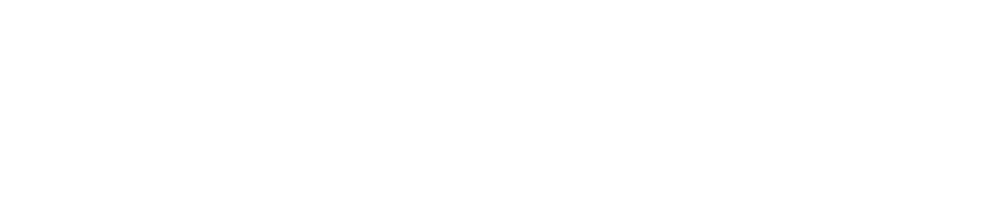

(0, 0, 50, 0.20847549854758338)
(0, 0, 50, 0.15518729962228198)
(0, 0, 50, 0.085179410412511439)
(0, 0, 50, 0.079742758904871439)
(0, 0, 50, 0.27706990155281269)
(0, 0, 50, -0.088053260719823556)
(0, 0, 50, 0.060165401071217782)
(0, 0, 50, 0.46983921656210664)
(0, 1, 50, 0.52520733138495934)
(0, 1, 50, 0.47017986417396412)
(0, 1, 50, 0.064086260502085324)
(0, 1, 50, -0.088180478752225969)
(0, 1, 50, 0.12600945964250462)
(0, 1, 50, -0.31771277340191595)
(0, 1, 50, 0.16504551152527122)
(0, 1, 50, 0.34877073297086442)
(0, 2, 50, -0.099566858454180673)
(0, 2, 50, 0.079832171026591806)
(0, 2, 50, 0.13121000573272254)
(0, 2, 50, -0.14523902055705706)
(0, 2, 50, 0.28828735426033297)
(0, 2, 50, 0.29397207687179339)
(0, 2, 50, -0.033853936286547759)
(0, 2, 50, 0.36268044611207656)
(0, 3, 50, -0.11408606587228631)
(0, 3, 50, 0.14250340545998899)
(0, 3, 50, -0.060352492738262299)
(0, 3, 50, -0.84442115342772028)
(0, 3, 50, -0.64697704645999021)
(0, 3, 50, -0.098073396107447655)
(0, 3, 50, -0.2204

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 0, 50, -0.19673896603412191)
(1, 0, 50, 0.0014626943412183087)
(1, 0, 50, 0.10502923739940047)
(1, 0, 50, 0.49359610360048772)
(1, 0, 50, 0.28834292064784744)
(1, 0, 50, 0.039206700951894304)
(1, 0, 50, -0.037357295400725445)
(1, 0, 50, 0.15185079250856628)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 1, 50, -0.23821505697983439)
(1, 1, 50, -0.21120838618727308)
(1, 1, 50, -0.034684377538511758)
(1, 1, 50, 0.10447589840538592)
(1, 1, 50, -0.066318955918379704)
(1, 1, 50, 0.36306639047982792)
(1, 1, 50, 0.44126375450618477)
(1, 1, 50, -0.074592482927934786)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 2, 50, -0.081099348412802044)
(1, 2, 50, 0.21984044755699664)
(1, 2, 50, -0.60324923030954214)
(1, 2, 50, -0.6527486520173188)
(1, 2, 50, 0.34660056029552927)
(1, 2, 50, 0.10257706105949467)
(1, 2, 50, -0.21544454542100969)
(1, 2, 50, 0.034508328195333192)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 3, 50, -1.22211202470317)
(1, 3, 50, -0.062236280764250508)
(1, 3, 50, -0.67612886403126182)
(1, 3, 50, 0.25842760949452848)
(1, 3, 50, 0.017700905465166377)
(1, 3, 50, -0.39102662042011521)
(1, 3, 50, 0.042690747190464541)
(1, 3, 50, 0.54061645186490404)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 4, 50, -0.44899505868675033)
(1, 4, 50, -0.10985437075283615)
(1, 4, 50, 0.098043141893606411)
(1, 4, 50, -0.25555450610529867)
(1, 4, 50, -0.32597143562014619)
(1, 4, 50, 0.29445471623909364)
(1, 4, 50, -0.32356356747580844)
(1, 4, 50, -0.14689826748145848)


<IPython.core.display.Javascript object>


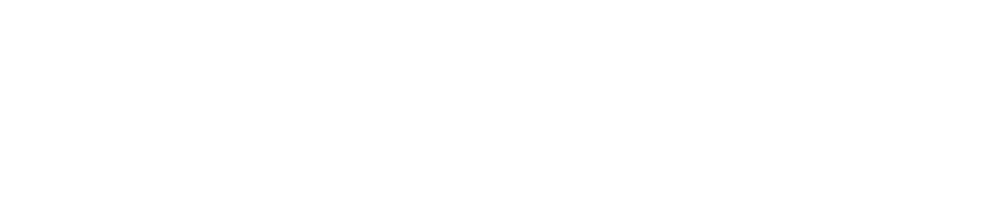

(0, 0, 100, 0.19411868115381278)
(0, 0, 100, 0.06646305082604835)
(0, 0, 100, -0.056721555765141041)
(0, 0, 100, -0.072947072758900819)
(0, 0, 100, 0.31959533647761718)
(0, 0, 100, -0.16476131124636953)
(0, 0, 100, 0.1188596886299574)
(0, 0, 100, 0.25027239857564504)
(0, 1, 100, 0.34480193415372956)
(0, 1, 100, 0.17337837197009665)
(0, 1, 100, 0.21176836409305791)
(0, 1, 100, -0.20274588104292221)
(0, 1, 100, 0.14201066653440717)
(0, 1, 100, -0.47229801956853645)
(0, 1, 100, 0.26845592733478613)
(0, 1, 100, -0.24531230862599651)
(0, 2, 100, -0.57446854266342673)
(0, 2, 100, 0.25817837583254627)
(0, 2, 100, -0.017588200707747987)
(0, 2, 100, -0.34248731244059388)
(0, 2, 100, 0.26747123202290701)
(0, 2, 100, 0.22760596924842072)
(0, 2, 100, -0.10430252128691404)
(0, 2, 100, 0.25153244046555417)
(0, 3, 100, 0.01194489046766245)
(0, 3, 100, 0.068291458853070516)
(0, 3, 100, 0.11476358951115206)
(0, 3, 100, -0.43770233311132006)
(0, 3, 100, -0.80037805621380409)
(0, 3, 100, -0.0687397878671

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 0, 100, -0.26357281483651118)
(1, 0, 100, -0.4286835679294641)
(1, 0, 100, -0.16302815915013188)
(1, 0, 100, -0.46890672335582034)
(1, 0, 100, 0.054380503472264384)
(1, 0, 100, -0.079011654832837896)
(1, 0, 100, -0.031423994154419287)
(1, 0, 100, 0.15156449013459983)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 1, 100, -0.40696068385128076)
(1, 1, 100, -0.085412172789144661)
(1, 1, 100, -0.057360068720025602)
(1, 1, 100, 0.20254998178159997)
(1, 1, 100, 0.048674209069754282)
(1, 1, 100, 0.31431556028179003)
(1, 1, 100, -0.0014764731903518236)
(1, 1, 100, -0.22472012042058029)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 2, 100, -0.12945367116046369)
(1, 2, 100, 0.31988257662917802)
(1, 2, 100, -0.66640308655012948)
(1, 2, 100, -0.6740004979683446)
(1, 2, 100, 0.16673732347795064)
(1, 2, 100, 0.081995854487786721)
(1, 2, 100, -0.25000790505500808)
(1, 2, 100, 0.029686145501682693)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 3, 100, -1.2941685675953842)
(1, 3, 100, -0.25926581847835062)
(1, 3, 100, -0.53378065813485687)
(1, 3, 100, 0.14291798959623575)
(1, 3, 100, -0.25985965529813776)
(1, 3, 100, -0.12977869458235169)
(1, 3, 100, 0.0047686870900721656)
(1, 3, 100, 0.48025195743030497)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 4, 100, -0.47174379694945778)
(1, 4, 100, -0.097809208252194232)
(1, 4, 100, 0.14540715021262984)
(1, 4, 100, -0.26108258321993971)
(1, 4, 100, -0.3218085217135967)
(1, 4, 100, 0.00078642362239215535)
(1, 4, 100, -0.2250862281679141)
(1, 4, 100, -0.21219419808536943)


In [244]:
nkey = len(keylist)
nangle = 8
R = [None]*nkey
proc = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.array((20,50,100))).astype('int')
# cutoffs = (50,)
for k in (1,):
    proc[k] = {}
    R[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    
    u,sigma,v = np.linalg.svd(data)
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>7
    size = ds[keylist[k]]['stimulus_id'][()][0]
    contrast = ds[keylist[k]]['stimulus_id'][()][1]
    angle = ds[keylist[k]]['stimulus_id'][()][-1]
    
    proc[k]['u'] = u
    proc[k]['sigma'] = sigma
    proc[k]['v'] = v  
    proc[k]['pval_ret'] = pval_ret
    proc[k]['dist_ret'] = dist_ret
    proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
    proc[k]['running_speed_cm_s'] = running_speed_cm_s
    proc[k]['running'] = running
    proc[k]['size'] = size
    proc[k]['contrast'] = contrast
    proc[k]['angle'] = angle
    
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        top_score[k] = np.zeros((len(cutoffs),2,5,8))
        for icutoff,cutoff in enumerate(cutoffs):
            R[k][icutoff] = np.zeros((2,5,8,cutoff))
            plt.figure(figsize=(10,2))
            for z in range(2):
                if z==0:
                    val = ctrx.copy()
                else:
                    val = eye_mvt.copy()
                for s in range(5):
                    plt.subplot(1,5,s+1)
                    for i in range(nangle):
                        stim_of_interest_all_contrast = np.logical_and(np.logical_and(angle==i,size==s),running)
                        X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                        uangle = np.unique(angle)
                        y = val[stim_of_interest_all_contrast] #>0

                        na = 50
                        sc = np.zeros((na,))
                        alphas = np.logspace(-2,2,na)
                        for ia,alpha in enumerate(alphas):
                            linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                            reg = linreg.fit(X,y)
                            scores = sklearn.model_selection.cross_validate(linreg,X,y)
                            pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                            sc[ia] = scores['test_score'].mean()
                        best_alpha = np.argmax(sc)
                        top_score[k][icutoff,z,s,i] = sc.max()
                        print((z,s,cutoff,top_score[k][icutoff,z,s,i]))
                        linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                        reg = linreg.fit(X,y)

                        R[k][icutoff][z,s,i] = reg.coef_

                        Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                        ypred = reg.predict(Xall)

                        yactual = val[stim_of_interest_all_contrast]

                        plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


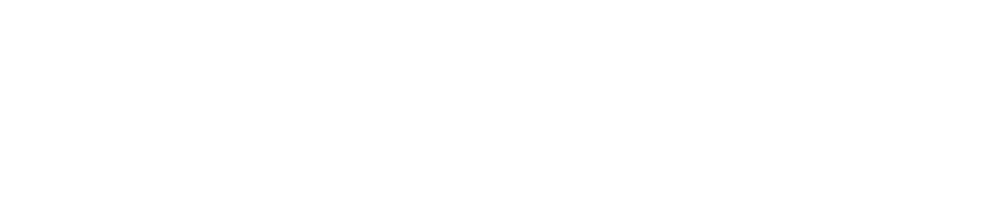

(0, 0, 0, 20, 0.045619222705947315)
(0, 0, 1, 20, -0.60291583796780801)
(0, 0, 2, 20, 0.079418577331529794)
(0, 0, 3, 20, -0.39897661212388513)
(0, 0, 4, 20, 0.10138775711130332)
(0, 0, 5, 20, -0.46618184198671592)
(0, 0, 6, 20, 0.0435891953260387)
(0, 1, 0, 20, 0.030232406908247095)
(0, 1, 1, 20, -0.31538388508503767)
(0, 1, 2, 20, 0.3098683803110262)
(0, 1, 3, 20, -0.0046571038732529475)
(0, 1, 4, 20, -0.027611024624799956)
(0, 1, 5, 20, 0.36061138505200918)
(0, 1, 6, 20, 0.29399410334255544)
(0, 2, 0, 20, -0.078969372783493849)
(0, 2, 1, 20, -0.073655869501208462)
(0, 2, 2, 20, 0.087292013027742102)
(0, 2, 3, 20, -0.24404467453794523)
(0, 2, 4, 20, -0.026457046733361651)
(0, 2, 5, 20, 0.018893535186269312)
(0, 2, 6, 20, 0.33203310492625526)
(0, 3, 0, 20, 0.36289790897063928)
(0, 3, 1, 20, -0.70047654212245625)
(0, 3, 2, 20, -0.18662056474802946)
(0, 3, 3, 20, 0.18231751863714066)
(0, 3, 4, 20, -0.33655433928149558)
(0, 3, 5, 20, 0.47711985254286554)
(0, 3, 6, 20, 0.31835923319566528

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 0, 0, 20, 0.05853027084151622)
(1, 0, 1, 20, 0.27740115383008374)
(1, 0, 2, 20, -0.21526366982630815)
(1, 0, 3, 20, -0.15254153235268617)
(1, 0, 4, 20, 0.20320285850289108)
(1, 0, 5, 20, 0.21120713888089884)
(1, 0, 6, 20, -2.8393470149649267)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 1, 0, 20, 0.32278718213037566)
(1, 1, 1, 20, -0.059734395238882319)
(1, 1, 2, 20, 0.379596467077852)
(1, 1, 3, 20, -0.15857005570389268)
(1, 1, 4, 20, -0.76154224748072574)
(1, 1, 5, 20, -0.16562819902854567)
(1, 1, 6, 20, -0.35454474927349106)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 2, 0, 20, 0.17714704132315706)
(1, 2, 1, 20, -0.4833199276192523)
(1, 2, 2, 20, -0.4129634141339999)
(1, 2, 3, 20, -0.16646438478377945)
(1, 2, 4, 20, 0.22170251365859839)
(1, 2, 5, 20, 0.014273794555593669)
(1, 2, 6, 20, -6.3606590891705617)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 3, 0, 20, 0.38715775699252725)
(1, 3, 1, 20, -1.1222395882638414)
(1, 3, 2, 20, -0.36792265925281403)
(1, 3, 3, 20, 0.053081370859487387)
(1, 3, 4, 20, -0.79331947719198725)
(1, 3, 5, 20, -1.3229717233602585)
(1, 3, 6, 20, -0.035665655334434852)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 4, 0, 20, 0.20305839527471825)
(1, 4, 1, 20, -1.3963865431782754)
(1, 4, 2, 20, -0.59753999847804717)
(1, 4, 3, 20, -1.6625629410941796)
(1, 4, 4, 20, -1.6594522914632848)
(1, 4, 5, 20, -0.57563638964102948)
(1, 4, 6, 20, -0.22657887748019176)


<IPython.core.display.Javascript object>


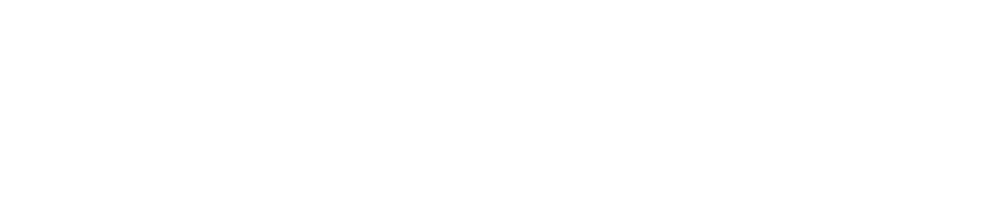

(0, 0, 0, 50, 0.47158462659339434)
(0, 0, 1, 50, -0.1858829520871311)
(0, 0, 2, 50, 0.17733491163590995)
(0, 0, 3, 50, -0.60141809671446578)
(0, 0, 4, 50, 0.3186562428096919)
(0, 0, 5, 50, -0.31590983798738059)
(0, 0, 6, 50, -0.074418895425098233)
(0, 1, 0, 50, 0.10906025316276484)
(0, 1, 1, 50, -0.10184725989810821)
(0, 1, 2, 50, 0.23678770619504116)
(0, 1, 3, 50, -0.70803432903904151)
(0, 1, 4, 50, 0.13561284105140925)
(0, 1, 5, 50, -0.0020966163555452186)
(0, 1, 6, 50, 0.19755787063405716)
(0, 2, 0, 50, 0.00025542216767652598)
(0, 2, 1, 50, 0.30779581353800417)
(0, 2, 2, 50, -0.14354568261920644)
(0, 2, 3, 50, -0.30456691937012292)
(0, 2, 4, 50, 0.21180952475642581)
(0, 2, 5, 50, -0.17232535875251198)
(0, 2, 6, 50, 0.25612857183750914)
(0, 3, 0, 50, 0.26782150345892447)
(0, 3, 1, 50, -0.27681014142388732)
(0, 3, 2, 50, -0.39576836668835097)
(0, 3, 3, 50, -0.12441968903506628)
(0, 3, 4, 50, -0.16228111030202463)
(0, 3, 5, 50, 0.025043337796974891)
(0, 3, 6, 50, 0.40307619824247531)
(

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 0, 0, 50, -0.1465313229497717)
(1, 0, 1, 50, 0.081425367494264392)
(1, 0, 2, 50, -0.21180240707809725)
(1, 0, 3, 50, -0.43432208364108787)
(1, 0, 4, 50, -0.12107248375746966)
(1, 0, 5, 50, 0.16413194751289495)
(1, 0, 6, 50, -2.3146536969231306)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 1, 0, 50, 0.21529731996116508)
(1, 1, 1, 50, 0.2787575234995297)
(1, 1, 2, 50, 0.3126754106319648)
(1, 1, 3, 50, -0.22851250853993596)
(1, 1, 4, 50, -0.75842919803950892)
(1, 1, 5, 50, -0.078329392247695043)
(1, 1, 6, 50, -0.32319854828261385)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 2, 0, 50, 0.018577185005921353)
(1, 2, 1, 50, -0.46209170312895548)
(1, 2, 2, 50, -0.42174629228884747)
(1, 2, 3, 50, -0.18165074595556438)
(1, 2, 4, 50, 0.14661791229404295)
(1, 2, 5, 50, -0.15247622066380825)
(1, 2, 6, 50, -6.693929010185415)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 3, 0, 50, 0.43493729986056368)
(1, 3, 1, 50, -0.56006782970503599)
(1, 3, 2, 50, -1.6612214517795489)
(1, 3, 3, 50, 0.095224837897452883)
(1, 3, 4, 50, -0.5233392741502999)
(1, 3, 5, 50, -3.2761792008955717)
(1, 3, 6, 50, -0.037393385609979291)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 4, 0, 50, 0.074426217386695567)
(1, 4, 1, 50, -1.4203051414152918)
(1, 4, 2, 50, -0.80714818057260806)
(1, 4, 3, 50, -1.6956431490929569)
(1, 4, 4, 50, -1.6077314492124308)
(1, 4, 5, 50, -0.63495769292267012)
(1, 4, 6, 50, 0.10512744652154067)


<IPython.core.display.Javascript object>


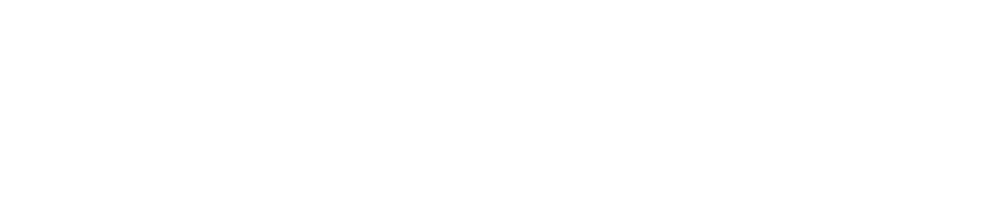

(0, 0, 0, 100, -0.020668575914978542)
(0, 0, 1, 100, -0.58595133964801882)
(0, 0, 2, 100, 0.12608725553116809)
(0, 0, 3, 100, -0.39345425783905147)
(0, 0, 4, 100, 0.12605928257177892)
(0, 0, 5, 100, -0.25808178139635302)
(0, 0, 6, 100, -0.1217551524357013)
(0, 1, 0, 100, -0.048979336492389836)
(0, 1, 1, 100, -0.10491935447385999)
(0, 1, 2, 100, 0.14179441456235853)
(0, 1, 3, 100, -0.36916104038273723)
(0, 1, 4, 100, -0.024165935672369316)
(0, 1, 5, 100, -0.22670130167144839)
(0, 1, 6, 100, 0.16039730996999854)
(0, 2, 0, 100, -0.18091978246124907)
(0, 2, 1, 100, -0.068207114956077897)
(0, 2, 2, 100, -0.32593265559764389)
(0, 2, 3, 100, -0.28715292539574827)
(0, 2, 4, 100, 0.22288934271458324)
(0, 2, 5, 100, -0.15066368994310531)
(0, 2, 6, 100, 0.10763370548204698)
(0, 3, 0, 100, 0.11212648105212104)
(0, 3, 1, 100, -0.34562877352511451)
(0, 3, 2, 100, -0.4270605240951047)
(0, 3, 3, 100, -0.71446619506746767)
(0, 3, 4, 100, -0.22388081850589472)
(0, 3, 5, 100, -0.081462508842285938)
(0, 3

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 0, 0, 100, -0.11267588638162573)
(1, 0, 1, 100, 0.0099930983934106345)
(1, 0, 2, 100, -0.084823443260321471)
(1, 0, 3, 100, -0.47425053617368312)
(1, 0, 4, 100, -0.17292954700128291)
(1, 0, 5, 100, 0.04314454754002417)
(1, 0, 6, 100, -2.4351731137925365)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 1, 0, 100, 0.04401806747102488)
(1, 1, 1, 100, 0.040251444637177725)
(1, 1, 2, 100, 0.00083450518267082685)
(1, 1, 3, 100, -0.19373210677361286)
(1, 1, 4, 100, -0.75111063455896276)
(1, 1, 5, 100, -0.12734721567009824)
(1, 1, 6, 100, -0.287818117693806)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 2, 0, 100, -0.02451073746054418)
(1, 2, 1, 100, -0.5364042438437896)
(1, 2, 2, 100, -0.42490459374059936)
(1, 2, 3, 100, -0.20653455711256222)
(1, 2, 4, 100, 0.19056463699603565)
(1, 2, 5, 100, -0.18088196670519474)
(1, 2, 6, 100, -4.1010970215047848)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 3, 0, 100, 0.41948948036386119)
(1, 3, 1, 100, -0.22558014934239609)
(1, 3, 2, 100, -2.313402451778888)
(1, 3, 3, 100, 0.047648922712618981)
(1, 3, 4, 100, -0.49233119577835599)
(1, 3, 5, 100, -3.9365762005543758)
(1, 3, 6, 100, 0.15647254500600552)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1, 4, 0, 100, 0.03227891445824816)
(1, 4, 1, 100, -1.3920700974152966)
(1, 4, 2, 100, -0.82956115187549184)
(1, 4, 3, 100, -1.7297843652564495)
(1, 4, 4, 100, -1.5376925567141395)
(1, 4, 5, 100, -0.40040831365039947)
(1, 4, 6, 100, 0.10308529543803846)


In [295]:
nkey = len(keylist)
nangle = 8
R = [None]*nkey
proc = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.array((20,50,100))).astype('int')
# cutoffs = (50,)
for k in (1,):
    proc[k] = {}
    R[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    
    u,sigma,v = np.linalg.svd(data)
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>30
    size = ds[keylist[k]]['stimulus_id'][()][0]
    contrast = ds[keylist[k]]['stimulus_id'][()][1]
    angle = ds[keylist[k]]['stimulus_id'][()][-1]
    
    nangle = len(np.unique(angle))
    ncontrast = len(np.unique(contrast))
    nsize = len(np.unique(size))
    
    proc[k]['u'] = u
    proc[k]['sigma'] = sigma
    proc[k]['v'] = v  
    proc[k]['pval_ret'] = pval_ret
    proc[k]['dist_ret'] = dist_ret
    proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
    proc[k]['running_speed_cm_s'] = running_speed_cm_s
    proc[k]['running'] = running
    proc[k]['size'] = size
    proc[k]['contrast'] = contrast
    proc[k]['angle'] = angle
    
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        top_score[k] = np.zeros((len(cutoffs),2,nsize,ncontrast))
        for icutoff,cutoff in enumerate(cutoffs):
            R[k][icutoff] = np.zeros((2,nsize,ncontrast,cutoff))
            plt.figure(figsize=(10,2))
            for z in range(2):
                if z==0:
                    val = ctrx.copy()
                else:
                    val = eye_mvt.copy()
                for s in range(nsize):
                    plt.subplot(1,nsize,s+1)
                    for i in range(ncontrast):
                        stim_of_interest_all_contrast = np.logical_and(np.logical_and(contrast==i,size==s),running)
                        X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                        uangle = np.unique(angle)
                        y = val[stim_of_interest_all_contrast] #>0

                        na = 50
                        sc = np.zeros((na,))
                        alphas = np.logspace(-2,2,na)
                        for ia,alpha in enumerate(alphas):
                            linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                            reg = linreg.fit(X,y)
                            scores = sklearn.model_selection.cross_validate(linreg,X,y)
                            pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                            sc[ia] = scores['test_score'].mean()
                        best_alpha = np.argmax(sc)
                        top_score[k][icutoff,z,s,i] = sc.max()
                        print((z,s,i,cutoff,top_score[k][icutoff,z,s,i]))
                        linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                        reg = linreg.fit(X,y)

                        R[k][icutoff][z,s,i] = reg.coef_

                        Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                        ypred = reg.predict(Xall)

                        yactual = val[stim_of_interest_all_contrast]

                        plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

In [299]:
top_score[k].shape

(3, 2, 5, 7)

<IPython.core.display.Javascript object>


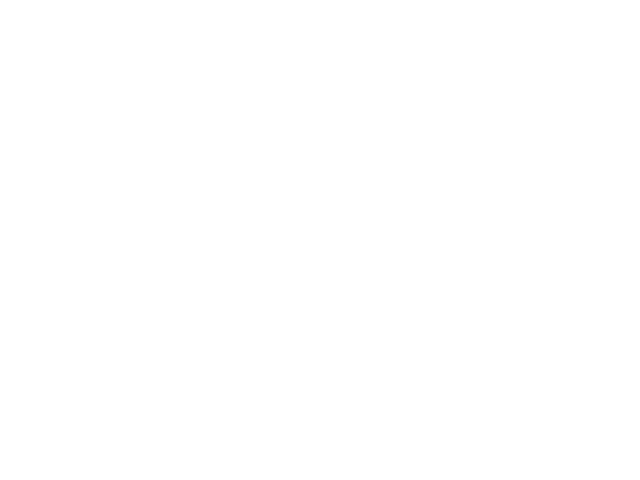

In [304]:
plt.figure()
plt.imshow(top_score[k][:,0,:,:].mean(0))
plt.colorbar()

<IPython.core.display.Javascript object>


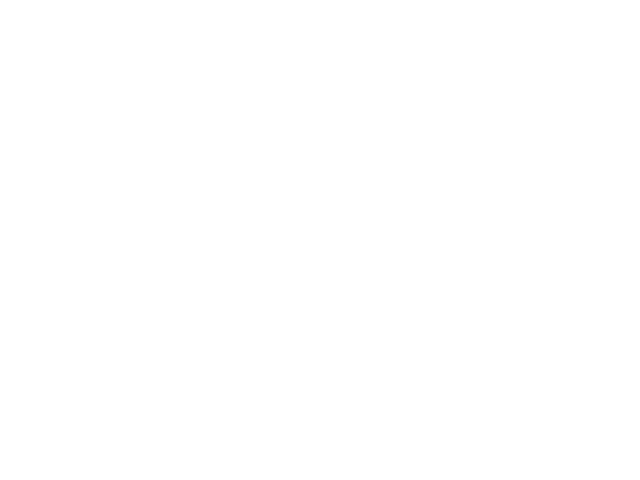

In [385]:
plt.figure()
plt.plot(area)

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


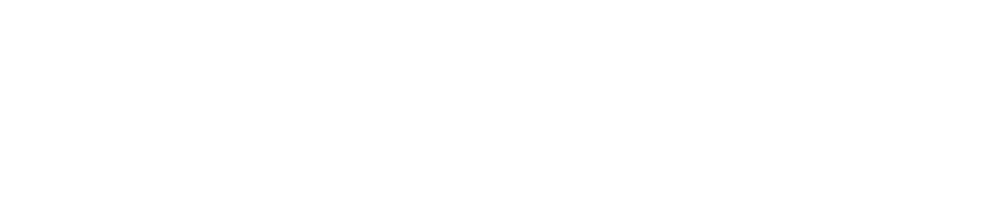

0.471486636346
(50, 0, 0, array([ 0.08304767, -0.06365849,  0.24339612, -0.00446334, -0.01699594,
       -0.02865643,  0.32360399,  0.18744557,  0.17345848,  0.30583057]))
12067.9264064
(50, 1, 0, array([  3.90660784e-07,  -2.88457418e-02,  -2.27096141e-03,
        -9.13869291e-03,  -3.37889979e-02,  -5.90191561e-02,
        -2.27893285e-02,  -4.38721738e-02,  -7.05777290e-02,
        -7.24766489e-02]))
0.0868511373751
(50, 2, 0, array([ 0.4263193 ,  0.30158847,  0.68444215,  0.79763969,  0.6106131 ,
        0.42318739,  0.78709388,  0.74610893,  0.71731342,  0.83925888]))
1.4563484775
(50, 0, 1, array([-0.06599155, -0.02034705,  0.02658943,  0.23997637, -0.01458098,
        0.17597204,  0.15254538,  0.42924347,  0.34849621,  0.07956456]))
6866.48845004
(50, 1, 1, array([-0.01855481, -0.07266765, -0.10315195, -0.00049254, -0.01760498,
       -0.01270633, -0.00438485, -0.00204942,  0.00025948, -0.00666002]))
0.152641796718
(50, 2, 1, array([ 0.42434556,  0.78510529,  0.74040941,  0.5411

In [717]:
        nkey = len(keylist)
        nangle = 8
        R = [None]*nkey
        proc = [None]*nkey
        top_score = [None]*nkey
        cutoffs = (50,) #np.round(np.array((20,50,100,200,500))).astype('int')
        # cutoffs = (50,)
        nz = 3
        rolls = (-2,-1,0,1,2)
        nr = len(rolls)
        cv = 10 # number of splits for cross validation
        for k in (1,):
            proc[k] = {}
            R[k] = [None]*len(cutoffs)
            data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
            data[np.isnan(data)] = 0

            u,sigma,v = np.linalg.svd(data)

            pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
            dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
            ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
            running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
            running = running_speed_cm_s>7
            size = ds[keylist[k]]['stimulus_id'][()][0]
            contrast = ds[keylist[k]]['stimulus_id'][()][1]
            angle = ds[keylist[k]]['stimulus_id'][()][-1]

            proc[k]['u'] = u
            proc[k]['sigma'] = sigma
            proc[k]['v'] = v  
            proc[k]['pval_ret'] = pval_ret
            proc[k]['dist_ret'] = dist_ret
            proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
            proc[k]['running_speed_cm_s'] = running_speed_cm_s
            proc[k]['running'] = running
            proc[k]['size'] = size
            proc[k]['contrast'] = contrast
            proc[k]['angle'] = angle
            
            stim_of_interest_no_contrast = np.logical_and(contrast==0,running)
            ypred = np.zeros((nz,nr,stim_of_interest_no_contrast.sum()))
            yactual = np.zeros((nz,nr,stim_of_interest_no_contrast.sum()))

            if True: #np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
                top_score[k] = np.zeros((len(cutoffs),nz,nr,cv))
                for icutoff,cutoff in enumerate(cutoffs):
                    R[k][icutoff] = np.zeros((nz,nr,cutoff))
                    plt.figure(figsize=(10,2))
                    for iroll,roll in enumerate(rolls):
                        for z in range(nz):
                            if z==0:
                                val = np.roll(ctrx.copy(),roll)
                            elif z==1:
                                val = np.roll(eye_mvt.copy(),roll)
                            elif z==2:
                                val = np.roll(area.copy(),roll)
                            
                            X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_no_contrast]
                            y = val[stim_of_interest_no_contrast]
                            na = 50

                            sc = np.zeros((na,cv))
                            alphas = np.logspace(-4,8,na)
                            for ia,alpha in enumerate(alphas):
                                linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
#                                 reg = linreg.fit(X,y)
                                skf = sklearn.model_selection.ShuffleSplit(n_splits=cv)#,shuffle=True) # StratifiedKFold # ShuffleSplit
                                scores = sklearn.model_selection.cross_val_score(linreg,X,y,cv=skf) #skf.split(X, y)) #cv)
                                pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                                sc[ia,:] = scores #['test_score']
                            best_alpha = np.argmax(sc.mean(1))
                            print(alphas[best_alpha])
                            top_score[k][icutoff,z,iroll,:] = sc[best_alpha]
                            print((cutoff,z,iroll,top_score[k][icutoff,z,iroll]))
                            linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                            reg = linreg.fit(X,y)

                            R[k][icutoff][z,iroll] = reg.coef_

                            Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_no_contrast]

                            ypred[z,iroll] = reg.predict(Xall)

                            yactual[z,iroll] = val[stim_of_interest_no_contrast]

#                             plt.scatter(yactual[z,iroll]+1*np.linspace(0,1,yactual.size),ypred,s=5)

<IPython.core.display.Javascript object>


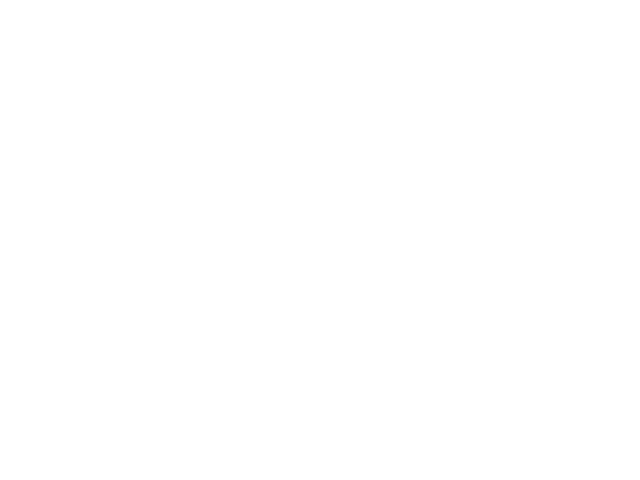

<IPython.core.display.Javascript object>


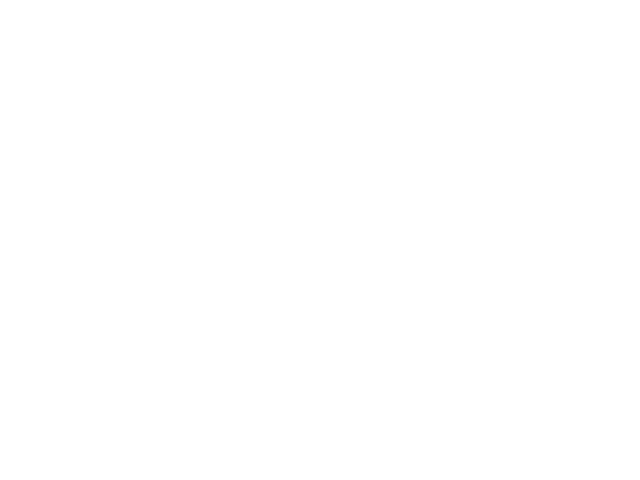

In [735]:
plt.figure()
plt.plot(yactual[0,2],c='k',alpha=0.75,label='measured')
plt.plot(ypred[0,2],c='c',alpha=0.75,label='predicted')
plt.xlabel('trial #')
plt.ylabel('mean eye position (pix)')
plt.title('Decoding horizontal eye position from gray screen neural responses')
plt.legend()
plt.savefig('neural_data_to_eye_pos_meas_pred.pdf')

plt.figure()
plt.plot(yactual[1,2],c='k',alpha=0.75,label='measured')
plt.plot(ypred[1,2],c='g',alpha=0.75,label='predicted')
plt.xlabel('trial #')
plt.ylabel('within-trial eye movement (pix)')
plt.title('Decoding within-trial eye movements')
plt.legend()
plt.savefig('neural_data_to_eye_mvt_meas_pred.pdf')

In [708]:
def plot_r2_scores(arr,lbl,c,rolls=rolls):
#     plt.legend(lbl) #+' variance explained'
    xticks = rolls
    plt.errorbar(xticks,arr.mean(1),sst.sem(arr,1),c=c,label=lbl)
    plt.scatter(xticks,arr.mean(1),c=c,label=None)
    plt.ylabel('cross-validated $R^2$')
    ticklbls = np.array([str(x) for x in xticks])
    ctr_pt = np.where(np.array(rolls)==0)[0][0]
    plus = np.where(np.array(rolls)>0)[0]
    ticklbls[ctr_pt] = 'same trial'
    for item in plus:
        ticklbls[item] = '+'+ticklbls[item]
    plt.xticks(xticks,ticklbls)

<IPython.core.display.Javascript object>


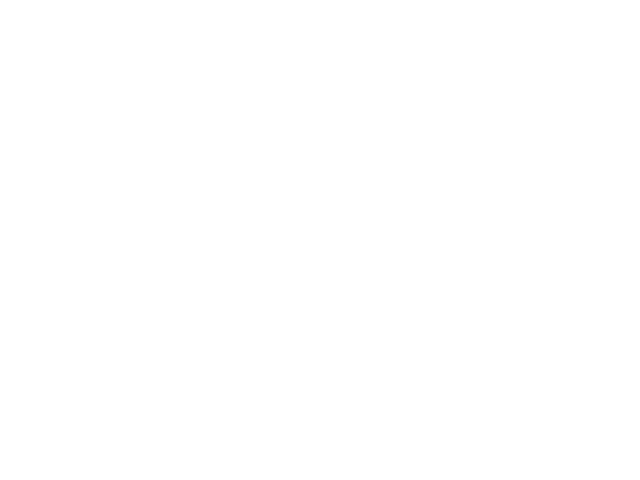

In [715]:
plt.figure()
# plt.title('Eye position variance explained')
# plt.plot(top_score[k][0,0,:],c='c')
plot_r2_scores(top_score[k][0,0],'Eye position','c',rolls) # 'Eye position',
plot_r2_scores(top_score[k][0,1],'Eye movement','g',rolls)
plt.xticks(rolls,['-2','-1','same trial','+1','+2'])
# plot_r2_scores(top_score[k][0,2],'Pupil diameter','m')
plt.legend() #['Eye position','Eye movement'])
plt.title('Predicting eye movements from "spontaneous" neural activity')
plt.tight_layout()
plt.savefig('r2_neural_data_to_kinematic_variables.pdf')
# plt.ylabel('cross-validated $R^2$')
# plt.xticks([0,1,2],['prev.trial','current trial','next trial'])
# plt.figure()
# plt.title('Eye movement variance explained')
# plt.plot(top_score[k][0,1,:],c='g')
# plt.ylabel('cross-validated $R^2$')
# plt.tight_layout()
# plt.plot(top_score[k][0,1])
# plt.plot(top_score[k][0,2])

In [1027]:
def compute_r2(x,y):
    if len(x.shape)==1:
        lkat = np.logical_and(~np.isnan(x),~np.isnan(y))
        X = x[lkat,np.newaxis]
    else:
        lkat = np.logical_and(~np.isnan(x.sum(1)),~np.isnan(y))
        X = x[lkat,:]
    Y = y[lkat]
    linreg = sklearn.linear_model.LinearRegression()
    skf = sklearn.model_selection.ShuffleSplit(n_splits=cv)
    reg = linreg.fit(X,Y)
    return sklearn.model_selection.cross_val_score(linreg,X,Y,cv=skf)

In [505]:
def which_of_these(args,z):
    return args[z].copy()

In [508]:
r2z = np.zeros((nz,nr,cv))
for z in range(nz):
    for iroll,roll in enumerate(rolls):
        val = which_of_these((ctrx,eye_mvt,area),z)
#         if z==0:
#             val = ctrx.copy() #np.roll(,roll)
#         elif z==1:
#             val = eye_mvt.copy() # np.roll(,roll)
#         elif z==2:
#             val = area.copy() #np.roll(,roll)
        r2z[z,iroll] = compute_r2(val[stim_of_interest_no_contrast],np.roll(val,roll)[stim_of_interest_no_contrast])

In [739]:
r2zz = np.zeros((nz+1,nz+1,nr,cv))
for z1 in range(nz+1):
    for z2 in range(nz+1):
        for iroll,roll in enumerate(rolls):
            val1 = which_of_these((ctrx,eye_mvt,area,running_speed_cm_s),z1)
            val2 = which_of_these((ctrx,eye_mvt,area,running_speed_cm_s),z2)
            r2zz[z1,z2,iroll] = compute_r2(val1[stim_of_interest_no_contrast],np.roll(val2,roll)[stim_of_interest_no_contrast])

In [753]:
np.concatenate(r2zz[i,j].mean(-1)

(5, 10)

<IPython.core.display.Javascript object>


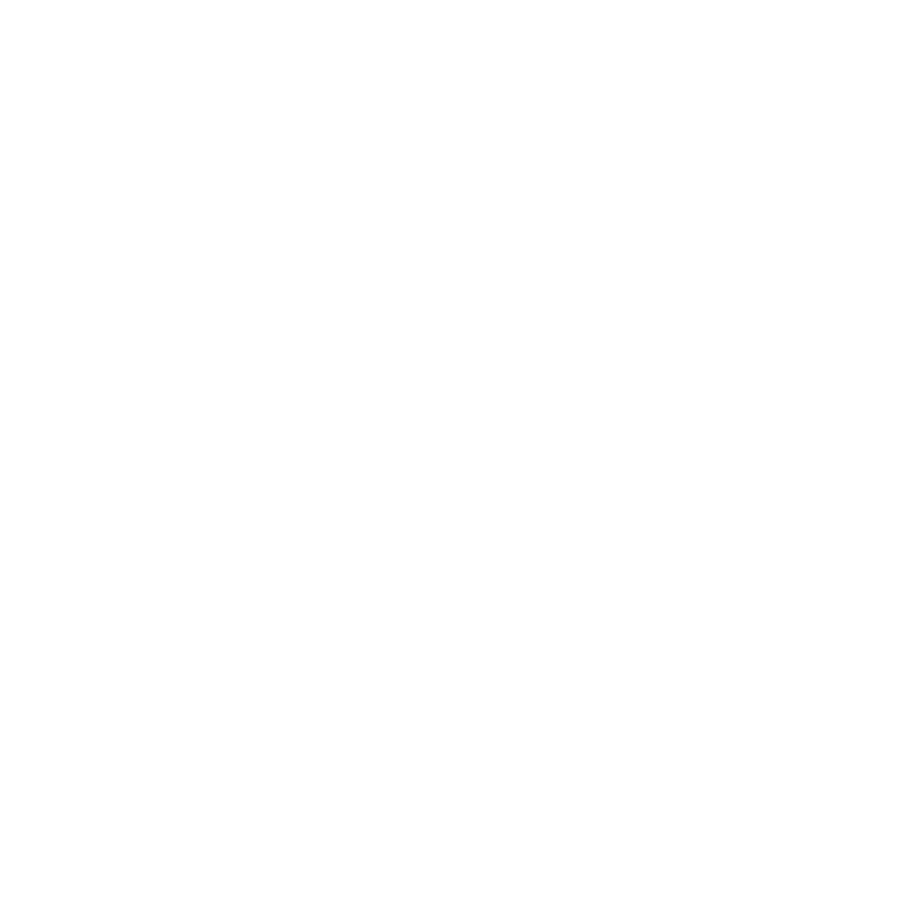

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [759]:
lbls = ['eye pos','eye mvt','pupil diam','running']
plt.close('all')
plt.figure(figsize=(9,9))
for i in range(nz+1):
    for j in range(nz+1):
        plt.subplot(nz+1,nz+1,(nz+1)*i+j+1)
        plot_r2_scores(r2zz[i,j],'','k')
        plt.fill_between(rolls,r2zz[i,j].mean(-1),FaceColor=(0.5,0.5,0.5))
#         plt.fill(rolls,np.zeros_like(rolls),c=(0.5,0.5,0.5))
        plt.ylim((-0.25,1.25))
        plt.title(lbls[j] + ' from ' + lbls[i])
        plt.axis('off')
plt.subplot(nz+1,nz+1,1) # 3*(nz+1)+
plt.axis('on')
plt.tight_layout()
plt.savefig('kinematic_correlation_matrix.pdf')

In [492]:
compute_r2(eye_mvt[running_speed_cm_s>30],np.roll(eye_mvt,-1)[running_speed_cm_s>30]).mean()

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.018175764373834946

In [480]:
compute_r2(area[running_speed_cm_s>30],np.roll(area,0)[running_speed_cm_s>30]).mean()

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


1.0

<IPython.core.display.Javascript object>


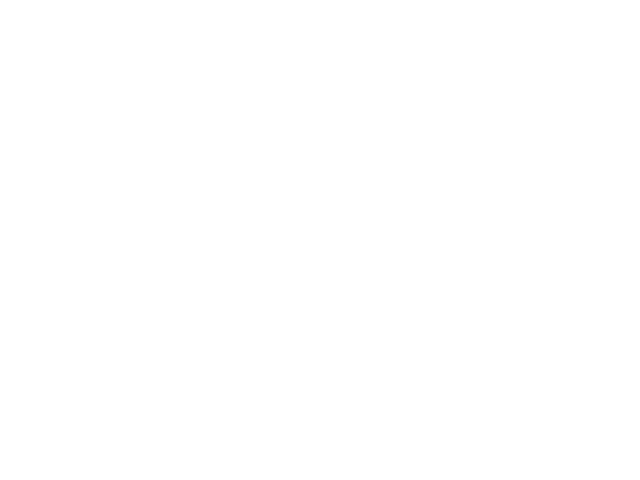

In [279]:
plt.figure()
plt.plot(eye_mvt)

In [151]:
best_cutoff = np.argmax(top_score[k].mean(-1).mean(-1),axis=0)

In [119]:
%matplotlib notebook

<IPython.core.display.Javascript object>


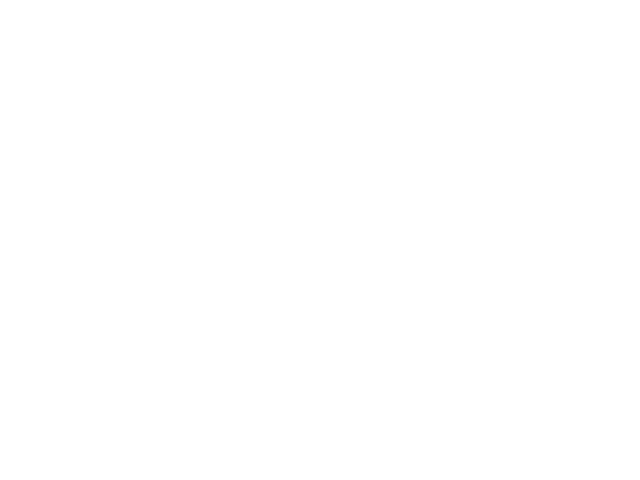

In [760]:
plt.figure()
plt.plot(ctry)

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


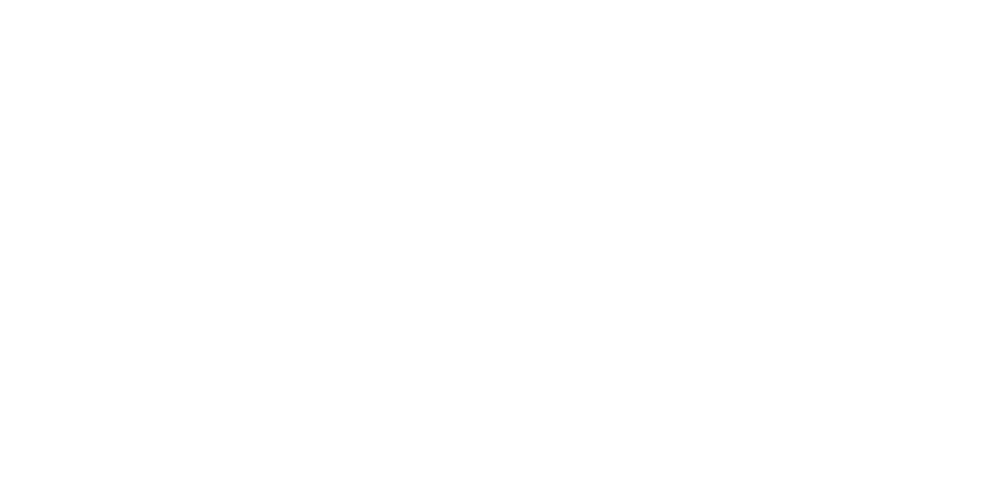

In [184]:

icutoff = 1

x = R[k][icutoff] @ v[:cutoffs[icutoff]]

plt.figure(figsize=(10,5))
for z in range(2):
    plt.subplot(1,2,z+1)
    plt.plot(np.abs(x[z]))

In [180]:
z = 0
based_on = np.abs(x[z])
xtuned = np.where(based_on>np.percentile(based_on,99))[0]

In [181]:
response[:,xtuned,:,0,:].reshape((14,2,40))[0].shape

(2, 40)

<IPython.core.display.Javascript object>


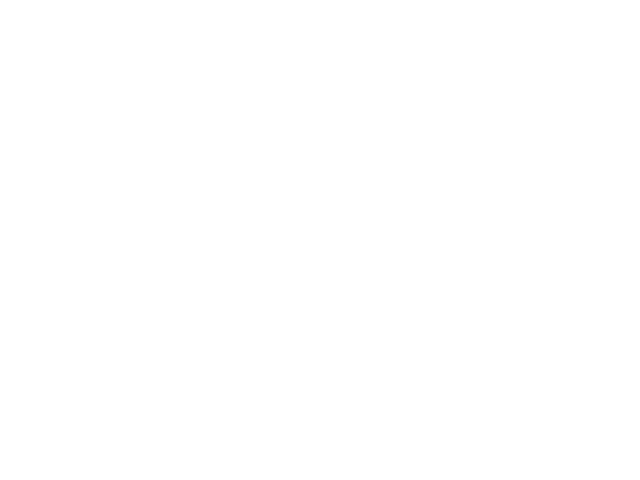

<IPython.core.display.Javascript object>


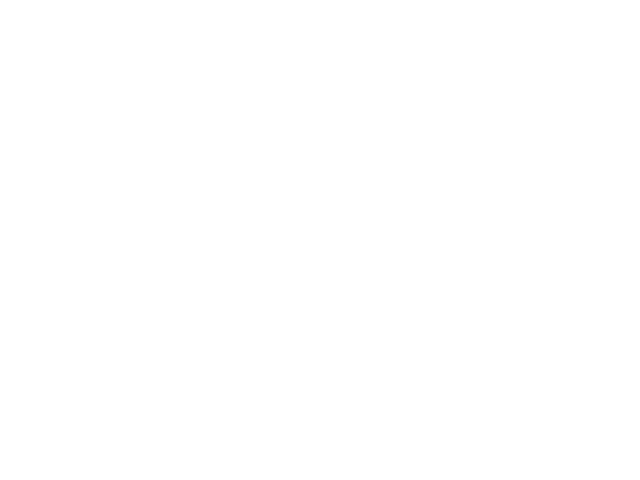

<IPython.core.display.Javascript object>


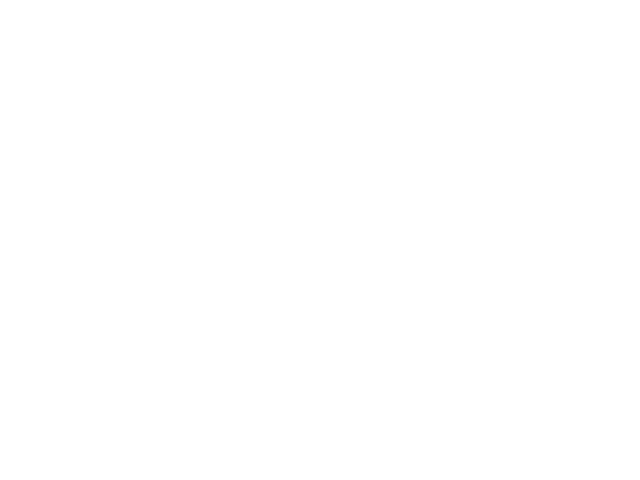

<IPython.core.display.Javascript object>


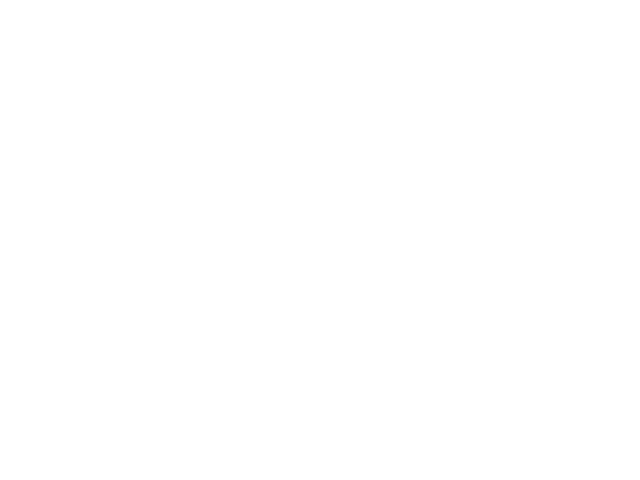

<IPython.core.display.Javascript object>


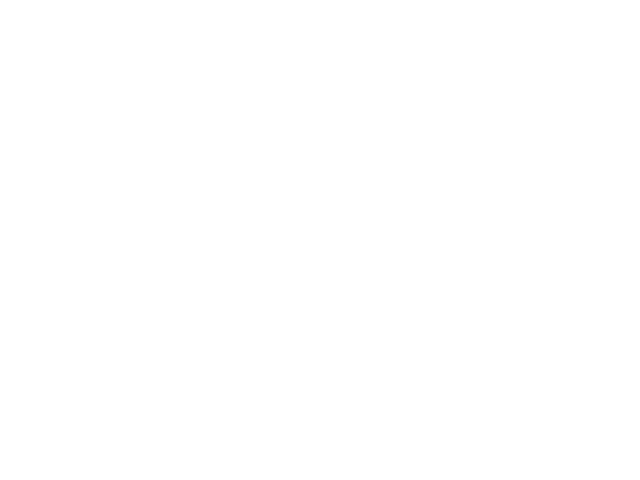

<IPython.core.display.Javascript object>


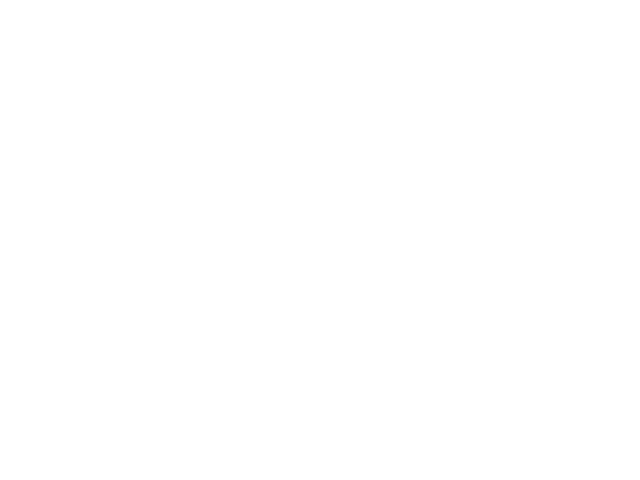

<IPython.core.display.Javascript object>


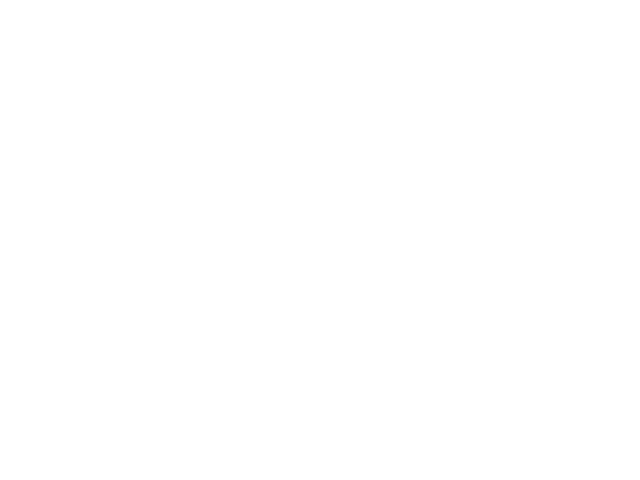

<IPython.core.display.Javascript object>


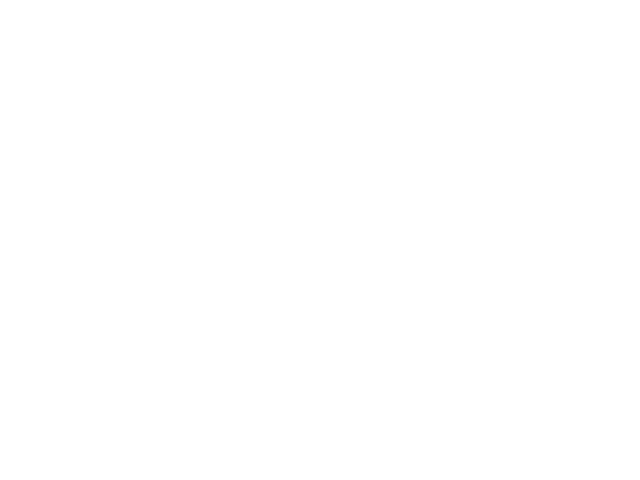

<IPython.core.display.Javascript object>


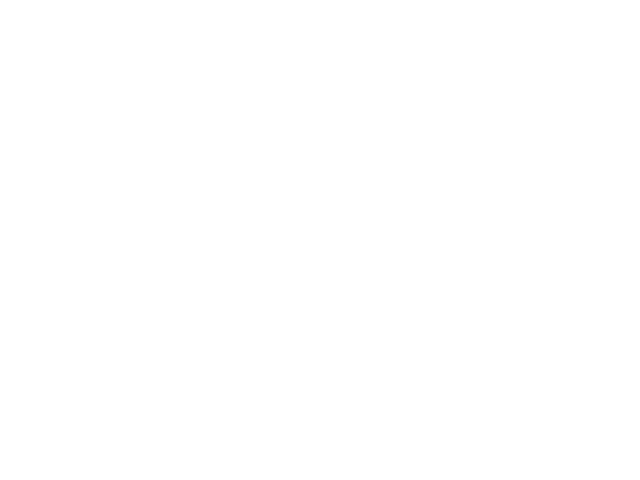

<IPython.core.display.Javascript object>


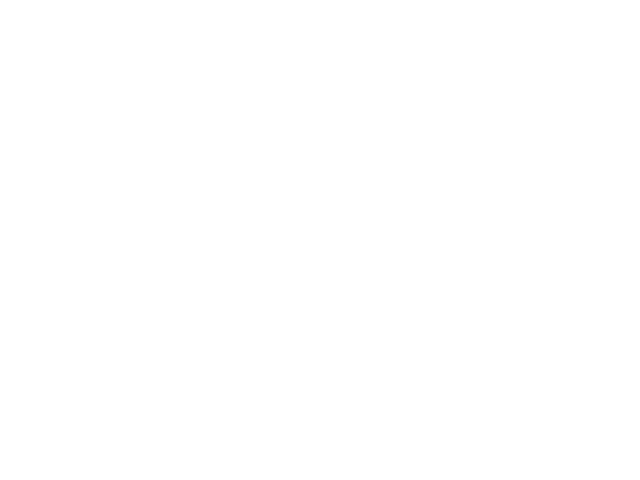

<IPython.core.display.Javascript object>


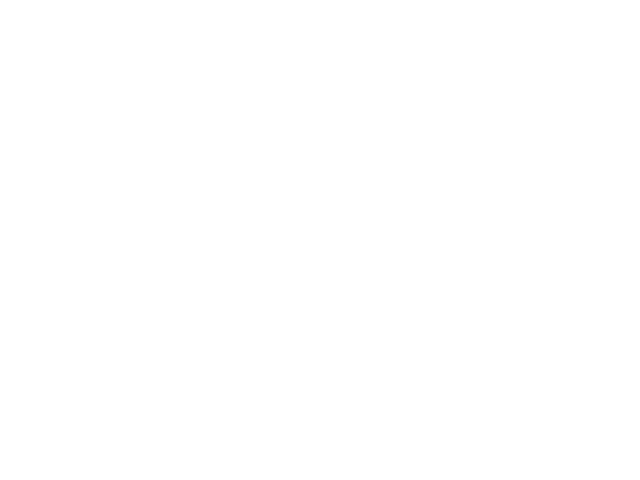

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


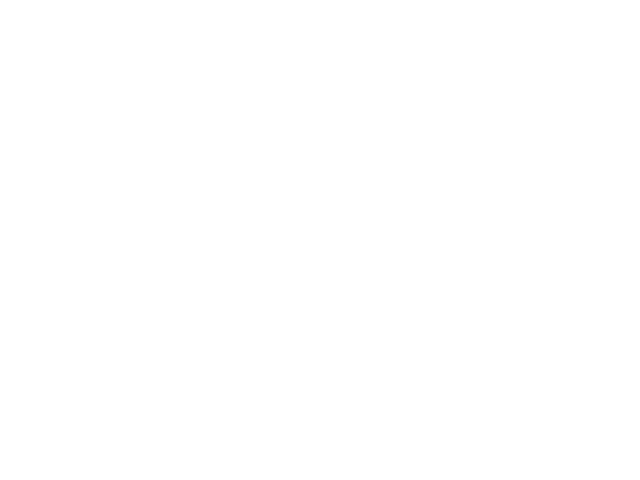

<IPython.core.display.Javascript object>


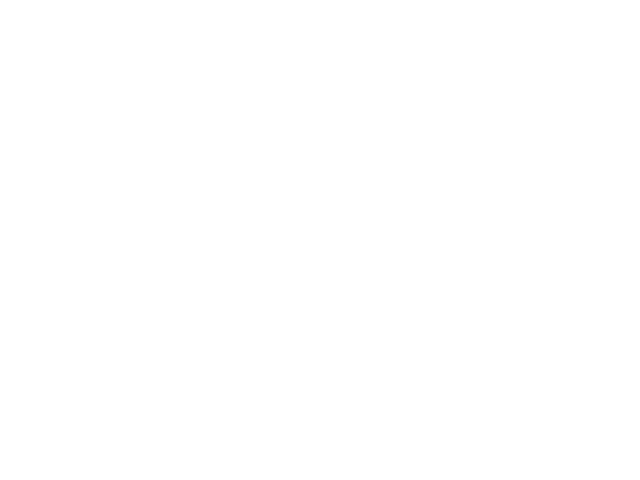

<IPython.core.display.Javascript object>


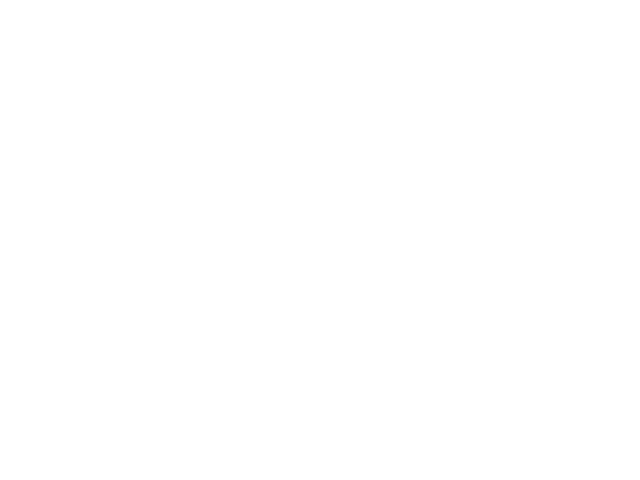

In [183]:
for ind in range(len(xtuned)):
    plt.figure()
    for z in range(2):
        plt.hist(response[:,xtuned,:,0,:].reshape((len(xtuned),2,40))[ind][z],alpha=0.5,bins=20)

<IPython.core.display.Javascript object>


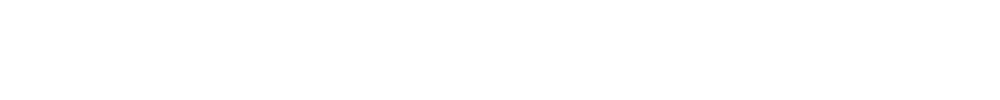

In [173]:
ut.imshow_in_pairs(np.nanmean(response[0][xtuned],-1),np.nanmean(response[1][xtuned],-1))
# ut.imshow_in_rows(np.nanmean(response[1][xtuned],-1))

In [165]:
def scatter_bin_stat(x,y):
    plt.scatter(x,y,s=5,c='b')
    binmean,binedge,_ = sst.binned_statistic(x,y)
    binstd,_,_ = sst.binned_statistic(x,y,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')

<IPython.core.display.Javascript object>


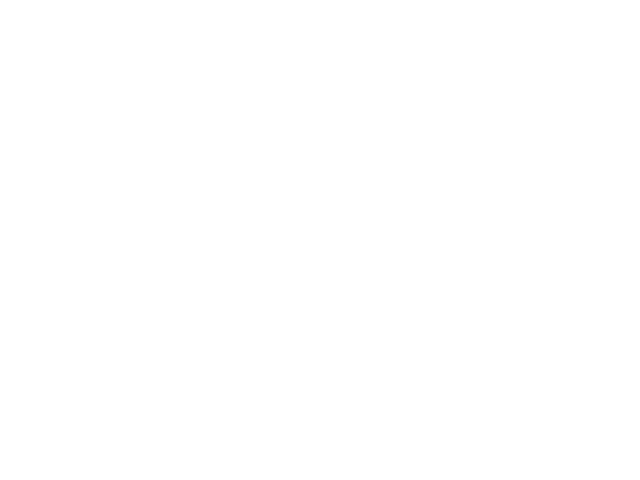

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [167]:
plt.figure()
running = running_speed_cm_s > 50
scatter_bin_stat(running_speed_cm_s[running],ctrx[running])

In [89]:
# plt.figure(figsize=(16,2))
for k in range(len(top_score)):
#     plt.subplot(1,len(top_score),k+1)
    if not top_score[k] is None:
#         plt.plot(top_score[k].mean(-1))
        print(str(k)+': '+str(top_score[k].mean(-1)))
#         plt.ylim((0,1))

1: [[ 0.62675018  0.74605815  0.81555319  0.89865258  0.93587644]]
2: [[ 0.71644505  0.75300289  0.8237218   0.82796835  0.78960788]]
4: [[ 0.451723    0.57865448  0.62782452  0.70267762  0.61986774]]
7: [[ 0.71901893  0.76232826  0.834637    0.88780608  0.88526215]]
8: [[ 0.06802395  0.22968241  0.51633784  0.51999442  0.66488086]]


In [55]:
np.save('ridge_regression_coefficients.npy',{'R':R})

In [50]:
def dot_product(v1,v2):
    return (v1*v2).sum()/np.sqrt((v1**2).sum())/np.sqrt((v2**2).sum())
dp = np.ones((nkey,nsize,nangle,nangle))*np.nan
for k in range(nkey):
    if not R[k] is None:
        for s in range(5):
            for i in range(nangle):
                for j in range(nangle):
                    dp[k,s,i,j] = dot_product(R[k][0][s,i],R[k][0][s,j])

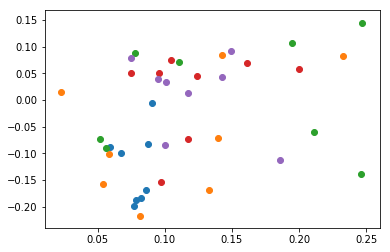

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
c = -1
k = 2
for s in range(5):
    ax.scatter(R[k][c][s,:,0],R[k][c][s,:,1])

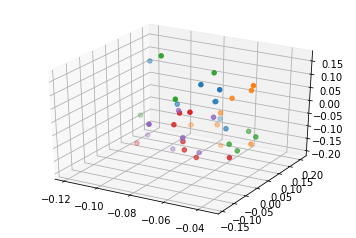

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for s in range(5):
    ax.scatter(R[1][c][s,:,0],R[1][c][s,:,1],R[1][c][s,:,2])

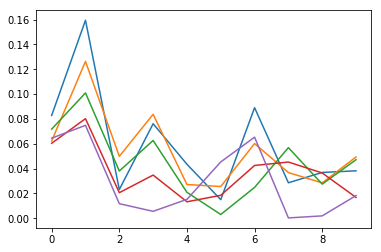

In [34]:
plt.figure()
for s in range(5):
    plt.plot(np.abs(R[1][c][s].mean(0))[:10])

In [35]:
plt.figure()
for i in range(nangle):
    plt.plot(u[:,:cutoffs[c]] @ R[1][c][0,i][0])

ValueError: Scalar operands are not allowed, use '*' instead

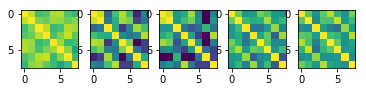

In [51]:
plt.figure()
for s in range(5):
    plt.subplot(1,5,s+1)
    plt.imshow(dp[1,s],vmin=0,vmax=1)

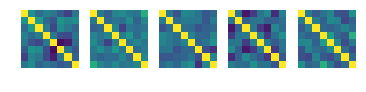

In [40]:
plt.figure()
for s in range(5):
    plt.subplot(1,nsize,s+1)
    plt.imshow(np.nanmean(dp[:,s],0),vmin=0,vmax=1)
    plt.axis('off')

In [214]:
plt.close('all')

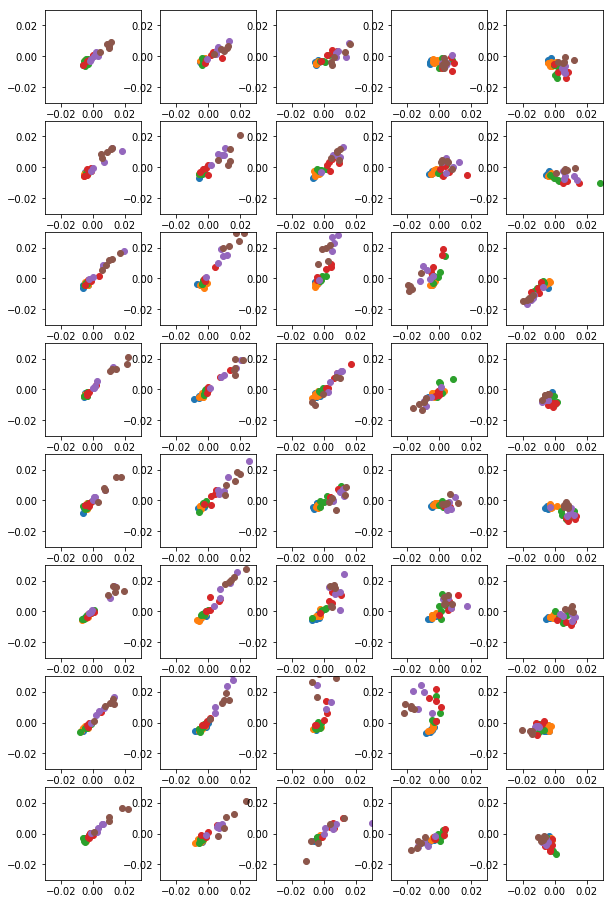

In [56]:
k = 1

size = proc[k]['size']
contrast = proc[k]['contrast']
angle = proc[k]['angle']
v = proc[k]['v']

c = -1
s = 0
a = 0
x = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])
s = 0
a = 2
y = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])

fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1)#,projection='3d')
#         ax.view_init(0, 45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(x[lkat],y[lkat])#,z[lkat])
        ax.set_xlim(-0.03,0.03)
        ax.set_ylim(-0.03,0.03)

In [51]:
R[k]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [45]:
c = 0
s = -1
a = 0
x = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])
s = -1
a = 2
y = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])

fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1)#,projection='3d')
#         ax.view_init(0, 45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(x[lkat],y[lkat])#,z[lkat])
        ax.set_xlim(-0.04,0.04)
        ax.set_ylim(-0.04,0.04)

TypeError: 'NoneType' object is not subscriptable

In [80]:
np.mod(a+2,8)

1

In [81]:
a

7

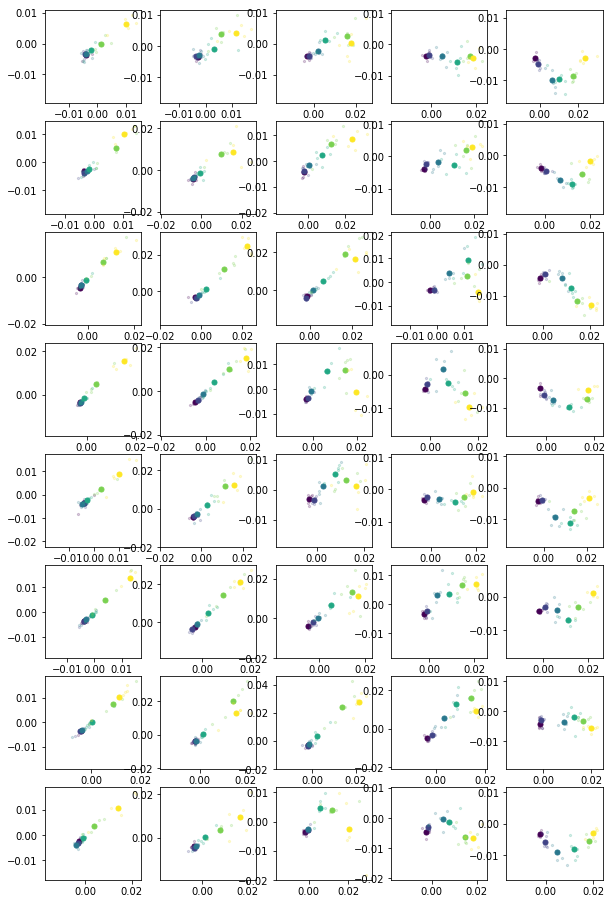

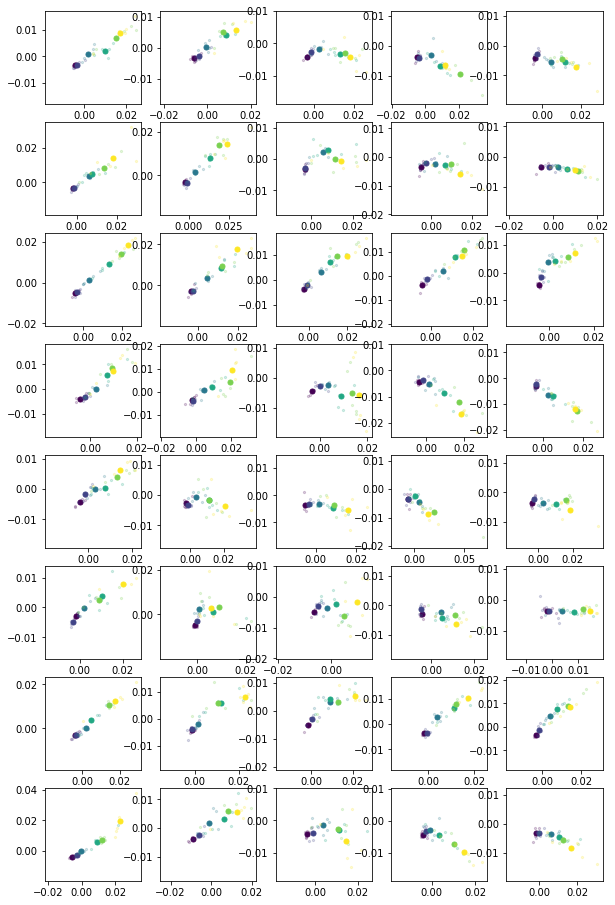

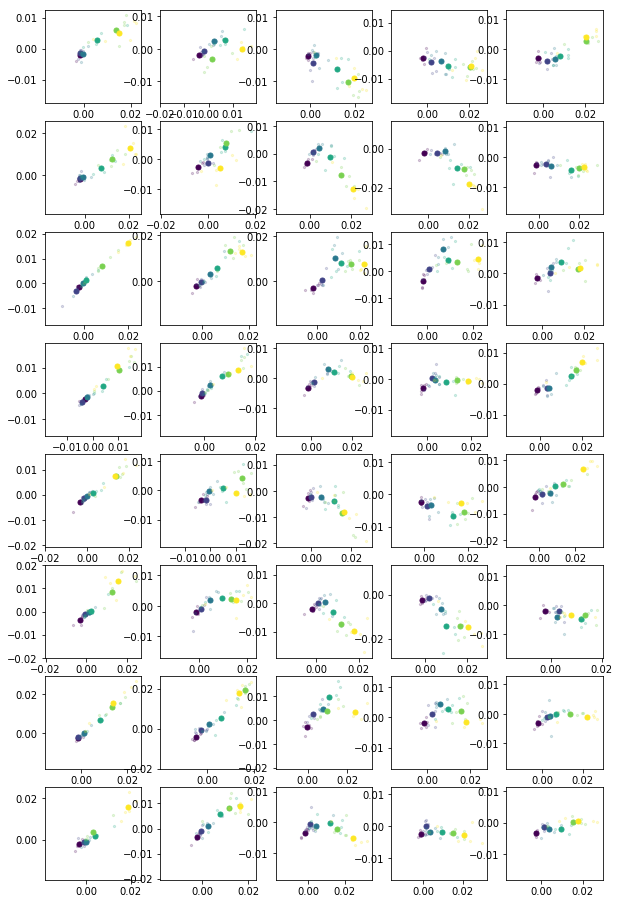

In [91]:
for k in (1,2,7):
    colors = plt.cm.viridis(np.linspace(0,1,6))

    v = proc[k]['v']
    contrast = proc[k]['contrast']
    size = proc[k]['size']
    angle = proc[k]['angle']

    icutoff = 0

    s = -1
    a = 0
    x = (R[k][icutoff][s,:].mean(0) @ v[:cutoffs[icutoff]])

    s = -1
    a = 2
    y = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

    s = 0
    a = 2
    z = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

    fig = plt.figure(figsize=(10,16))
    for a in range(8):
        s = -1
#         y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
        for s in range(5):
            y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
            ax = plt.subplot(8,5,a*5+s+1) #,projection='3d')
    #         ax.view_init(0, 0)
            for c in range(6):
                lkat = k_and(contrast==c,size==s,angle==a)
                ax.scatter(y[lkat],z[lkat],s=5,c=colors[c],alpha=0.2)
                ax.scatter(y[lkat].mean(),z[lkat].mean(),s=25,c=colors[c])
    #         ax.set_xlim(-0.03,0.03)
    #         ax.set_ylim(-0.03,0.03)
    #         ax.set_zlim(-0.03,0.03)

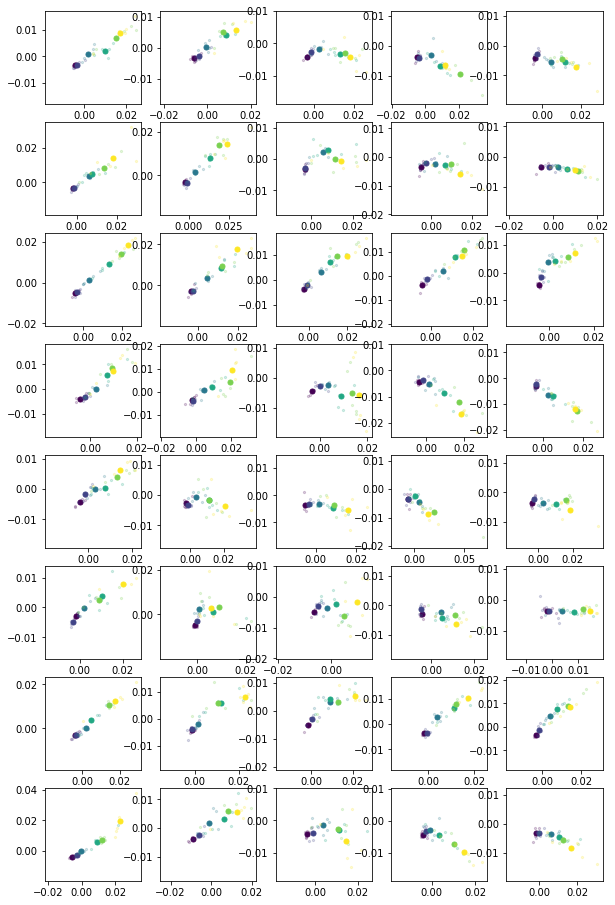

In [85]:
k = 2

colors = plt.cm.viridis(np.linspace(0,1,6))

v = proc[k]['v']
contrast = proc[k]['contrast']
size = proc[k]['size']
angle = proc[k]['angle']

icutoff = 0

s = -1
a = 0
x = (R[k][icutoff][s,:].mean(0) @ v[:cutoffs[icutoff]])

s = -1
a = 2
y = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

s = 0
a = 2
z = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

fig = plt.figure(figsize=(10,16))
for a in range(8):
    for s in range(5):
        y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
        ax = plt.subplot(8,5,a*5+s+1) #,projection='3d')
#         ax.view_init(0, 0)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(y[lkat],z[lkat],s=5,c=colors[c],alpha=0.2)
            ax.scatter(y[lkat].mean(),z[lkat].mean(),s=25,c=colors[c])

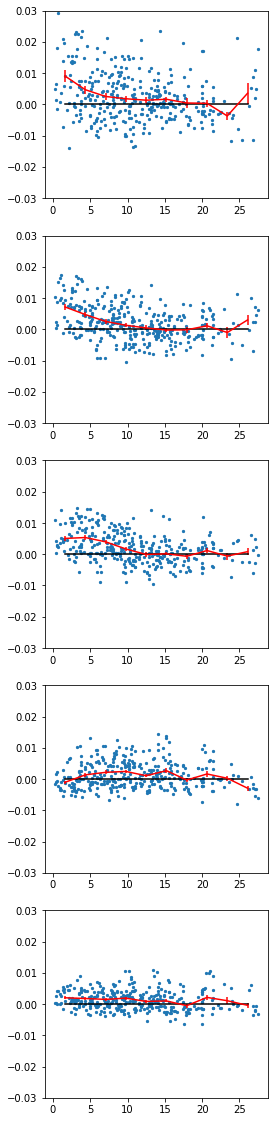

In [90]:
plt.figure(figsize=(4,20))
c = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
for s in range(5):
    regression_weight = (u[:,:cutoffs[c]] @ R[k][c][s].mean(0))[ontarget_ret_lax]
    plt.subplot(5,1,s+1)
    plt.scatter(distance,regression_weight,s=5)
    binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
    binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
    plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')
    plt.ylim((-0.03,0.03))

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


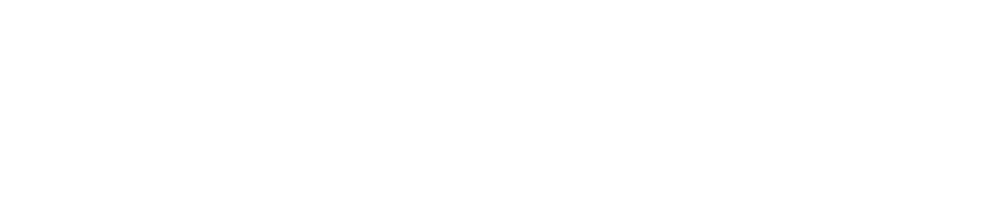

(10, 0, 0, 0.58333333333333337)
(10, 0, 0, 0.58333333333333337)
(10, 0, 0, 0.33333333333333331)
(10, 0, 0, 0.63888888888888884)
(10, 0, 0, 0.61111111111111105)
(10, 0, 0, 0.66666666666666663)
(10, 0, 0, 0.75)
(10, 0, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 1, 0.58333333333333337)
(10, 0, 1, 0.5)
(10, 0, 1, 0.58333333333333337)
(10, 0, 1, 0.75)
(10, 0, 1, 0.5)
(10, 0, 1, 0.41666666666666669)
(10, 0, 1, 0.66666666666666663)
(10, 0, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 2, 0.58333333333333337)
(10, 0, 2, 0.33333333333333331)
(10, 0, 2, 0.66666666666666663)
(10, 0, 2, 0.91666666666666663)
(10, 0, 2, 0.75)
(10, 0, 2, 0.16666666666666666)
(10, 0, 2, 0.66666666666666663)
(10, 0, 2, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 3, 0.5)
(10, 0, 3, 0.75)
(10, 0, 3, 0.83333333333333337)
(10, 0, 3, 0.61111111111111105)
(10, 0, 3, 0.75)
(10, 0, 3, 0.41666666666666669)
(10, 0, 3, 0.75)
(10, 0, 3, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 4, 0.75)
(10, 0, 4, 0.91666666666666663)
(10, 0, 4, 0.75)
(10, 0, 4, 0.91666666666666663)
(10, 0, 4, 1.0)
(10, 0, 4, 0.83333333333333337)
(10, 0, 4, 0.75)
(10, 0, 4, 0.83333333333333337)
(10, 1, 0, 0.58333333333333337)
(10, 1, 0, 0.83333333333333337)
(10, 1, 0, 0.52777777777777779)
(10, 1, 0, 0.66666666666666663)
(10, 1, 0, 0.33333333333333331)
(10, 1, 0, 0.5)
(10, 1, 0, 0.72222222222222221)
(10, 1, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.91666666666666663)
(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.5)
(10, 1, 1, 0.66666666666666663)
(10, 1, 1, 0.5)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 2, 0.75)
(10, 1, 2, 0.55555555555555547)
(10, 1, 2, 0.66666666666666663)
(10, 1, 2, 0.66666666666666663)
(10, 1, 2, 0.91666666666666663)
(10, 1, 2, 0.83333333333333337)
(10, 1, 2, 0.75)
(10, 1, 2, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 3, 0.58333333333333337)
(10, 1, 3, 0.75)
(10, 1, 3, 0.83333333333333337)
(10, 1, 3, 0.91666666666666663)
(10, 1, 3, 0.83333333333333337)
(10, 1, 3, 0.75)
(10, 1, 3, 1.0)
(10, 1, 3, 0.5)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 4, 1.0)
(10, 1, 4, 0.91666666666666663)
(10, 1, 4, 1.0)
(10, 1, 4, 0.91666666666666663)
(10, 1, 4, 0.66666666666666663)
(10, 1, 4, 0.83333333333333337)
(10, 1, 4, 0.83333333333333337)
(10, 1, 4, 0.91666666666666663)
(10, 2, 0, 0.41666666666666669)
(10, 2, 0, 0.5)
(10, 2, 0, 0.66666666666666663)
(10, 2, 0, 0.75)
(10, 2, 0, 0.91666666666666663)
(10, 2, 0, 0.66666666666666663)
(10, 2, 0, 0.5)
(10, 2, 0, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 1, 0.83333333333333337)
(10, 2, 1, 0.66666666666666663)
(10, 2, 1, 1.0)
(10, 2, 1, 0.58333333333333337)
(10, 2, 1, 0.66666666666666663)
(10, 2, 1, 0.5)
(10, 2, 1, 0.91666666666666663)
(10, 2, 1, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 2, 0.83333333333333337)
(10, 2, 2, 1.0)
(10, 2, 2, 0.83333333333333337)
(10, 2, 2, 0.91666666666666663)
(10, 2, 2, 0.66666666666666663)
(10, 2, 2, 0.66666666666666663)
(10, 2, 2, 0.83333333333333337)
(10, 2, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 3, 0.83333333333333337)
(10, 2, 3, 0.91666666666666663)
(10, 2, 3, 1.0)
(10, 2, 3, 0.83333333333333337)
(10, 2, 3, 0.91666666666666663)
(10, 2, 3, 0.91666666666666663)
(10, 2, 3, 0.83333333333333337)
(10, 2, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 4, 0.91666666666666663)
(10, 2, 4, 1.0)
(10, 2, 4, 1.0)
(10, 2, 4, 1.0)
(10, 2, 4, 0.75)
(10, 2, 4, 0.91666666666666663)
(10, 2, 4, 0.91666666666666663)
(10, 2, 4, 0.91666666666666663)
(10, 3, 0, 0.66666666666666663)
(10, 3, 0, 0.83333333333333337)
(10, 3, 0, 0.75)
(10, 3, 0, 0.5)
(10, 3, 0, 0.75)
(10, 3, 0, 0.61111111111111105)
(10, 3, 0, 0.75)
(10, 3, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 1, 1.0)
(10, 3, 1, 1.0)
(10, 3, 1, 0.75)
(10, 3, 1, 1.0)
(10, 3, 1, 1.0)
(10, 3, 1, 1.0)
(10, 3, 1, 0.91666666666666663)
(10, 3, 1, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 2, 1.0)
(10, 3, 2, 1.0)
(10, 3, 2, 0.58333333333333337)
(10, 3, 2, 0.41666666666666669)
(10, 3, 2, 0.58333333333333337)
(10, 3, 2, 0.66666666666666663)
(10, 3, 2, 0.91666666666666663)
(10, 3, 2, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 3, 0.91666666666666663)
(10, 3, 3, 1.0)
(10, 3, 3, 0.75)
(10, 3, 3, 1.0)
(10, 3, 3, 1.0)
(10, 3, 3, 1.0)
(10, 3, 3, 0.91666666666666663)
(10, 3, 3, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 4, 0.91666666666666663)
(10, 3, 4, 0.83333333333333337)
(10, 3, 4, 1.0)
(10, 3, 4, 0.83333333333333337)
(10, 3, 4, 0.91666666666666663)
(10, 3, 4, 0.91666666666666663)
(10, 3, 4, 1.0)
(10, 3, 4, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 0.91666666666666663)
(10, 4, 0, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 0.83333333333333337)
(10, 4, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 1, 0.91666666666666663)
(10, 4, 1, 0.83333333333333337)
(10, 4, 1, 0.91666666666666663)
(10, 4, 1, 1.0)
(10, 4, 1, 0.91666666666666663)
(10, 4, 1, 1.0)
(10, 4, 1, 1.0)
(10, 4, 1, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 2, 0.25)
(10, 4, 2, 0.66666666666666663)
(10, 4, 2, 0.75)
(10, 4, 2, 0.66666666666666663)
(10, 4, 2, 0.83333333333333337)
(10, 4, 2, 0.58333333333333337)
(10, 4, 2, 0.66666666666666663)
(10, 4, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 0.91666666666666663)
(10, 4, 4, 1.0)


<IPython.core.display.Javascript object>


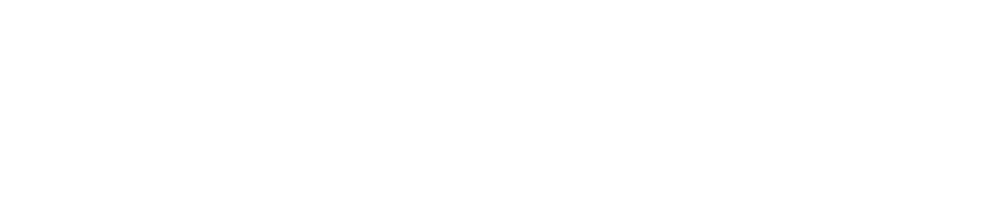

(30, 0, 0, 0.58333333333333337)
(30, 0, 0, 0.75)
(30, 0, 0, 0.5)
(30, 0, 0, 0.80555555555555547)
(30, 0, 0, 0.61111111111111105)
(30, 0, 0, 0.83333333333333337)
(30, 0, 0, 0.41666666666666669)
(30, 0, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 1, 0.5)
(30, 0, 1, 0.33333333333333331)
(30, 0, 1, 0.58333333333333337)
(30, 0, 1, 0.58333333333333337)
(30, 0, 1, 0.25)
(30, 0, 1, 0.41666666666666669)
(30, 0, 1, 0.66666666666666663)
(30, 0, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 2, 0.58333333333333337)
(30, 0, 2, 0.33333333333333331)
(30, 0, 2, 0.66666666666666663)
(30, 0, 2, 0.52777777777777779)
(30, 0, 2, 0.5)
(30, 0, 2, 0.16666666666666666)
(30, 0, 2, 0.5)
(30, 0, 2, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 3, 0.5)
(30, 0, 3, 0.66666666666666663)
(30, 0, 3, 0.66666666666666663)
(30, 0, 3, 0.52777777777777779)
(30, 0, 3, 0.66666666666666663)
(30, 0, 3, 0.16666666666666666)
(30, 0, 3, 0.83333333333333337)
(30, 0, 3, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 4, 0.58333333333333337)
(30, 0, 4, 0.83333333333333337)
(30, 0, 4, 0.66666666666666663)
(30, 0, 4, 0.91666666666666663)
(30, 0, 4, 0.83333333333333337)
(30, 0, 4, 0.91666666666666663)
(30, 0, 4, 0.91666666666666663)
(30, 0, 4, 0.75)
(30, 1, 0, 0.58333333333333337)
(30, 1, 0, 0.75)
(30, 1, 0, 0.61111111111111105)
(30, 1, 0, 0.91666666666666663)
(30, 1, 0, 0.41666666666666669)
(30, 1, 0, 0.41666666666666669)
(30, 1, 0, 0.61111111111111105)
(30, 1, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 1, 0.58333333333333337)
(30, 1, 1, 0.75)
(30, 1, 1, 0.66666666666666663)
(30, 1, 1, 0.33333333333333331)
(30, 1, 1, 0.5)
(30, 1, 1, 0.41666666666666669)
(30, 1, 1, 0.58333333333333337)
(30, 1, 1, 0.33333333333333331)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 2, 0.58333333333333337)
(30, 1, 2, 0.80555555555555547)
(30, 1, 2, 0.5)
(30, 1, 2, 0.83333333333333337)
(30, 1, 2, 0.83333333333333337)
(30, 1, 2, 0.83333333333333337)
(30, 1, 2, 0.66666666666666663)
(30, 1, 2, 0.5)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 3, 0.66666666666666663)
(30, 1, 3, 0.75)
(30, 1, 3, 0.75)
(30, 1, 3, 0.83333333333333337)
(30, 1, 3, 0.91666666666666663)
(30, 1, 3, 0.58333333333333337)
(30, 1, 3, 0.91666666666666663)
(30, 1, 3, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 4, 1.0)
(30, 1, 4, 0.75)
(30, 1, 4, 1.0)
(30, 1, 4, 0.75)
(30, 1, 4, 0.75)
(30, 1, 4, 0.75)
(30, 1, 4, 0.83333333333333337)
(30, 1, 4, 0.75)
(30, 2, 0, 0.5)
(30, 2, 0, 0.75)
(30, 2, 0, 0.44444444444444442)
(30, 2, 0, 0.58333333333333337)
(30, 2, 0, 0.66666666666666663)
(30, 2, 0, 0.66666666666666663)
(30, 2, 0, 0.75)
(30, 2, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 1, 0.91666666666666663)
(30, 2, 1, 0.5)
(30, 2, 1, 0.75)
(30, 2, 1, 0.58333333333333337)
(30, 2, 1, 0.75)
(30, 2, 1, 0.41666666666666669)
(30, 2, 1, 0.83333333333333337)
(30, 2, 1, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 2, 0.83333333333333337)
(30, 2, 2, 0.91666666666666663)
(30, 2, 2, 0.75)
(30, 2, 2, 0.91666666666666663)
(30, 2, 2, 0.75)
(30, 2, 2, 0.5)
(30, 2, 2, 0.91666666666666663)
(30, 2, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 3, 0.66666666666666663)
(30, 2, 3, 1.0)
(30, 2, 3, 0.91666666666666663)
(30, 2, 3, 0.83333333333333337)
(30, 2, 3, 0.91666666666666663)
(30, 2, 3, 0.75)
(30, 2, 3, 0.83333333333333337)
(30, 2, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 4, 0.66666666666666663)
(30, 2, 4, 1.0)
(30, 2, 4, 1.0)
(30, 2, 4, 0.83333333333333337)
(30, 2, 4, 0.66666666666666663)
(30, 2, 4, 0.83333333333333337)
(30, 2, 4, 1.0)
(30, 2, 4, 0.83333333333333337)
(30, 3, 0, 0.75)
(30, 3, 0, 0.91666666666666663)
(30, 3, 0, 0.41666666666666669)
(30, 3, 0, 0.66666666666666663)
(30, 3, 0, 0.66666666666666663)
(30, 3, 0, 0.61111111111111105)
(30, 3, 0, 0.66666666666666663)
(30, 3, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 1, 0.91666666666666663)
(30, 3, 1, 1.0)
(30, 3, 1, 0.66666666666666663)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 2, 0.83333333333333337)
(30, 3, 2, 0.75)
(30, 3, 2, 0.75)
(30, 3, 2, 0.41666666666666669)
(30, 3, 2, 0.58333333333333337)
(30, 3, 2, 0.58333333333333337)
(30, 3, 2, 0.91666666666666663)
(30, 3, 2, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 3, 0.83333333333333337)
(30, 3, 3, 1.0)
(30, 3, 3, 1.0)
(30, 3, 3, 1.0)
(30, 3, 3, 0.91666666666666663)
(30, 3, 3, 1.0)
(30, 3, 3, 0.91666666666666663)
(30, 3, 3, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 4, 0.75)
(30, 3, 4, 0.83333333333333337)
(30, 3, 4, 1.0)
(30, 3, 4, 0.75)
(30, 3, 4, 0.91666666666666663)
(30, 3, 4, 0.91666666666666663)
(30, 3, 4, 1.0)
(30, 3, 4, 0.91666666666666663)
(30, 4, 0, 0.91666666666666663)
(30, 4, 0, 0.66666666666666663)
(30, 4, 0, 1.0)
(30, 4, 0, 1.0)
(30, 4, 0, 1.0)
(30, 4, 0, 0.75)
(30, 4, 0, 0.66666666666666663)
(30, 4, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 0.83333333333333337)
(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 1.0)
(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 1.0)
(30, 4, 1, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 2, 0.41666666666666669)
(30, 4, 2, 0.91666666666666663)
(30, 4, 2, 0.75)
(30, 4, 2, 0.58333333333333337)
(30, 4, 2, 0.75)
(30, 4, 2, 0.58333333333333337)
(30, 4, 2, 0.83333333333333337)
(30, 4, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 0.91666666666666663)
(30, 4, 3, 1.0)
(30, 4, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 0.91666666666666663)
(30, 4, 4, 1.0)


<IPython.core.display.Javascript object>


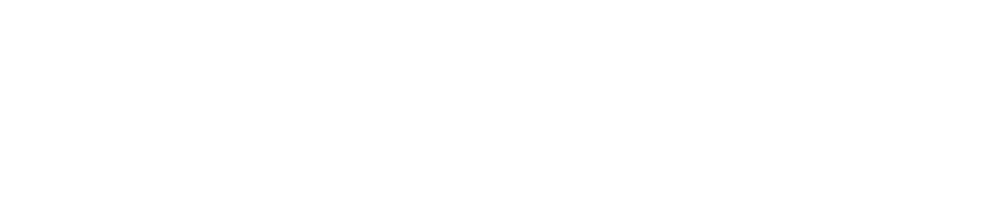

(50, 0, 0, 0.41666666666666669)
(50, 0, 0, 0.58333333333333337)
(50, 0, 0, 0.5)
(50, 0, 0, 0.80555555555555547)
(50, 0, 0, 0.61111111111111105)
(50, 0, 0, 0.83333333333333337)
(50, 0, 0, 0.33333333333333331)
(50, 0, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 1, 0.41666666666666669)
(50, 0, 1, 0.33333333333333331)
(50, 0, 1, 0.41666666666666669)
(50, 0, 1, 0.58333333333333337)
(50, 0, 1, 0.25)
(50, 0, 1, 0.33333333333333331)
(50, 0, 1, 0.66666666666666663)
(50, 0, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 2, 0.66666666666666663)
(50, 0, 2, 0.41666666666666669)
(50, 0, 2, 0.41666666666666669)
(50, 0, 2, 0.63888888888888884)
(50, 0, 2, 0.58333333333333337)
(50, 0, 2, 0.16666666666666666)
(50, 0, 2, 0.66666666666666663)
(50, 0, 2, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 3, 0.41666666666666669)
(50, 0, 3, 0.5)
(50, 0, 3, 0.75)
(50, 0, 3, 0.44444444444444442)
(50, 0, 3, 0.75)
(50, 0, 3, 0.25)
(50, 0, 3, 0.83333333333333337)
(50, 0, 3, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 4, 0.58333333333333337)
(50, 0, 4, 0.75)
(50, 0, 4, 0.66666666666666663)
(50, 0, 4, 0.91666666666666663)
(50, 0, 4, 1.0)
(50, 0, 4, 0.91666666666666663)
(50, 0, 4, 1.0)
(50, 0, 4, 0.75)
(50, 1, 0, 0.41666666666666669)
(50, 1, 0, 0.75)
(50, 1, 0, 0.61111111111111105)
(50, 1, 0, 0.91666666666666663)
(50, 1, 0, 0.33333333333333331)
(50, 1, 0, 0.16666666666666666)
(50, 1, 0, 0.61111111111111105)
(50, 1, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 1, 0.58333333333333337)
(50, 1, 1, 0.75)
(50, 1, 1, 0.91666666666666663)
(50, 1, 1, 0.33333333333333331)
(50, 1, 1, 0.5)
(50, 1, 1, 0.33333333333333331)
(50, 1, 1, 0.66666666666666663)
(50, 1, 1, 0.25)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 2, 0.58333333333333337)
(50, 1, 2, 0.72222222222222221)
(50, 1, 2, 0.5)
(50, 1, 2, 0.83333333333333337)
(50, 1, 2, 0.66666666666666663)
(50, 1, 2, 0.83333333333333337)
(50, 1, 2, 0.66666666666666663)
(50, 1, 2, 0.33333333333333331)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 3, 0.5)
(50, 1, 3, 0.66666666666666663)
(50, 1, 3, 0.75)
(50, 1, 3, 0.75)
(50, 1, 3, 0.83333333333333337)
(50, 1, 3, 0.58333333333333337)
(50, 1, 3, 1.0)
(50, 1, 3, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 4, 0.91666666666666663)
(50, 1, 4, 0.91666666666666663)
(50, 1, 4, 0.91666666666666663)
(50, 1, 4, 0.66666666666666663)
(50, 1, 4, 0.75)
(50, 1, 4, 0.75)
(50, 1, 4, 0.83333333333333337)
(50, 1, 4, 0.75)
(50, 2, 0, 0.66666666666666663)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.38888888888888884)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.75)
(50, 2, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 1, 0.83333333333333337)
(50, 2, 1, 0.5)
(50, 2, 1, 0.75)
(50, 2, 1, 0.75)
(50, 2, 1, 0.75)
(50, 2, 1, 0.41666666666666669)
(50, 2, 1, 0.83333333333333337)
(50, 2, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 2, 1.0)
(50, 2, 2, 1.0)
(50, 2, 2, 0.83333333333333337)
(50, 2, 2, 0.91666666666666663)
(50, 2, 2, 0.75)
(50, 2, 2, 0.5)
(50, 2, 2, 0.83333333333333337)
(50, 2, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 3, 0.66666666666666663)
(50, 2, 3, 1.0)
(50, 2, 3, 0.83333333333333337)
(50, 2, 3, 0.83333333333333337)
(50, 2, 3, 0.83333333333333337)
(50, 2, 3, 0.58333333333333337)
(50, 2, 3, 1.0)
(50, 2, 3, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 4, 0.58333333333333337)
(50, 2, 4, 0.91666666666666663)
(50, 2, 4, 0.91666666666666663)
(50, 2, 4, 0.83333333333333337)
(50, 2, 4, 0.66666666666666663)
(50, 2, 4, 0.83333333333333337)
(50, 2, 4, 1.0)
(50, 2, 4, 0.58333333333333337)
(50, 3, 0, 0.75)
(50, 3, 0, 0.75)
(50, 3, 0, 0.58333333333333337)
(50, 3, 0, 0.41666666666666669)
(50, 3, 0, 0.58333333333333337)
(50, 3, 0, 0.44444444444444442)
(50, 3, 0, 0.58333333333333337)
(50, 3, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 1, 1.0)
(50, 3, 1, 1.0)
(50, 3, 1, 0.58333333333333337)
(50, 3, 1, 1.0)
(50, 3, 1, 1.0)
(50, 3, 1, 1.0)
(50, 3, 1, 0.91666666666666663)
(50, 3, 1, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 2, 0.75)
(50, 3, 2, 0.75)
(50, 3, 2, 0.75)
(50, 3, 2, 0.41666666666666669)
(50, 3, 2, 0.66666666666666663)
(50, 3, 2, 0.58333333333333337)
(50, 3, 2, 0.91666666666666663)
(50, 3, 2, 0.72222222222222221)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 3, 0.83333333333333337)
(50, 3, 3, 0.83333333333333337)
(50, 3, 3, 0.83333333333333337)
(50, 3, 3, 1.0)
(50, 3, 3, 1.0)
(50, 3, 3, 1.0)
(50, 3, 3, 0.91666666666666663)
(50, 3, 3, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 4, 0.91666666666666663)
(50, 3, 4, 0.66666666666666663)
(50, 3, 4, 1.0)
(50, 3, 4, 0.66666666666666663)
(50, 3, 4, 0.91666666666666663)
(50, 3, 4, 0.91666666666666663)
(50, 3, 4, 1.0)
(50, 3, 4, 0.83333333333333337)
(50, 4, 0, 0.66666666666666663)
(50, 4, 0, 0.58333333333333337)
(50, 4, 0, 0.75)
(50, 4, 0, 1.0)
(50, 4, 0, 1.0)
(50, 4, 0, 0.83333333333333337)
(50, 4, 0, 0.58333333333333337)
(50, 4, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.75)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 1.0)
(50, 4, 1, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 2, 0.33333333333333331)
(50, 4, 2, 0.83333333333333337)
(50, 4, 2, 0.66666666666666663)
(50, 4, 2, 0.58333333333333337)
(50, 4, 2, 0.83333333333333337)
(50, 4, 2, 0.5)
(50, 4, 2, 0.83333333333333337)
(50, 4, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 0.91666666666666663)
(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 0.91666666666666663)
(50, 4, 4, 1.0)


In [136]:
nkey = len(keylist)
R = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.linspace(10,50,3)).astype('int')
# cutoffs = (50,)
for k in (1,): #range(len(keylist)):
    R[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    u,sigma,v = np.linalg.svd(data)
    nangle = 8
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>7
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        size = ds[keylist[k]]['stimulus_id'][()][0]
        contrast = ds[keylist[k]]['stimulus_id'][()][1]
        angle = ds[keylist[k]]['stimulus_id'][()][-1]
        top_score[k] = np.zeros((len(cutoffs),5,5,8))
        for icutoff,cutoff in enumerate(cutoffs):
            R[k][icutoff] = np.zeros((5,5,8,cutoff))
            plt.figure(figsize=(10,2))
            for s in range(5):
                for c in range(5):
                    plt.subplot(1,5,s+1)
                    for i in range(nangle):
                        stim_of_interest_all_contrast = k_and(angle==i,size==s,np.logical_or(contrast==c,contrast==c+1),running)
                        X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                        uangle = np.unique(angle)
                        y = contrast[stim_of_interest_all_contrast]==c+1 #>0

                        na = 50
                        sc = np.zeros((na,))
                        alphas = np.logspace(-2,2,na)
                        for ia,alpha in enumerate(alphas):
                            linreg = sklearn.linear_model.LogisticRegression(C=alpha)
                            reg = linreg.fit(X,y)
                            scores = sklearn.model_selection.cross_validate(linreg,X,y)
                            pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                            sc[ia] = scores['test_score'].mean()
                        best_alpha = np.argmax(sc)
                        top_score[k][icutoff,s,c,i] = sc.max()
                        print((cutoff,s,c,top_score[k][icutoff,s,c,i]))
                        linreg = sklearn.linear_model.LogisticRegression(C=alphas[best_alpha])
                        reg = linreg.fit(X,y)

                        R[k][icutoff][s,c,i] = reg.coef_

                        Xall = v[:cutoff,:].T[stim_of_interest_all_contrast]

                        ypred = reg.predict(Xall)

                        yactual = contrast[stim_of_interest_all_contrast]

                        plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

<IPython.core.display.Javascript object>


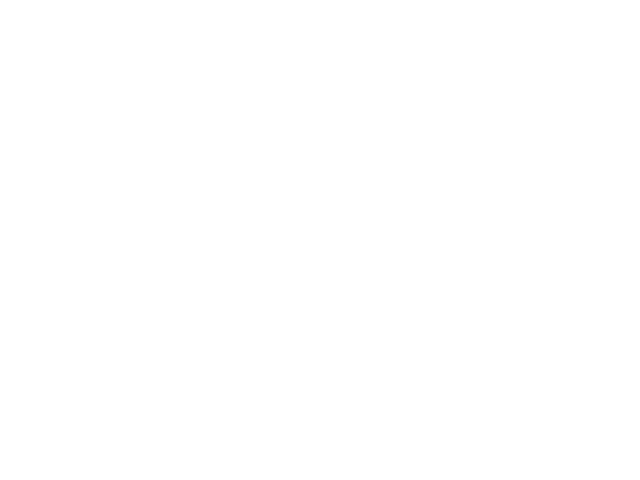

In [147]:
fig = plt.figure()
icutoff = 0
for icutoff in range(3):
    ax = fig.add_subplot(1,3,icutoff+1,projection='3d')
    for s in range(5):
        x = np.cumsum(np.concatenate(((0,),R[k][icutoff][s,:,:,0].mean(1))))
        y = np.cumsum(np.concatenate(((0,),R[k][icutoff][s,:,:,1].mean(1))))
        z = np.cumsum(np.concatenate(((0,),R[k][icutoff][s,:,:,2].mean(1))))
        ax.plot(x,y,z) #,np.cumsum(R[k][icutoff][s,:,:,2].mean(1)))

<IPython.core.display.Javascript object>


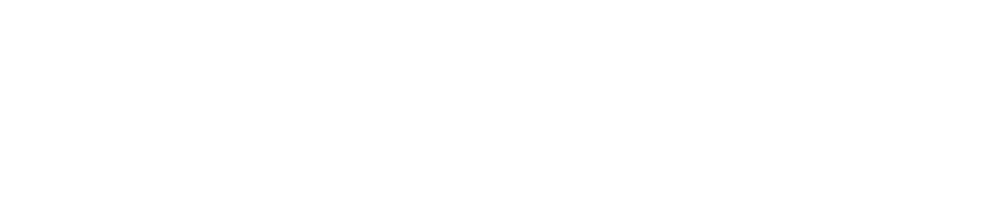

<IPython.core.display.Javascript object>


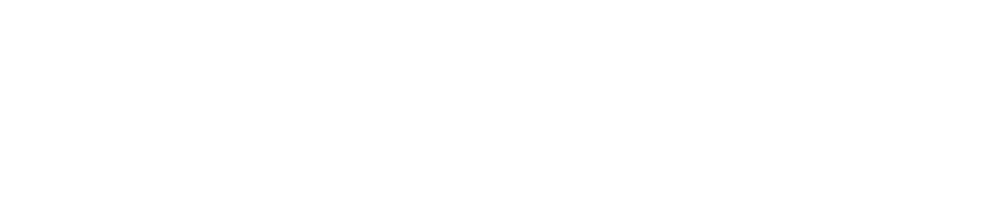

In [180]:
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, 45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s,angle==1)
        ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)   
    
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, -45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s,angle==1)
        ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)

<IPython.core.display.Javascript object>


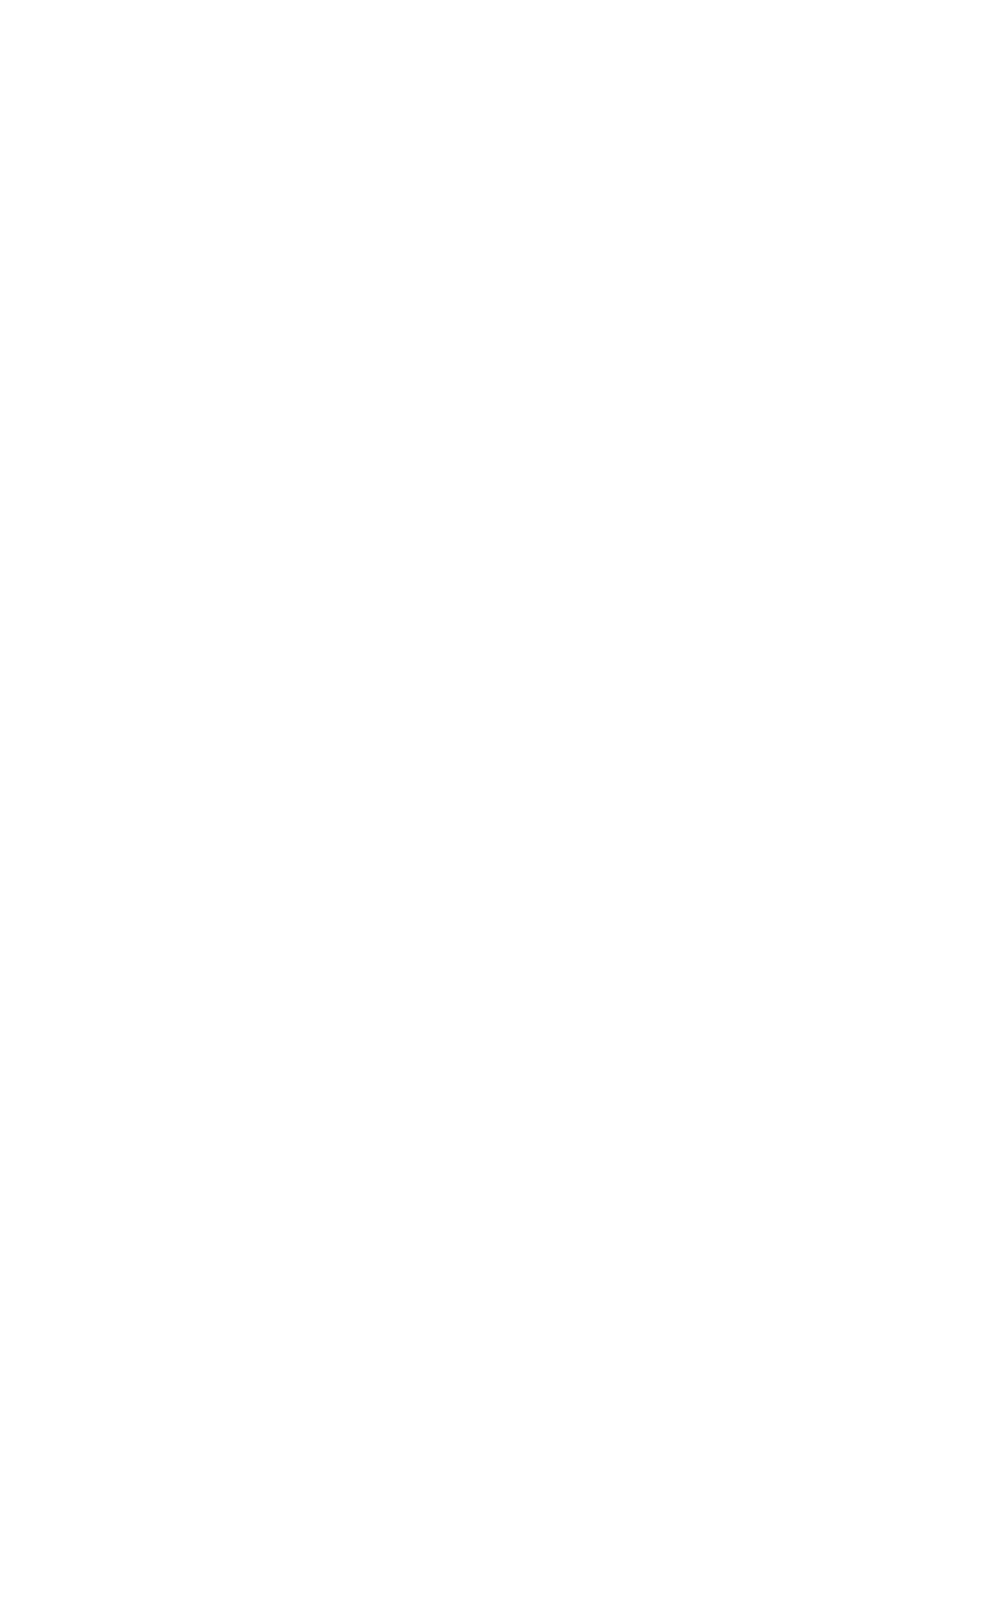

<IPython.core.display.Javascript object>


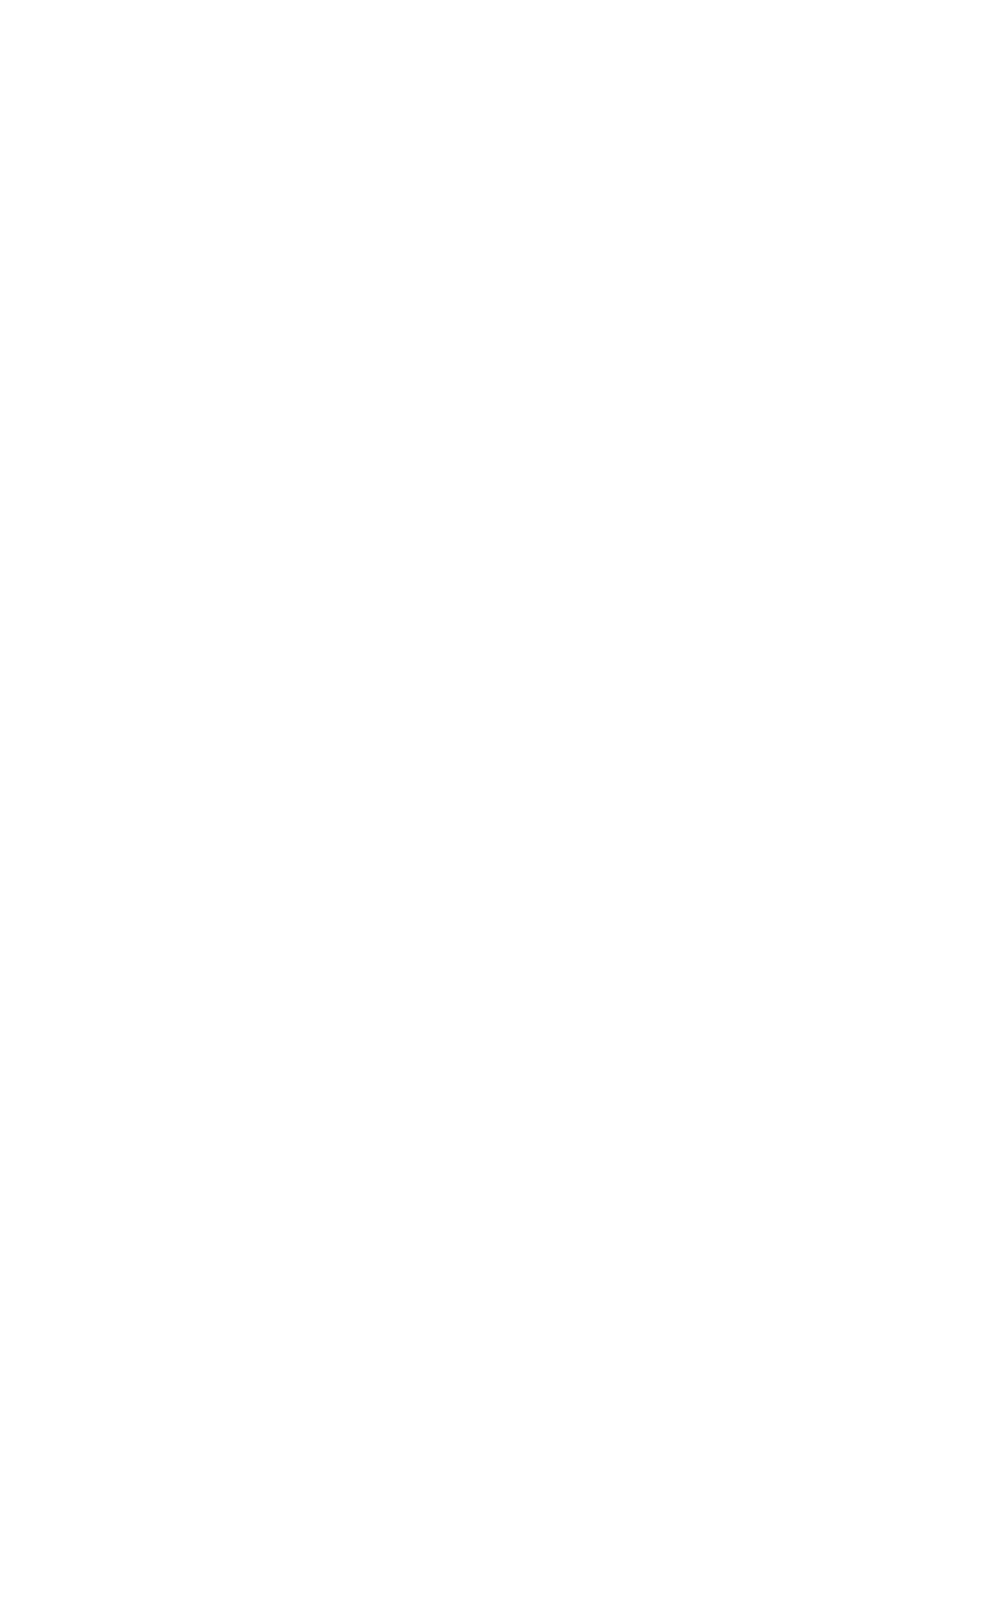

In [182]:
fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1,projection='3d')
        ax.view_init(0, 45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
        ax.axis('off')
        ax.set_xlim(-0.1,0.1)
        ax.set_ylim(-0.1,0.1)
        ax.set_zlim(-0.1,0.1)
    
fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1,projection='3d')
        ax.view_init(0, -45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
        ax.axis('off')
        ax.set_xlim(-0.1,0.1)
        ax.set_ylim(-0.1,0.1)
        ax.set_zlim(-0.1,0.1)

<IPython.core.display.Javascript object>


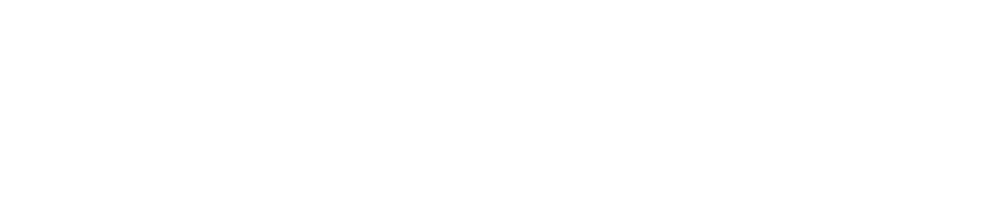

<IPython.core.display.Javascript object>


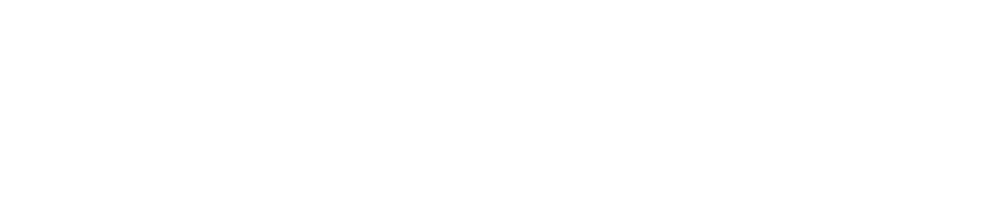

In [174]:
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, 45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s)
        ax.scatter(v[0][lkat],v[1][lkat],v[5][lkat],alpha=0.3)
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)   
    
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, -45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s)
        ax.scatter(v[0][lkat],v[1][lkat],v[7][lkat],alpha=0.3)
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)

<IPython.core.display.Javascript object>


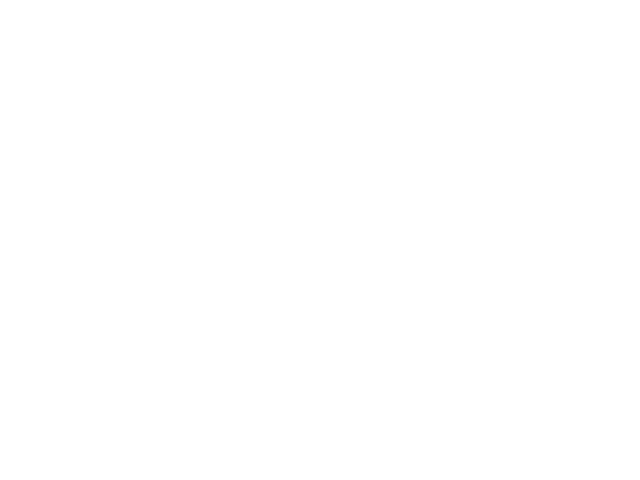

In [140]:
plt.figure()
plt.plot(top_score[k].mean(-1).mean(-1))

<IPython.core.display.Javascript object>


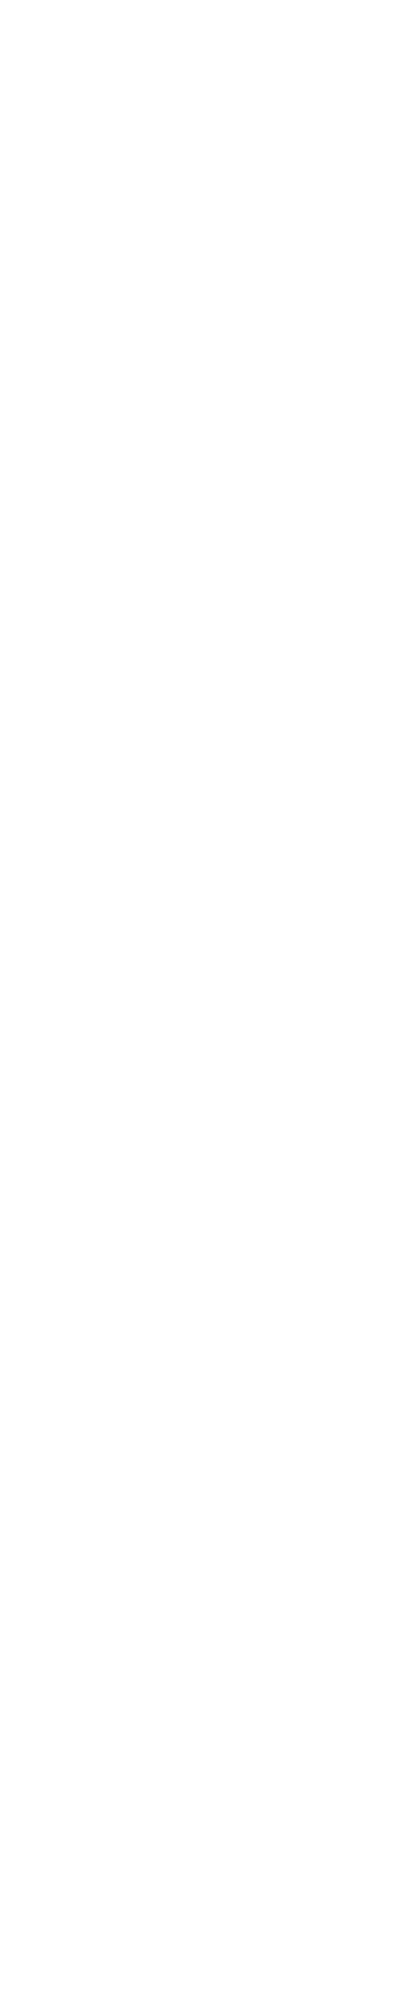

In [186]:
plt.figure(figsize=(4,20))
c = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
N = 8
for s in range(N):
    regression_weight = u[:,s][ontarget_ret_lax]
    plt.subplot(N,1,s+1)
    plt.scatter(distance,regression_weight,s=5)
    binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
    binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
    plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')
#     plt.ylim((-0.03,0.03))

<IPython.core.display.Javascript object>


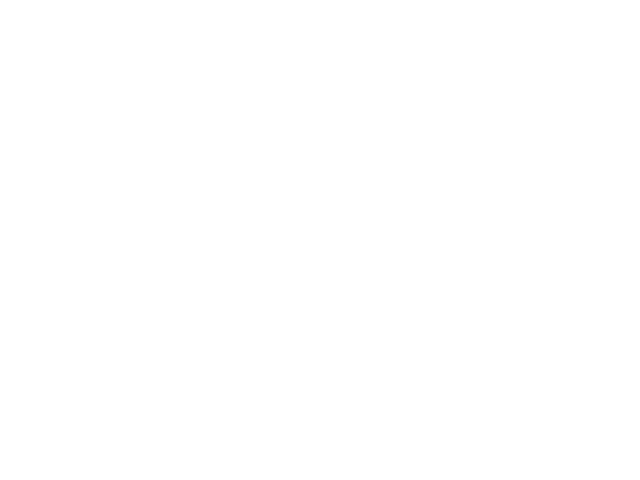

In [191]:
plt.figure()#figsize=(4,20))
c = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
N = 8
regression_weight = -u[:,0][ontarget_ret_lax]+u[:,1][ontarget_ret_lax]
plt.scatter(distance,regression_weight,s=5)
binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')

In [190]:
plt.close('all')

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


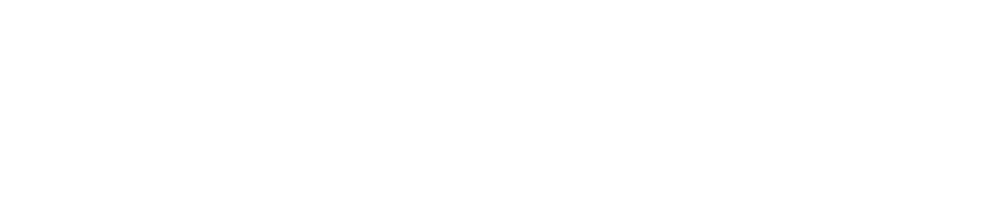

(0, -1, 0, -0.14131621513915571)
(0, -1, 1, -0.56580469777867393)
(0, -1, 2, -3.1790801998459193)
(0, -1, 3, -0.055082341686535294)
(0, -1, 4, -3.432716140156888)
(0, -1, 5, -0.14637389294711239)
(0, -1, 6, -0.38250848510307589)
(0, -1, 7, -7.5152235713676969)
(0, -1, 8, -0.18458627687703452)
(0, -1, 9, -0.14335251856316814)
(0, -1, 10, -0.98991988530837971)
(0, -1, 11, -0.13214756771994168)
(0, -1, 12, -0.12710985631502242)
(0, -1, 13, -0.096234222237991413)
(0, -1, 14, -2.9615713023255386)
(0, -1, 15, -0.10609590049665588)
(0, -1, 16, -0.055008527367877737)
(0, -1, 17, -0.040197957873167801)
(0, -1, 18, -0.079591452874664695)
(0, -1, 19, -0.13852937466400489)
(0, -1, 20, -1.8338878041918539e+30)
(0, -1, 21, -0.07004730277881914)
(0, -1, 22, -4.2026083951196709)
(0, -1, 23, -0.26399891773271972)
(0, -1, 24, -0.098109462006377227)
(0, -1, 25, -0.15987351386876328)
(0, -1, 26, -0.47879023714371893)
(0, -1, 27, -0.077793904011889153)
(0, -1, 28, -0.18861267208517701)
(0, -1, 29, -0.40889

(0, -1, 241, -7.5339184485685022)
(0, -1, 242, -0.079594725938761712)
(0, -1, 243, -0.41207032664311588)
(0, -1, 244, -0.40257569336963561)
(0, -1, 245, -0.62175136248139462)
(0, -1, 246, -0.24067965950134501)
(0, -1, 247, -0.13284924275190796)
(0, -1, 248, -0.24350926524706287)
(0, -1, 249, -0.30357095565490994)
(0, -1, 250, -1.40004877032466)
(0, -1, 251, -0.30369783122982347)
(0, -1, 252, -0.40518203907343986)
(0, -1, 253, -0.12443414973694367)
(0, -1, 254, -0.42864576975956459)
(0, -1, 255, -0.11425195201738617)
(0, -1, 256, -0.53037646141412653)
(0, -1, 257, -0.012856066807057998)
(0, -1, 258, -1.4584652045611612)
(0, -1, 259, -0.023864293538338421)
(0, -1, 260, -0.021644090930227945)
(0, -1, 261, -0.14606766917150982)
(0, -1, 262, -0.13441794294421278)
(0, -1, 263, -0.083740820504093774)
(0, -1, 264, -0.051510010283732331)
(0, -1, 265, -3.5695301015062535)
(0, -1, 266, -0.14100954906222912)
(0, -1, 267, -0.27546681714149174)
(0, -1, 268, -0.39956023459369244)
(0, -1, 269, -0.0560

(0, -1, 490, -0.039806455688809715)
(0, -1, 491, -0.087567171671388402)
(0, -1, 492, -0.48410270178754899)
(0, -1, 493, -0.30372913073157443)
(0, -1, 494, -0.044519802934537257)
(0, -1, 495, -0.38557713487577139)
(0, -1, 496, -0.061986599197935498)
(0, -1, 497, -0.18384286900017671)
(0, -1, 498, -0.27262058351158458)
(0, -1, 499, -0.16432366833618828)
(0, -1, 500, -2.296880296884356)
(0, -1, 501, -0.078451792112141344)
(0, -1, 502, -0.080754776262840222)
(0, -1, 503, -0.25611576289198634)
(0, -1, 504, -0.1493466749492886)
(0, -1, 505, -0.12460691015388822)
(0, -1, 506, -0.031390732033332577)
(0, -1, 507, -0.08991501442777558)
(0, -1, 508, -0.42927474325974269)
(0, -1, 509, -0.14556251761795144)
(0, -1, 510, -0.2735349836664554)
(0, -1, 511, -0.14153174466420651)
(0, -1, 512, -0.40326381720533622)
(0, -1, 513, -0.47785703637465787)
(0, -1, 514, -0.3714375278914403)
(0, -1, 515, -70.476725063244075)
(0, -1, 516, -0.075240278731573421)
(0, -1, 517, -31.653091405687395)
(0, -1, 518, -0.174

(0, -1, 743, -0.15677630156303485)
(0, -1, 744, -0.083215365276523942)
(0, -1, 745, -0.16706957393287664)
(0, -1, 746, -0.14072477560192662)
(0, -1, 747, -0.1193630177694824)
(0, -1, 748, -0.180420251842698)
(0, -1, 749, -0.081776519091574879)
(0, -1, 750, -0.13527397177366834)
(0, -1, 751, -0.31696668169286063)
(0, -1, 752, -0.11718320272241693)
(0, -1, 753, -0.1042667581186085)
(0, -1, 754, -0.20772435720442156)
(0, -1, 755, -0.85107354284568582)
(0, -1, 756, -0.14239026730870727)
(0, -1, 757, -0.045507131368026456)
(0, -1, 758, -0.24851658427295456)
(0, -1, 759, -1.0629304493115579)
(0, -1, 760, -0.067921188796975701)
(0, -1, 761, -1.1460636847664232)
(0, -1, 762, -0.071059037263178929)
(0, -1, 763, -0.1458196102953658)
(0, -1, 764, -0.91488549162585464)
(0, -1, 765, -0.19379326889596127)
(0, -1, 766, -0.32248503132883677)
(0, -1, 767, -0.32390052344128151)
(0, -1, 768, -0.18140144482170434)
(0, -1, 769, -0.0098025753779223956)
(0, -1, 770, -0.13432631201792983)
(0, -1, 771, -0.2892

(0, -1, 987, -0.096586476492565423)
(0, -1, 988, -0.12352781131625161)
(0, -1, 989, -0.28596036451181578)
(0, -1, 990, -0.079027977474541072)
(0, -1, 991, -0.16233931645104577)
(0, -1, 992, -0.24848153361084488)
(0, -1, 993, -0.89379610449850744)
(0, -1, 994, -0.13761273521340639)
(0, -1, 995, -0.31551211783897254)
(0, -1, 996, -4.6872513735569452)
(0, -1, 997, -0.48997752746238082)
(0, -1, 998, -1.721479664408492)
(0, -1, 999, -0.89877578020554727)
(0, -1, 1000, -1.7017476950822936)
(0, -1, 1001, -0.953260563845992)
(0, -1, 1002, -0.2518608759100272)
(0, -1, 1003, -0.24135357731344284)
(0, -1, 1004, -0.57387080336703977)
(0, -1, 1005, -2.0162324069483422)
(0, -1, 1006, -0.095925436909340508)
(0, -1, 1007, -0.037735322216532127)
(0, -1, 1008, 0.042755926423911204)
(0, -1, 1009, -0.42321849616028351)
(0, -1, 1010, -1.5881531315997015)
(0, -1, 1011, -0.39806112371079622)
(0, -1, 1012, -0.24795184087389383)
(0, -1, 1013, -0.09784768217919268)
(0, -1, 1014, -0.080005745273059828)
(0, -1, 1

(0, -1, 1218, -0.060852892165517494)
(0, -1, 1219, -1.6400368079137508)
(0, -1, 1220, -0.069054521094812124)
(0, -1, 1221, -0.13322850838957964)
(0, -1, 1222, -0.42616798500034703)
(0, -1, 1223, -2.1652137206928437)
(0, -1, 1224, -0.14180914560731009)
(0, -1, 1225, -0.4771671804902054)
(0, -1, 1226, -0.21583973785115793)
(0, -1, 1227, -0.38009382165821454)
(50, 0, 0, array([[ -6.65297275e-01,  -1.07936902e-01,  -2.57890952e-03, ...,
         -9.97884372e-03,   4.26799997e-03,  -9.21794892e-02],
       [  4.95283309e-02,  -5.78249928e-01,  -1.76734736e-01, ...,
         -4.64116400e-01,  -3.17585704e+00,  -1.65739159e-01],
       [ -2.81639320e-01,  -1.93915359e-02,  -6.14471670e-02, ...,
         -1.87643426e-02,  -3.97417542e-01,  -7.55428109e-02],
       ..., 
       [ -1.34553902e-02,  -3.07413143e-02,  -4.65421664e-02, ...,
         -1.23483097e-02,  -1.27064553e-01,   0.00000000e+00],
       [ -7.81115039e-02,  -5.63017995e-02,  -1.33917887e-02, ...,
         -5.86268666e-02,   3.

(1, -1, 206, -0.26220928930130877)
(1, -1, 207, -0.420701424979878)
(1, -1, 208, -0.23921230921591433)
(1, -1, 209, -3.1621502777208805)
(1, -1, 210, -1.1492703095618801)
(1, -1, 211, -0.17381163789331505)
(1, -1, 212, -0.13348073635764993)
(1, -1, 213, -1.1192783149091488)
(1, -1, 214, -0.034128876935415706)
(1, -1, 215, -0.11655836048552667)
(1, -1, 216, -1.3393927544705011)
(1, -1, 217, -0.22377909890423506)
(1, -1, 218, -0.22545501525977482)
(1, -1, 219, -0.161500019031799)
(1, -1, 220, -0.48342254577220212)
(1, -1, 221, -0.13790449564398455)
(1, -1, 222, -0.034866397425844783)
(1, -1, 223, -0.32041839368794522)
(1, -1, 224, -0.2287994066871728)
(1, -1, 225, -3.2830124416238697)
(1, -1, 226, -2.8257833772842904)
(1, -1, 227, -0.75461859637579365)
(1, -1, 228, -0.21570872225278745)
(1, -1, 229, -0.68154063338409987)
(1, -1, 230, -0.017517514811788558)
(1, -1, 231, -0.3408899872783121)
(1, -1, 232, -0.083217407735522969)
(1, -1, 233, -0.26475766996088995)
(1, -1, 234, -0.163769093901

(1, -1, 446, -0.045024511045017888)
(1, -1, 447, -0.41871452336566078)
(1, -1, 448, -0.59690876802453441)
(1, -1, 449, -16.462991217547227)
(1, -1, 450, -0.082098009734902139)
(1, -1, 451, -0.089638564180023556)
(1, -1, 452, -0.19127223015339895)
(1, -1, 453, -0.26183968773608157)
(1, -1, 454, -0.13293708918457986)
(1, -1, 455, -0.15702335851266849)
(1, -1, 456, -0.057168846412299065)
(1, -1, 457, -1.9431505973134495)
(1, -1, 458, -0.17635344385595703)
(1, -1, 459, -0.045294805131389879)
(1, -1, 460, -0.38069348555028892)
(1, -1, 461, -0.11839427984436779)
(1, -1, 462, -0.093242889406940366)
(1, -1, 463, -0.073563230980480065)
(1, -1, 464, -0.44915756998756773)
(1, -1, 465, -0.15523837341565655)
(1, -1, 466, -0.087290519364876945)
(1, -1, 467, -0.039621396345801217)
(1, -1, 468, -0.04256536792156114)
(1, -1, 469, -0.34457641940915246)
(1, -1, 470, -0.36165667717023336)
(1, -1, 471, -0.078280327558679488)
(1, -1, 472, -0.060362773030391184)
(1, -1, 473, -1.6276270380158269)
(1, -1, 474,

(1, -1, 681, -0.18646884372796335)
(1, -1, 682, -6.6868218917511699)
(1, -1, 683, -0.20869027747245755)
(1, -1, 684, -0.18830132284848161)
(1, -1, 685, -0.3359202823728028)
(1, -1, 686, -0.7223527836257031)
(1, -1, 687, -0.26986334662146721)
(1, -1, 688, -0.33279955263881245)
(1, -1, 689, -0.32906641667789338)
(1, -1, 690, -0.29258740376501402)
(1, -1, 691, -0.066339233661359395)
(1, -1, 692, -0.79390071363813186)
(1, -1, 693, -0.18808375044788136)
(1, -1, 694, -0.65747800595583539)
(1, -1, 695, -0.16641842629281794)
(1, -1, 696, -0.20062434495810347)
(1, -1, 697, -1.297908212250763)
(1, -1, 698, -0.519690742045396)
(1, -1, 699, -0.040178291206831696)
(1, -1, 700, -0.010931521898020113)
(1, -1, 701, -3.7870468891697309)
(1, -1, 702, -1.0358501450134068)
(1, -1, 703, -0.070920358659779595)
(1, -1, 704, -0.0040690334767787941)
(1, -1, 705, -0.058350190987902895)
(1, -1, 706, -0.25427027105273908)
(1, -1, 707, -0.012205952491741034)
(1, -1, 708, -0.095424855401522929)
(1, -1, 709, -0.0747

(1, -1, 925, -2.0743282056693411)
(1, -1, 926, -0.19114400926400971)
(1, -1, 927, -0.11598996435852235)
(1, -1, 928, -1.2417267181387721)
(1, -1, 929, -0.13434753945809233)
(1, -1, 930, -0.39863554783502853)
(1, -1, 931, -3.9676702769657992)
(1, -1, 932, -0.053878499256185007)
(1, -1, 933, -0.038897713606045728)
(1, -1, 934, -0.2783194373258151)
(1, -1, 935, -0.097836097977025388)
(1, -1, 936, -0.22484799197806088)
(1, -1, 937, -1.5718800396383181)
(1, -1, 938, -0.1035085100329374)
(1, -1, 939, -0.07280731480245943)
(1, -1, 940, -0.23169719542867498)
(1, -1, 941, -0.10889527087945065)
(1, -1, 942, -0.050372059553302095)
(1, -1, 943, -0.097626915247581422)
(1, -1, 944, -0.023548206103137438)
(1, -1, 945, -0.28989848807186192)
(1, -1, 946, -0.082599264110699663)
(1, -1, 947, -0.16396098856158731)
(1, -1, 948, -0.1292601903822794)
(1, -1, 949, -0.2845531888354082)
(1, -1, 950, -0.24005611901600502)
(1, -1, 951, -0.083294232492174741)
(1, -1, 952, -0.54807857733537246)
(1, -1, 953, -0.9106

(1, -1, 1169, -0.10158515716338452)
(1, -1, 1170, -0.083078325401132441)
(1, -1, 1171, -0.35867283500974317)
(1, -1, 1172, -0.91631610769571348)
(1, -1, 1173, -0.55152320449462455)
(1, -1, 1174, -0.33193286032439073)
(1, -1, 1175, -0.88994756269281883)
(1, -1, 1176, -0.13636582647011686)
(1, -1, 1177, -0.20096361404287544)
(1, -1, 1178, -0.026355773500567291)
(1, -1, 1179, -0.54683927774658103)
(1, -1, 1180, -0.03854524882616369)
(1, -1, 1181, -9.147911523880007e+30)
(1, -1, 1182, -0.63455258785120705)
(1, -1, 1183, -0.073689460920599414)
(1, -1, 1184, -0.074307822238154214)
(1, -1, 1185, -7.0290533871868899)
(1, -1, 1186, -0.42031115289967086)
(1, -1, 1187, -2.1865842213397384)
(1, -1, 1188, -0.37196956796498193)
(1, -1, 1189, -1.8903558357182999)
(1, -1, 1190, -0.26310976231079619)
(1, -1, 1191, -0.18078159764286625)
(1, -1, 1192, -0.27280359018407802)
(1, -1, 1193, -0.17996446988641188)
(1, -1, 1194, -0.055012716153745277)
(1, -1, 1195, -0.46090751686709142)
(1, -1, 1196, -0.0598352

(2, -1, 170, -0.24902915469269615)
(2, -1, 171, -0.61013920535203336)
(2, -1, 172, -0.65381757697402876)
(2, -1, 173, -0.016205888218053344)
(2, -1, 174, -0.18650044216290979)
(2, -1, 175, -0.11629919815166334)
(2, -1, 176, -0.0875400660008612)
(2, -1, 177, -0.17394591921718311)
(2, -1, 178, -0.13471287910920743)
(2, -1, 179, -0.10440296768062578)
(2, -1, 180, -0.30009480399405752)
(2, -1, 181, -0.32972130175575842)
(2, -1, 182, -0.18397145254339836)
(2, -1, 183, -0.26489512452249658)
(2, -1, 184, -0.080233748612784289)
(2, -1, 185, -0.25457159692273723)
(2, -1, 186, -0.092036234872423558)
(2, -1, 187, -0.52422040725387531)
(2, -1, 188, -0.30141315728136064)
(2, -1, 189, -0.36291743193491699)
(2, -1, 190, -0.14847395822967796)
(2, -1, 191, -0.12657374060192622)
(2, -1, 192, -0.19128262475588814)
(2, -1, 193, -0.24024634891886981)
(2, -1, 194, -0.036798827788736402)
(2, -1, 195, -0.47325485695943997)
(2, -1, 196, -0.11806130745851758)
(2, -1, 197, -0.14854012545782658)
(2, -1, 198, -0.1

(2, -1, 410, -0.17540008162908061)
(2, -1, 411, -0.058404310246936195)
(2, -1, 412, -0.3889267890899199)
(2, -1, 413, -0.025191039981745635)
(2, -1, 414, -0.016782025375152432)
(2, -1, 415, -2.0756448326997736)
(2, -1, 416, -0.13364056605645508)
(2, -1, 417, -0.035595719132675986)
(2, -1, 418, -0.060790722460334234)
(2, -1, 419, -0.085407532033204683)
(2, -1, 420, -0.1433843884912232)
(2, -1, 421, -0.88056744112599517)
(2, -1, 422, -0.054085376590147297)
(2, -1, 423, -0.25336900557969877)
(2, -1, 424, -0.09789179252252353)
(2, -1, 425, -0.40972364298626829)
(2, -1, 426, -0.11594179852892628)
(2, -1, 427, -0.37456945428102628)
(2, -1, 428, -0.13754178209771545)
(2, -1, 429, -0.1743549272812932)
(2, -1, 430, -2.8517947564071604)
(2, -1, 431, -0.095930671110635829)
(2, -1, 432, -0.18560609650886067)
(2, -1, 433, -0.11540018544804172)
(2, -1, 434, -1.5359136578057959)
(2, -1, 435, -0.08710131478012402)
(2, -1, 436, -0.17290305438399722)
(2, -1, 437, -0.52016885528817969)
(2, -1, 438, -0.28

(2, -1, 656, -0.073411201433152565)
(2, -1, 657, -0.18918438230391724)
(2, -1, 658, -0.11777858286349059)
(2, -1, 659, -0.28250277277365132)
(2, -1, 660, -0.13017313213316023)
(2, -1, 661, -0.29910004598982348)
(2, -1, 662, -0.29303846139645956)
(2, -1, 663, -0.062622549016842)
(2, -1, 664, -0.088045675551329611)
(2, -1, 665, -0.042101963783904094)
(2, -1, 666, -0.027703616246754915)
(2, -1, 667, -0.098834836890888428)
(2, -1, 668, -0.10669419485861191)
(2, -1, 669, -0.57468398308795954)
(2, -1, 670, -0.19482611037818295)
(2, -1, 671, -0.072594989666573961)
(2, -1, 672, -3.8412055021418197)
(2, -1, 673, -0.33947855317781372)
(2, -1, 674, -0.69388679211080662)
(2, -1, 675, -0.32698437395873603)
(2, -1, 676, -0.33057819258793542)
(2, -1, 677, -0.038894389916643568)
(2, -1, 678, -0.18715914655821875)
(2, -1, 679, -1.431553603308849)
(2, -1, 680, -0.40908254330500887)
(2, -1, 681, -9.2650386524236303)
(2, -1, 682, -2.6140976525097179)
(2, -1, 683, -0.13390270814081312)
(2, -1, 684, -0.0293

(2, -1, 921, -8.1289732968956194)
(2, -1, 922, -0.19298940898165864)
(2, -1, 923, -2.3619492882504316)
(2, -1, 924, 0.13144258914396406)
(2, -1, 925, -0.079761884204205297)
(2, -1, 926, -0.66673651711092718)
(2, -1, 927, -0.27660746724224106)
(2, -1, 928, -0.90238408150759253)
(2, -1, 929, -0.18000430174568158)
(2, -1, 930, -0.4672546271755772)
(2, -1, 931, -5.7624064179573571)
(2, -1, 932, -0.13231756471460779)
(2, -1, 933, -0.88855925325142715)
(2, -1, 934, -0.76324355230774721)
(2, -1, 935, -0.15583751889972389)
(2, -1, 936, -0.13726733058715837)
(2, -1, 937, -0.38706008712801226)
(2, -1, 938, -0.067706593832219414)
(2, -1, 939, -0.041616140674270018)
(2, -1, 940, -0.054653937368530012)
(2, -1, 941, -1.4792544149202207)
(2, -1, 942, -0.13677240199032251)
(2, -1, 943, -0.85335792857455472)
(2, -1, 944, -0.028777447689579592)
(2, -1, 945, -2.6654794143240044)
(2, -1, 946, -0.08598264773742012)
(2, -1, 947, -2.4198054531547752)
(2, -1, 948, -1.5124375758176167)
(2, -1, 949, -0.30075648

(2, -1, 1166, -0.067767441062405495)
(2, -1, 1167, -0.10230389365149528)
(2, -1, 1168, -0.36464650402195098)
(2, -1, 1169, -0.96018796593454403)
(2, -1, 1170, -0.17507960975375031)
(2, -1, 1171, -0.85003050882450792)
(2, -1, 1172, 0.10351442122712975)
(2, -1, 1173, -0.030766639074923229)
(2, -1, 1174, -0.10508221726150428)
(2, -1, 1175, -0.098771322527869049)
(2, -1, 1176, -0.25582532290903448)
(2, -1, 1177, 0.13293742908652545)
(2, -1, 1178, -0.15421390402802398)
(2, -1, 1179, -0.062915553517600725)
(2, -1, 1180, 0.032680674557750158)
(2, -1, 1181, -0.8762260670589288)
(2, -1, 1182, -0.43900398638563259)
(2, -1, 1183, -0.12221770425472926)
(2, -1, 1184, -0.37431620187460019)
(2, -1, 1185, -2.1167786361415435)
(2, -1, 1186, 0.069469798124278087)
(2, -1, 1187, -2.1527639276306294)
(2, -1, 1188, -0.3597615702624426)
(2, -1, 1189, -0.11483594074562795)
(2, -1, 1190, -0.43779830312806656)
(2, -1, 1191, -0.19330979396485701)
(2, -1, 1192, -5.9509080443209772)
(2, -1, 1193, -0.20246058724092

(0, 0, 181, -0.59345169891395011)
(0, 0, 182, -6.1174787270010853)
(0, 0, 183, -0.11249377318638695)
(0, 0, 184, -0.49802313647684276)
(0, 0, 185, -0.80551533111162266)
(0, 0, 186, -0.18784849093795356)
(0, 0, 187, -0.93454235349282722)
(0, 0, 188, -0.071182144844977563)
(0, 0, 189, -0.49902549246855959)
(0, 0, 190, -0.11973276436485487)
(0, 0, 191, -4.4972797630690184)
(0, 0, 192, -0.47167442419880351)
(0, 0, 193, -0.68651843211897035)
(0, 0, 194, -0.83609503705088795)
(0, 0, 195, -0.3283615690332311)
(0, 0, 196, -0.18282458801145013)
(0, 0, 197, -0.28020256764212148)
(0, 0, 198, -1.414232515779084)
(0, 0, 199, -0.16397835255338583)
(0, 0, 200, -4.719127703456099)
(0, 0, 201, -0.095400469761492163)
(0, 0, 202, -0.1009963037682009)
(0, 0, 203, -2.3987273877832958)
(0, 0, 204, -0.42327840709243458)
(0, 0, 205, -0.42785000903728088)
(0, 0, 206, -0.40284279489591579)
(0, 0, 207, -2.0308495524350128)
(0, 0, 208, -1.7270169568687304)
(0, 0, 209, -0.2438436206789604)
(0, 0, 210, -0.024764234

(0, 0, 423, 0.14030514631729993)
(0, 0, 424, -0.10759513473818724)
(0, 0, 425, -0.3925780432901515)
(0, 0, 426, -0.14677364877541937)
(0, 0, 427, -0.46666230827494204)
(0, 0, 428, -0.04066232152151892)
(0, 0, 429, -0.079265484986157722)
(0, 0, 430, -3.7398189236845569)
(0, 0, 431, -0.18155822468089916)
(0, 0, 432, -0.22107362637556616)
(0, 0, 433, -0.17943709113307621)
(0, 0, 434, -1.1564173235371573)
(0, 0, 435, -0.1334631313100256)
(0, 0, 436, -0.14305923543643639)
(0, 0, 437, -0.3441530397586976)
(0, 0, 438, -0.18594385502927002)
(0, 0, 439, -0.060058216825687107)
(0, 0, 440, -0.40688725738775061)
(0, 0, 441, -0.43375691483965417)
(0, 0, 442, -0.25862118721799549)
(0, 0, 443, -0.040671782207127215)
(0, 0, 444, -0.5256024860306503)
(0, 0, 445, -1.7114954044726385)
(0, 0, 446, -0.082001455040779825)
(0, 0, 447, -0.10592570186012087)
(0, 0, 448, -0.068118250224789081)
(0, 0, 449, -0.27082235413086003)
(0, 0, 450, -0.040759994496472697)
(0, 0, 451, -0.18063447699695856)
(0, 0, 452, -0.3

(0, 0, 680, -0.32445799957880783)
(0, 0, 681, -0.032254230798868709)
(0, 0, 682, -6.3705495474762168)
(0, 0, 683, -0.14322957350763005)
(0, 0, 684, -0.031003744542470069)
(0, 0, 685, -0.26572987900874923)
(0, 0, 686, -0.14322190187352293)
(0, 0, 687, -0.07903445072194)
(0, 0, 688, -0.21086392568204518)
(0, 0, 689, -0.50256552637805163)
(0, 0, 690, -0.13759643942945907)
(0, 0, 691, -0.19420146709552016)
(0, 0, 692, -1.3459459932033007)
(0, 0, 693, -0.48959064330708335)
(0, 0, 694, -0.14654069462010635)
(0, 0, 695, -0.57872552664452548)
(0, 0, 696, -0.36612319316597824)
(0, 0, 697, -0.31173881645233176)
(0, 0, 698, -0.25632043689782408)
(0, 0, 699, -0.29680899893740847)
(0, 0, 700, -1.8973314997374242)
(0, 0, 701, -0.33165488982738445)
(0, 0, 702, 0.0010671894546962601)
(0, 0, 703, -0.11982202425846149)
(0, 0, 704, -0.1422681514983033)
(0, 0, 705, -0.12417616146005776)
(0, 0, 706, -0.23394495635935489)
(0, 0, 707, -0.13589756954866056)
(0, 0, 708, -0.3465238128601707)
(0, 0, 709, -0.0931

(0, 0, 943, -0.075095380919330393)
(0, 0, 944, -0.03167398208027368)
(0, 0, 945, -1.2304735752412088)
(0, 0, 946, -0.32385738758482835)
(0, 0, 947, -1.1771023740106608)
(0, 0, 948, -0.018867861592718627)
(0, 0, 949, -0.073162415371553546)
(0, 0, 950, -0.26627477816466588)
(0, 0, 951, -0.062006836651011601)
(0, 0, 952, -0.45350161130998901)
(0, 0, 953, -0.12280997826356962)
(0, 0, 954, -0.25498639821715313)
(0, 0, 955, -0.20761127759609188)
(0, 0, 956, -3.1148060887443394e+28)
(0, 0, 957, -0.014696984492292054)
(0, 0, 958, -0.039427693573302225)
(0, 0, 959, -0.066339826854925885)
(0, 0, 960, -0.20125946933826003)
(0, 0, 961, -1.0769358879618987e+29)
(0, 0, 962, -0.072378349460071031)
(0, 0, 963, -0.56794938360967218)
(0, 0, 964, -0.026585733336298933)
(0, 0, 965, -0.98258980575785437)
(0, 0, 966, -0.65367026958624475)
(0, 0, 967, -0.039231527686678834)
(0, 0, 968, -0.11951005357558231)
(0, 0, 969, -0.16347318487637749)
(0, 0, 970, -0.32553535907144088)
(0, 0, 971, -0.15669118881948918)


(0, 0, 1190, -0.062390798686328505)
(0, 0, 1191, -0.15298159908825251)
(0, 0, 1192, -3.1922481181848332)
(0, 0, 1193, -0.14652854778039406)
(0, 0, 1194, -0.042905364211672833)
(0, 0, 1195, 0.00024819545860826908)
(0, 0, 1196, -0.025288834029967212)
(0, 0, 1197, -2.78087999654577)
(0, 0, 1198, -0.28552628278824288)
(0, 0, 1199, -0.08335727139171209)
(0, 0, 1200, -0.13508116263061137)
(0, 0, 1201, -0.054207934454758799)
(0, 0, 1202, -0.11348876740462141)
(0, 0, 1203, -0.05772284183318236)
(0, 0, 1204, -0.050659530915950254)
(0, 0, 1205, -0.79879157003562107)
(0, 0, 1206, -0.042225680938798783)
(0, 0, 1207, -0.085061092208194508)
(0, 0, 1208, -0.020166854962200421)
(0, 0, 1209, -0.050843001201225937)
(0, 0, 1210, -0.033668811688789144)
(0, 0, 1211, -0.49284616802955161)
(0, 0, 1212, -1.6359320008293452)
(0, 0, 1213, -0.1243986920491132)
(0, 0, 1214, -1.0608663768000597)
(0, 0, 1215, -0.11069906158373063)
(0, 0, 1216, -0.049350187527205637)
(0, 0, 1217, -2.0575643918303439)
(0, 0, 1218, -0

(1, 0, 215, -0.28999977668775817)
(1, 0, 216, -1.8969995139788296)
(1, 0, 217, -0.3351270551255312)
(1, 0, 218, -0.27584118484582543)
(1, 0, 219, -0.19601835359784842)
(1, 0, 220, -0.71753915459068174)
(1, 0, 221, -0.086848007170355859)
(1, 0, 222, -0.051247183961772955)
(1, 0, 223, -0.78902078226536398)
(1, 0, 224, -0.43176742681352787)
(1, 0, 225, -0.43369377191009661)
(1, 0, 226, -0.38069521524449468)
(1, 0, 227, -0.098791343313141253)
(1, 0, 228, -1.7728141380216882)
(1, 0, 229, -1.7007747785965961)
(1, 0, 230, -0.23883239084408783)
(1, 0, 231, -7.1893623944686684)
(1, 0, 232, -0.10221862996850081)
(1, 0, 233, -0.035526402342839845)
(1, 0, 234, -0.13355495310853571)
(1, 0, 235, -0.35822672581862686)
(1, 0, 236, -0.46756686082951215)
(1, 0, 237, -2.2452321323355249)
(1, 0, 238, -0.11992158755641194)
(1, 0, 239, -0.063237889554349738)
(1, 0, 240, -0.061353901094595563)
(1, 0, 241, -0.23605803107375983)
(1, 0, 242, -0.13715017630035148)
(1, 0, 243, -0.25238073453837989)
(1, 0, 244, -0

(1, 0, 463, -0.090435824882778626)
(1, 0, 464, -1.0257619957413124)
(1, 0, 465, -0.06205123494578909)
(1, 0, 466, -1.5848414569209546)
(1, 0, 467, -0.13947585490283887)
(1, 0, 468, -0.074542890412337345)
(1, 0, 469, -16.980427487701736)
(1, 0, 470, -0.28386873360317944)
(1, 0, 471, -0.61083292016984958)
(1, 0, 472, -0.11982388585935062)
(1, 0, 473, -0.25818419225255684)
(1, 0, 474, -0.22350213331169794)
(1, 0, 475, -12.422451723812937)
(1, 0, 476, -0.40764119594021808)
(1, 0, 477, -0.18182418639748654)
(1, 0, 478, -0.052756414401484285)
(1, 0, 479, -0.26826980514383364)
(1, 0, 480, -0.20404758771971809)
(1, 0, 481, -1.8501933776029411)
(1, 0, 482, -0.12961061541021085)
(1, 0, 483, -0.33999356031838907)
(1, 0, 484, -0.62280861064692261)
(1, 0, 485, -0.045533282817449672)
(1, 0, 486, -0.21263975222405893)
(1, 0, 487, -1.0279467518079453)
(1, 0, 488, -0.057926252020116017)
(1, 0, 489, -0.14202113942758082)
(1, 0, 490, -0.093567531338101251)
(1, 0, 491, -0.10015792149273779)
(1, 0, 492, -0

(1, 0, 707, -0.10759547162628742)
(1, 0, 708, -0.11232641168973483)
(1, 0, 709, -0.01488961416047202)
(1, 0, 710, -0.15264130189115249)
(1, 0, 711, -0.3432039982275592)
(1, 0, 712, -8.4189925758986899)
(1, 0, 713, -0.71046582770787348)
(1, 0, 714, -0.06607959800182886)
(1, 0, 715, -0.08636237645402442)
(1, 0, 716, -0.12257438888217591)
(1, 0, 717, -0.14880805086094911)
(1, 0, 718, -0.12583667361224021)
(1, 0, 719, -0.25041561787913891)
(1, 0, 720, 0.21751011303817674)
(1, 0, 721, -0.40428835364057891)
(1, 0, 722, -0.24306275310820177)
(1, 0, 723, -0.59591311393073265)
(1, 0, 724, -0.22677424628169024)
(1, 0, 725, -0.2880299574478869)
(1, 0, 726, -0.11721068881217089)
(1, 0, 727, -0.15925469656769325)
(1, 0, 728, -0.8799099724815862)
(1, 0, 729, -0.07910031982489954)
(1, 0, 730, -0.064062308440416049)
(1, 0, 731, -0.085347893974090497)
(1, 0, 732, -0.12976160757133196)
(1, 0, 733, -3.4069579392644123)
(1, 0, 734, -1.7536477133537112)
(1, 0, 735, -0.089514036242629991)
(1, 0, 736, -0.182

(1, 0, 957, -0.065366499533696956)
(1, 0, 958, -0.11699631713443752)
(1, 0, 959, -0.069754582442627569)
(1, 0, 960, -0.13655515142410979)
(1, 0, 961, -0.023978175678363679)
(1, 0, 962, -0.10275309010655106)
(1, 0, 963, -987.70280848619245)
(1, 0, 964, 0.10795490902437019)
(1, 0, 965, 0.037915432708207131)
(1, 0, 966, -0.45989526168257144)
(1, 0, 967, -0.31793114039763343)
(1, 0, 968, -0.57745776693314732)
(1, 0, 969, -0.084559823710562171)
(1, 0, 970, -0.056914009303332666)
(1, 0, 971, -0.055290544040100517)
(1, 0, 972, -0.2078860293753611)
(1, 0, 973, -0.41427563121913885)
(1, 0, 974, -0.058826858934430314)
(1, 0, 975, 0.11476215937647768)
(1, 0, 976, -3.0685179478966211)
(1, 0, 977, -0.077528285730406821)
(1, 0, 978, -1.0974194295483477)
(1, 0, 979, -0.097054750375080837)
(1, 0, 980, -0.34918822348275153)
(1, 0, 981, -0.4582569233160475)
(1, 0, 982, -1.1973238155100296)
(1, 0, 983, -0.13406927544973729)
(1, 0, 984, -0.16609806170535582)
(1, 0, 985, -0.11073081608572181)
(1, 0, 986, -

(1, 0, 1200, 0.0024688945348131262)
(1, 0, 1201, -2.9713424777945208)
(1, 0, 1202, -0.71988991200423702)
(1, 0, 1203, -3.2635591594026052)
(1, 0, 1204, -0.0056823076675824981)
(1, 0, 1205, -1.1689299842634431)
(1, 0, 1206, -0.097054424303145315)
(1, 0, 1207, -0.55811924395976598)
(1, 0, 1208, -0.13732133994459661)
(1, 0, 1209, -0.23692907656507406)
(1, 0, 1210, -0.083843072227774193)
(1, 0, 1211, -0.33830257669299701)
(1, 0, 1212, -1.9602768801203063)
(1, 0, 1213, -0.13412718873490498)
(1, 0, 1214, -0.419738571301777)
(1, 0, 1215, -0.10698529322247172)
(1, 0, 1216, -0.040819510186661731)
(1, 0, 1217, -9.4401568087469363e+29)
(1, 0, 1218, -0.13454599720885707)
(1, 0, 1219, -0.1105433235498138)
(1, 0, 1220, -0.030079444793637999)
(1, 0, 1221, -0.18310035284520237)
(1, 0, 1222, -0.27376705118523115)
(1, 0, 1223, -0.10342844439432601)
(1, 0, 1224, -0.55835878061424482)
(1, 0, 1225, -0.11334708088095879)
(1, 0, 1226, -0.035745027185615431)
(1, 0, 1227, -0.13567446302700609)
(50, 1, 1, array

(2, 0, 200, -0.45258930672712661)
(2, 0, 201, -0.27875993747820749)
(2, 0, 202, -0.14987993131199512)
(2, 0, 203, -0.27541812222869433)
(2, 0, 204, -0.43933852972592946)
(2, 0, 205, -0.14319642237552288)
(2, 0, 206, -0.036210657518640166)
(2, 0, 207, -0.30681977565126201)
(2, 0, 208, -0.2626652851896128)
(2, 0, 209, -0.071493317970070497)
(2, 0, 210, -0.079570552994396693)
(2, 0, 211, -0.12330269028084415)
(2, 0, 212, -0.69361726660170486)
(2, 0, 213, -0.52569932808358111)
(2, 0, 214, -0.11044475591712857)
(2, 0, 215, -0.039830169761699862)
(2, 0, 216, -0.22007607753722036)
(2, 0, 217, 0.018510610387994803)
(2, 0, 218, -1.2296933797027467)
(2, 0, 219, -0.2554374126359974)
(2, 0, 220, -0.26812411272138031)
(2, 0, 221, -0.2075544758490592)
(2, 0, 222, -0.029384497792109304)
(2, 0, 223, -0.52342254805523458)
(2, 0, 224, -0.28679641699963632)
(2, 0, 225, -1.0441272891166717)
(2, 0, 226, -0.23264689683368189)
(2, 0, 227, -0.82420307484820865)
(2, 0, 228, -0.096849215270755212)
(2, 0, 229, -

(2, 0, 458, -0.074908288876963089)
(2, 0, 459, -0.44954294783891324)
(2, 0, 460, -0.40036937029544328)
(2, 0, 461, -0.55325411908472133)
(2, 0, 462, -0.2152749580359509)
(2, 0, 463, -0.12436671870628802)
(2, 0, 464, -0.10250612666924488)
(2, 0, 465, -0.91567947819215745)
(2, 0, 466, -0.49306767031488119)
(2, 0, 467, -0.20514334015184948)
(2, 0, 468, -0.39846543444137794)
(2, 0, 469, -1.9132657846137324)
(2, 0, 470, -1.0964987180924617)
(2, 0, 471, -0.28512194802195728)
(2, 0, 472, -1.9083343934705532)
(2, 0, 473, -0.21955869458981936)
(2, 0, 474, -0.18390659264052894)
(2, 0, 475, -1.2851158677835275)
(2, 0, 476, -0.46557468280771841)
(2, 0, 477, -0.49111025248060153)
(2, 0, 478, -0.081478514237397145)
(2, 0, 479, -0.14072922444192212)
(2, 0, 480, -0.19082378162660235)
(2, 0, 481, -0.12347381680316094)
(2, 0, 482, -1.268204337556019)
(2, 0, 483, -0.97248157648759381)
(2, 0, 484, -0.27740084796275993)
(2, 0, 485, -0.059622512708902821)
(2, 0, 486, -0.11169025906125971)
(2, 0, 487, -0.967

(2, 0, 712, -9.0757585314558789)
(2, 0, 713, -0.20929433887661072)
(2, 0, 714, -0.29307183455693958)
(2, 0, 715, -0.19261673409875207)
(2, 0, 716, -0.15473872277966241)
(2, 0, 717, -1.7261839398088132)
(2, 0, 718, -0.052191623875453209)
(2, 0, 719, -0.093972126478996429)
(2, 0, 720, -0.10351993560143091)
(2, 0, 721, -0.074930615908367915)
(2, 0, 722, -0.05014702809133522)
(2, 0, 723, -0.2667665592815654)
(2, 0, 724, -0.21692647000249651)
(2, 0, 725, -0.1282020585452831)
(2, 0, 726, -0.31920616130703988)
(2, 0, 727, -0.041563241193384184)
(2, 0, 728, -1.9662577105778631)
(2, 0, 729, -0.44001870609271609)
(2, 0, 730, -1.2096522979580091)
(2, 0, 731, -0.091899186375623998)
(2, 0, 732, -0.079386808023611061)
(2, 0, 733, -1.0937340419342418)
(2, 0, 734, -0.076374624419015158)
(2, 0, 735, -0.16444031770149542)
(2, 0, 736, -0.061734447609927523)
(2, 0, 737, -0.25010734474367957)
(2, 0, 738, -0.24530771859988673)
(2, 0, 739, -0.52820314786400302)
(2, 0, 740, -0.025244706124869554)
(2, 0, 741, 

(2, 0, 958, -0.04120532602621866)
(2, 0, 959, -0.12266195998809989)
(2, 0, 960, -0.81330706794353325)
(2, 0, 961, -1.0481051735596562e+29)
(2, 0, 962, -0.023101761370049684)
(2, 0, 963, -3.8958506338733585)
(2, 0, 964, -0.076948107852884889)
(2, 0, 965, -1.1148476149070821)
(2, 0, 966, -0.98413745436551126)
(2, 0, 967, -0.042075297665083375)
(2, 0, 968, -0.047795417707910424)
(2, 0, 969, -0.027002060505630244)
(2, 0, 970, -0.041792082561187528)
(2, 0, 971, -0.1323795096941725)
(2, 0, 972, -0.52250235837944325)
(2, 0, 973, -0.52809070164942007)
(2, 0, 974, -0.25173702593441216)
(2, 0, 975, -0.058579399941663654)
(2, 0, 976, -7.2512199072620618)
(2, 0, 977, -0.23987776452739712)
(2, 0, 978, -0.95445575809447747)
(2, 0, 979, -0.23773067082393773)
(2, 0, 980, -0.46558182648553892)
(2, 0, 981, -0.2563095126705901)
(2, 0, 982, -0.16530355947518649)
(2, 0, 983, -0.063048248382977137)
(2, 0, 984, -0.097336021799799013)
(2, 0, 985, -0.077307832482169325)
(2, 0, 986, -0.07931966096761825)
(2, 0,

(2, 0, 1206, -0.10125873373437071)
(2, 0, 1207, -0.36934901422652605)
(2, 0, 1208, -0.018005642917746922)
(2, 0, 1209, -0.089439461092368583)
(2, 0, 1210, -1.3972204305579721)
(2, 0, 1211, 0.1571073662521639)
(2, 0, 1212, -4.2313215155346295)
(2, 0, 1213, -0.052086990143327482)
(2, 0, 1214, -0.44999825809170213)
(2, 0, 1215, -0.91618294056739591)
(2, 0, 1216, -0.15476161964231161)
(2, 0, 1217, -0.05722673179984842)
(2, 0, 1218, -0.12573784218291201)
(2, 0, 1219, -1.7168178509277987)
(2, 0, 1220, -0.14780203487476407)
(2, 0, 1221, -0.053672969612663789)
(2, 0, 1222, -1.4598243956800432)
(2, 0, 1223, -4.3282296679265713)
(2, 0, 1224, -0.34401626326064194)
(2, 0, 1225, -0.15076848863676415)
(2, 0, 1226, -0.084966732147060187)
(2, 0, 1227, -1.9049684391329276)
(50, 2, 1, array([[ -1.29411219e-02,  -1.19363877e-01,  -5.36375362e-02, ...,
         -6.78473536e-02,   4.69102066e-02,  -3.46596746e-02],
       [  5.72239742e-02,   1.07056721e-04,   2.15481173e-01, ...,
          8.11704997e-02,

(0, 1, 226, -0.71343116312855737)
(0, 1, 227, -0.082381208901381411)
(0, 1, 228, -0.46800473683616389)
(0, 1, 229, -1.192516988828292)
(0, 1, 230, -0.11418957976453323)
(0, 1, 231, -0.34721542437117975)
(0, 1, 232, -0.073365072417648863)
(0, 1, 233, -0.084379997061969789)
(0, 1, 234, -0.14197881688793862)
(0, 1, 235, -0.57174590355572863)
(0, 1, 236, -0.16759376591217728)
(0, 1, 237, -1.0494850543165271)
(0, 1, 238, -2.0389737412599178)
(0, 1, 239, -1.1709010436966782)
(0, 1, 240, -0.041846339834286803)
(0, 1, 241, -0.31824034593963413)
(0, 1, 242, -0.3972512177358577)
(0, 1, 243, -0.37017635168721108)
(0, 1, 244, -1.2873127660715487)
(0, 1, 245, -0.32791753035073673)
(0, 1, 246, -0.24723905130196222)
(0, 1, 247, -0.028347704695174326)
(0, 1, 248, 0.017025631565380006)
(0, 1, 249, -0.38269958764334161)
(0, 1, 250, -0.38246619100477491)
(0, 1, 251, -0.2294503043018305)
(0, 1, 252, -0.382896708415839)
(0, 1, 253, -0.11709256681864906)
(0, 1, 254, -0.92220890196942717)
(0, 1, 255, -0.8222

(0, 1, 474, -0.11208398258681614)
(0, 1, 475, -0.2373919988020389)
(0, 1, 476, -0.12056418325464731)
(0, 1, 477, -0.19852830509225053)
(0, 1, 478, -0.053207178239056054)
(0, 1, 479, -0.6214070800041489)
(0, 1, 480, -0.12650695212638724)
(0, 1, 481, -0.1503359002034198)
(0, 1, 482, -0.19680814422591461)
(0, 1, 483, -0.28916334350672945)
(0, 1, 484, -0.10117756441153145)
(0, 1, 485, -0.12632249863750161)
(0, 1, 486, -0.19901266142043367)
(0, 1, 487, -0.6183273742802029)
(0, 1, 488, -1.1164273874031294)
(0, 1, 489, -0.097620856294608191)
(0, 1, 490, -0.10603559145721657)
(0, 1, 491, -0.11388552951075437)
(0, 1, 492, -0.11113177459331518)
(0, 1, 493, -0.23058240783670603)
(0, 1, 494, -0.65609372508835362)
(0, 1, 495, -0.17252853442320482)
(0, 1, 496, -0.18020882799523924)
(0, 1, 497, -0.11809336614190243)
(0, 1, 498, -0.58303693184938699)
(0, 1, 499, -0.038137996611470701)
(0, 1, 500, -0.68689431354387609)
(0, 1, 501, -0.16326299546404641)
(0, 1, 502, -0.42887618403164174)
(0, 1, 503, -0.1

(0, 1, 721, -0.061893658293854591)
(0, 1, 722, -0.13603716804087179)
(0, 1, 723, -0.37788732550619819)
(0, 1, 724, -0.25798768692207946)
(0, 1, 725, -0.31684579984757211)
(0, 1, 726, -0.1936169915831428)
(0, 1, 727, -0.21241028530014566)
(0, 1, 728, -0.33178802050638001)
(0, 1, 729, -0.050867742674872485)
(0, 1, 730, -0.93757723695875028)
(0, 1, 731, -0.064555470476545349)
(0, 1, 732, -0.10636424768238302)
(0, 1, 733, -0.090079068759691489)
(0, 1, 734, -0.23079809347961855)
(0, 1, 735, -0.075821127864579521)
(0, 1, 736, -1.4288132292654414)
(0, 1, 737, -0.1811778223141616)
(0, 1, 738, -0.043076092318847736)
(0, 1, 739, -0.050825823269723604)
(0, 1, 740, -0.20278858759772725)
(0, 1, 741, -0.40432776714487673)
(0, 1, 742, -0.63552723865425398)
(0, 1, 743, -1.1787049686984439)
(0, 1, 744, -0.13002909699976589)
(0, 1, 745, -0.023715406903917723)
(0, 1, 746, -0.16003007160645982)
(0, 1, 747, -1.101878331647262)
(0, 1, 748, -0.073694504373787106)
(0, 1, 749, -0.04633945997333485)
(0, 1, 750,

(0, 1, 973, -0.57019093766826268)
(0, 1, 974, 0.018985337063476417)
(0, 1, 975, -0.60668735028030829)
(0, 1, 976, -0.9768540969564603)
(0, 1, 977, -0.80297092983299989)
(0, 1, 978, -0.78846818350371062)
(0, 1, 979, -0.051165861739261541)
(0, 1, 980, -0.26699872205799008)
(0, 1, 981, -9.9979647228026884)
(0, 1, 982, -1.3774518850761104)
(0, 1, 983, -0.1082290491294419)
(0, 1, 984, -0.40373556691852119)
(0, 1, 985, -0.026265897866188791)
(0, 1, 986, -0.41647173828464118)
(0, 1, 987, -0.77874882226538966)
(0, 1, 988, -0.025601399390732971)
(0, 1, 989, -0.21234681187767279)
(0, 1, 990, -1.4097055173983031)
(0, 1, 991, -0.23933543823318479)
(0, 1, 992, -0.77229484543883276)
(0, 1, 993, -0.045718442873684505)
(0, 1, 994, -0.44113099396730071)
(0, 1, 995, -1.386479328041893)
(0, 1, 996, -0.29266976079175977)
(0, 1, 997, -0.06049890280203063)
(0, 1, 998, -0.037615249972251519)
(0, 1, 999, -1.149594088458429)
(0, 1, 1000, -0.25675259852431787)
(0, 1, 1001, -0.1070572113794824)
(0, 1, 1002, -0.0

(0, 1, 1214, -1.2198640353693997)
(0, 1, 1215, -0.83522672337102399)
(0, 1, 1216, -0.065389910916678853)
(0, 1, 1217, -8.7765460467791409e+29)
(0, 1, 1218, -0.057613994365797963)
(0, 1, 1219, -0.24989686934893066)
(0, 1, 1220, -0.38295811686868103)
(0, 1, 1221, -0.25862043514417643)
(0, 1, 1222, -0.10637944794663656)
(0, 1, 1223, -0.48176509097401399)
(0, 1, 1224, -0.4870641914315989)
(0, 1, 1225, -0.081498529971056111)
(0, 1, 1226, -0.074672452435433537)
(0, 1, 1227, -0.70324287057819757)
(50, 0, 2, array([[ -1.30385490e-02,  -6.25604467e-02,  -2.74035039e+00, ...,
         -1.44447049e-02,  -1.04757634e-01,  -3.90562918e-02],
       [ -1.29257057e-01,  -1.13728062e-01,   6.17184958e-03, ...,
         -2.84338976e-02,   2.94032098e-03,  -6.46454819e-01],
       [  5.01251428e-03,  -5.25850130e-04,  -9.09206437e-02, ...,
         -1.01683921e-01,  -4.29485374e-02,  -1.00600092e-01],
       ..., 
       [ -9.42013990e-02,   0.00000000e+00,   1.02235710e-02, ...,
          1.21028618e-02

(1, 1, 232, -0.14489106436553317)
(1, 1, 233, -0.091455060996705487)
(1, 1, 234, -0.072086149464788876)
(1, 1, 235, -3.2955827532739739)
(1, 1, 236, -0.92159596128002796)
(1, 1, 237, -0.36662141162876294)
(1, 1, 238, -0.061082525070971651)
(1, 1, 239, -0.85496360611759492)
(1, 1, 240, -0.01952006143357039)
(1, 1, 241, -0.30872041477123729)
(1, 1, 242, -0.078527979246577742)
(1, 1, 243, -0.14549894680940792)
(1, 1, 244, -2.87537449379592)
(1, 1, 245, -0.409497136407308)
(1, 1, 246, -0.045697078263699883)
(1, 1, 247, -0.083305831999809815)
(1, 1, 248, -0.12727776241961281)
(1, 1, 249, 0.017571570217235887)
(1, 1, 250, -0.68684270703258066)
(1, 1, 251, -0.30491550081977148)
(1, 1, 252, -4.2077820074542612e+29)
(1, 1, 253, -0.405767953647861)
(1, 1, 254, -0.19518988102983953)
(1, 1, 255, -0.74596170322658339)
(1, 1, 256, -1.2399488166041484)
(1, 1, 257, -0.012415886637725504)
(1, 1, 258, -0.11666539014992068)
(1, 1, 259, -0.19556436839292873)
(1, 1, 260, -1.6538669864822402)
(1, 1, 261, -0

(1, 1, 490, -0.058447820189070188)
(1, 1, 491, -0.14696416908292095)
(1, 1, 492, -0.05341212774024906)
(1, 1, 493, -0.14631293012671401)
(1, 1, 494, -0.12007699864212877)
(1, 1, 495, -0.13726378818162382)
(1, 1, 496, -0.049120844087416835)
(1, 1, 497, -0.30627131138211749)
(1, 1, 498, -0.57189928944028723)
(1, 1, 499, -0.56817331229447299)
(1, 1, 500, -0.55460926631160068)
(1, 1, 501, -0.084080610229557345)
(1, 1, 502, -1.2163622909707694)
(1, 1, 503, -0.54105074534377728)
(1, 1, 504, -0.041506495564536783)
(1, 1, 505, -1.0471213429823818)
(1, 1, 506, -0.55044236565336002)
(1, 1, 507, -0.29687359534930524)
(1, 1, 508, -0.18458269291202292)
(1, 1, 509, -0.1216227899371162)
(1, 1, 510, -0.089772629548408214)
(1, 1, 511, -0.33084016383949605)
(1, 1, 512, -0.10888489615379675)
(1, 1, 513, -6.0953574603078353)
(1, 1, 514, -0.16929890801554709)
(1, 1, 515, -1.5062315590633251)
(1, 1, 516, -0.46077205301532881)
(1, 1, 517, -0.6242617599598892)
(1, 1, 518, -0.16346255911886817)
(1, 1, 519, -0.

(1, 1, 733, -0.081626569391068091)
(1, 1, 734, -0.074976727383225944)
(1, 1, 735, -0.063097183479509295)
(1, 1, 736, -0.017687928655277518)
(1, 1, 737, -0.082220636745226283)
(1, 1, 738, -0.20460154445484405)
(1, 1, 739, -0.43583255683178035)
(1, 1, 740, -0.15200499886870281)
(1, 1, 741, -0.13113138320941722)
(1, 1, 742, -0.31545329539117878)
(1, 1, 743, -0.30169159120611727)
(1, 1, 744, -0.051769656387535036)
(1, 1, 745, -0.026796883171305796)
(1, 1, 746, -0.057996400932282019)
(1, 1, 747, -0.063220191946443363)
(1, 1, 748, -0.12295402771469219)
(1, 1, 749, -0.076613129952292441)
(1, 1, 750, -0.38408679802675449)
(1, 1, 751, -0.11443949811376349)
(1, 1, 752, -0.40193547491383297)
(1, 1, 753, -0.11657409223517781)
(1, 1, 754, -2.1457227031574493)
(1, 1, 755, -0.1439982701749313)
(1, 1, 756, -0.17265397999565552)
(1, 1, 757, -0.22609520571030872)
(1, 1, 758, -0.038283002347639906)
(1, 1, 759, -2.1621797530738998)
(1, 1, 760, -0.30931587673408717)
(1, 1, 761, -0.42575026032117941)
(1, 1,

(1, 1, 979, -0.066664791209314275)
(1, 1, 980, -0.12949287980947161)
(1, 1, 981, -0.21118706590665121)
(1, 1, 982, -4.0989943566762221)
(1, 1, 983, -0.030426732036393567)
(1, 1, 984, -0.55770201182396195)
(1, 1, 985, -4.5411368191378632)
(1, 1, 986, -6.0926985281461734)
(1, 1, 987, -0.14144872606012399)
(1, 1, 988, -0.044174121338581243)
(1, 1, 989, -0.094994651455453882)
(1, 1, 990, -0.81833683618602127)
(1, 1, 991, -0.043217927573572359)
(1, 1, 992, -0.04978174024830985)
(1, 1, 993, -0.51399834073494)
(1, 1, 994, -0.15221899148320084)
(1, 1, 995, -0.084327000084895715)
(1, 1, 996, -0.21202449441386245)
(1, 1, 997, -0.20478666337436185)
(1, 1, 998, -0.036562749351120048)
(1, 1, 999, -2.6171575616210868e+30)
(1, 1, 1000, -0.05697145326649624)
(1, 1, 1001, -0.19466688193321607)
(1, 1, 1002, -0.075630683632627427)
(1, 1, 1003, -0.47708251093573917)
(1, 1, 1004, -0.42937654818722759)
(1, 1, 1005, -0.02822881992782773)
(1, 1, 1006, -0.79893484162119155)
(1, 1, 1007, -0.34578413623709375)
(

(1, 1, 1227, -0.56409501693683595)
(50, 1, 2, array([[ -5.41163312e-02,  -1.27863351e-01,  -2.39166774e-01, ...,
         -3.52544331e-01,  -1.04385693e-01,   3.93840612e-02],
       [ -3.45077014e-02,  -6.23853866e-02,  -2.92998489e-02, ...,
         -1.43401135e-01,  -2.77079421e-01,  -1.13129481e+00],
       [ -1.49702328e-01,  -3.49527151e-02,  -2.15225084e-02, ...,
         -2.70363311e-01,  -1.25203186e+00,  -3.80258884e-01],
       ..., 
       [ -9.42748774e-02,   9.66131034e-03,  -1.89301453e-02, ...,
         -2.93599492e-02,   0.00000000e+00,  -5.54877024e-01],
       [ -9.82135323e-01,  -4.86423435e-02,  -9.24267982e-02, ...,
          1.44311535e-01,   0.00000000e+00,  -2.03193627e-02],
       [ -5.31166001e+00,  -8.00246555e-02,   0.00000000e+00, ...,
         -2.92190205e-03,  -6.73662482e-02,  -3.04764660e-02]]))
(2, 1, 0, -0.028409633971474745)
(2, 1, 1, -0.29658721280797334)
(2, 1, 2, -0.18155269008702032)
(2, 1, 3, -0.28732623347493125)
(2, 1, 4, -2.8234405536191973)

(2, 1, 220, -0.5053440369749842)
(2, 1, 221, -0.88336941082504805)
(2, 1, 222, -0.0031754032717182133)
(2, 1, 223, -0.055641805404830026)
(2, 1, 224, -0.067678082831497413)
(2, 1, 225, -1.5957204091696606)
(2, 1, 226, -1.8829557359818003)
(2, 1, 227, -0.58827782903538317)
(2, 1, 228, -0.2720908714842335)
(2, 1, 229, -2.2792079913589309)
(2, 1, 230, -1.7247020962270665)
(2, 1, 231, -2.5727393891047385)
(2, 1, 232, -0.2559142571348092)
(2, 1, 233, -0.058560159233808327)
(2, 1, 234, -0.24728708526026838)
(2, 1, 235, -0.45675585857383572)
(2, 1, 236, -0.070421596295659)
(2, 1, 237, -0.19227337023970664)
(2, 1, 238, -0.041600943978596538)
(2, 1, 239, -0.32951732873979006)
(2, 1, 240, -0.048555055510600617)
(2, 1, 241, -0.47263323695784037)
(2, 1, 242, -0.19009597201724848)
(2, 1, 243, -0.34354360509782672)
(2, 1, 244, -11.456193472153297)
(2, 1, 245, -0.35773836708734164)
(2, 1, 246, -0.0049011189996117253)
(2, 1, 247, -0.13230039191404522)
(2, 1, 248, -0.15791230541783743)
(2, 1, 249, -1.3

(2, 1, 472, -0.067885890618211389)
(2, 1, 473, -0.79052009928980971)
(2, 1, 474, -0.72749570715791534)
(2, 1, 475, -1.1498930953639168)
(2, 1, 476, -0.081270683418092127)
(2, 1, 477, -0.050117598032711728)
(2, 1, 478, -0.026862613824556025)
(2, 1, 479, -0.46678839350935852)
(2, 1, 480, -0.074612928659102157)
(2, 1, 481, -0.12404620300828395)
(2, 1, 482, -0.10281027137889498)
(2, 1, 483, -1.0832049783489783)
(2, 1, 484, -0.11933095807907632)
(2, 1, 485, -0.049084920240341945)
(2, 1, 486, -0.25836847002919372)
(2, 1, 487, -0.35637975809166311)
(2, 1, 488, -0.045991920926331961)
(2, 1, 489, -0.1107588051852209)
(2, 1, 490, -0.15970542649805189)
(2, 1, 491, -0.066749217240151301)
(2, 1, 492, -0.77035376026275448)
(2, 1, 493, -0.18856247235215323)
(2, 1, 494, -0.32078847246275216)
(2, 1, 495, -0.0066831244959165035)
(2, 1, 496, -0.38809903650872724)
(2, 1, 497, -0.21826758732657642)
(2, 1, 498, -0.09575699634901795)
(2, 1, 499, -0.086326209554904249)
(2, 1, 500, -0.41811580380374325)
(2, 1,

(2, 1, 728, -0.65762019440415376)
(2, 1, 729, -1.8270404121903461)
(2, 1, 730, -0.63479461023224126)
(2, 1, 731, -0.12826266122450933)
(2, 1, 732, -0.28084513420109525)
(2, 1, 733, -0.13441459879466872)
(2, 1, 734, -0.19683505856408046)
(2, 1, 735, -0.02866755345057348)
(2, 1, 736, -0.18648431168765831)
(2, 1, 737, -0.21631096066849387)
(2, 1, 738, -0.0092759118857148153)
(2, 1, 739, -0.58776035390041026)
(2, 1, 740, -0.045389014199350507)
(2, 1, 741, 0.0096835131675787282)
(2, 1, 742, -0.77533948299651179)
(2, 1, 743, -4.3183044560007522)
(2, 1, 744, -0.048566109487919583)
(2, 1, 745, -0.10187355097505688)
(2, 1, 746, -0.071660860175175603)
(2, 1, 747, -0.10909321566981267)
(2, 1, 748, -0.23125215204386551)
(2, 1, 749, -0.18252530876973178)
(2, 1, 750, -0.098268664584798493)
(2, 1, 751, -0.19908178288641259)
(2, 1, 752, -0.28032808454140845)
(2, 1, 753, -0.028357940235448874)
(2, 1, 754, -0.44373640442642681)
(2, 1, 755, -0.04195019158372916)
(2, 1, 756, -0.081925343677519288)
(2, 1, 

(2, 1, 972, -0.041086666593787222)
(2, 1, 973, -0.23967665527687801)
(2, 1, 974, -0.57156392731534544)
(2, 1, 975, -0.95583259879029681)
(2, 1, 976, -12.99912484305062)
(2, 1, 977, -0.19890914429167242)
(2, 1, 978, -0.83723767320056486)
(2, 1, 979, -0.22619131920090227)
(2, 1, 980, -0.61172669910509203)
(2, 1, 981, -19.523825443671832)
(2, 1, 982, -0.1400057286586574)
(2, 1, 983, -0.068900046924977559)
(2, 1, 984, -0.40588454790201478)
(2, 1, 985, -0.5230436196478091)
(2, 1, 986, 0.068085466612711726)
(2, 1, 987, -0.18707611620985515)
(2, 1, 988, -0.08123546495353777)
(2, 1, 989, -0.11402402089630881)
(2, 1, 990, -1.7067813307360762)
(2, 1, 991, -0.4815761193810027)
(2, 1, 992, -0.10482299950964917)
(2, 1, 993, -0.91383222878417081)
(2, 1, 994, -0.14218760310799342)
(2, 1, 995, -6.5970527780725705)
(2, 1, 996, -0.41325800463715695)
(2, 1, 997, -1.3108035058327225)
(2, 1, 998, -0.20302802677277038)
(2, 1, 999, -0.18031634386926926)
(2, 1, 1000, -6.5330416476812019)
(2, 1, 1001, -0.05660

(2, 1, 1215, -0.23324228636444397)
(2, 1, 1216, -1.3908601648387322)
(2, 1, 1217, -0.42155487632575656)
(2, 1, 1218, -0.29823555831621029)
(2, 1, 1219, -6.8932748402643327)
(2, 1, 1220, -1.1388164513031387)
(2, 1, 1221, -0.039431157884595655)
(2, 1, 1222, -1.5438177023588748)
(2, 1, 1223, -1.4268537505038767)
(2, 1, 1224, -0.14779848278745539)
(2, 1, 1225, -0.13729814728141113)
(2, 1, 1226, -0.14522467425975216)
(2, 1, 1227, -0.4570045053677575)
(50, 2, 2, array([[ -3.20482793e-02,   2.53562887e-02,  -2.53101911e-02, ...,
         -2.24573904e-02,   1.02434998e-02,  -9.41892438e-02],
       [ -2.86710012e-02,  -7.52386146e-02,  -6.58831123e-02, ...,
         -2.89764674e-01,  -5.08881385e-02,  -9.33348694e-02],
       [  3.41639714e-03,  -1.70421796e-02,  -2.81541581e-01, ...,
         -7.50731037e-02,  -3.16411261e-02,  -1.01895530e-01],
       ..., 
       [ -8.85003318e-03,  -4.20105127e-02,  -5.23823200e-02, ...,
         -4.26387907e-01,  -2.21784794e-02,  -6.60148263e-01],
      

In [761]:
        nkey = len(keylist)
        nangle = 8
        R = [None]*nkey
        proc = [None]*nkey
        top_score = [None]*nkey
        cutoffs = (50,) #np.round(np.array((20,50,100,200,500))).astype('int')
        # cutoffs = (50,)
        nz = 3
        rolls = (-1,0,1) #(-2,-1,0,1,2)
        nr = len(rolls)
        cv = 10 # number of splits for cross validation
        for k in (1,):
            proc[k] = {}
            R[k] = [None]*len(cutoffs)
            data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
            data[np.isnan(data)] = 0
            
            nroi = data.shape[0]

            u,sigma,v = np.linalg.svd(data)

            pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
            dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
            ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
            running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
            running = running_speed_cm_s>30
            size = ds[keylist[k]]['stimulus_id'][()][0]
            contrast = ds[keylist[k]]['stimulus_id'][()][1]
            angle = ds[keylist[k]]['stimulus_id'][()][-1]

            proc[k]['u'] = u
            proc[k]['sigma'] = sigma
            proc[k]['v'] = v  
            proc[k]['pval_ret'] = pval_ret
            proc[k]['dist_ret'] = dist_ret
            proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
            proc[k]['running_speed_cm_s'] = running_speed_cm_s
            proc[k]['running'] = running
            proc[k]['size'] = size
            proc[k]['contrast'] = contrast
            proc[k]['angle'] = angle

            if True: #np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
                top_score[k] = np.zeros((len(cutoffs),nz,nr,nroi,cv))
                for icutoff,cutoff in enumerate(cutoffs):
                    R[k][icutoff] = np.zeros((nz,nr,cutoff))
                    plt.figure(figsize=(10,2))
                    for iroll,roll in enumerate(rolls):
                        for z in range(nz):
#                             val = which_of_these((ctrx,eye_mvt,area),z)
                            val1 = ctrx
                            val2 = eye_mvt
                            stim_of_interest_no_contrast = np.logical_and(contrast==0,running)
                             #(np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_no_contrast]
                            X = np.roll(val,roll)[stim_of_interest_no_contrast][:,np.newaxis]

                            alphas = (0,) #np.logspace(-4,8,na)
                            na = 1
                            sc = np.zeros((nroi,cv))
                            linreg = sklearn.linear_model.LinearRegression()
                            for ind in range(nroi):
                                y = data[ind,stim_of_interest_no_contrast]
                                 #(alpha=alpha,normalize=True)
#                                 reg = linreg.fit(X,y)
                                skf = sklearn.model_selection.ShuffleSplit(n_splits=cv)#,shuffle=True) # StratifiedKFold # ShuffleSplit
                                scores = sklearn.model_selection.cross_val_score(linreg,X,y,cv=skf) #skf.split(X, y)) #cv)
                                pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                                sc[ind,:] = scores #['test_score']
                                print((z,roll,ind,scores.mean()))
                            best_alpha = np.argmax(sc.mean(1))
                            top_score[k][icutoff,z,iroll,:,:] = sc
                            print((cutoff,z,iroll,top_score[k][icutoff,z,iroll]))
#                             linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
#                             reg = linreg.fit(X,y)

#                             R[k][icutoff][z,iroll] = reg.coef_

#                             Xall =  X #(np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_no_contrast]

#                             ypred = reg.predict(Xall)

#                             yactual = val[stim_of_interest_no_contrast]

#                             plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

<IPython.core.display.Javascript object>


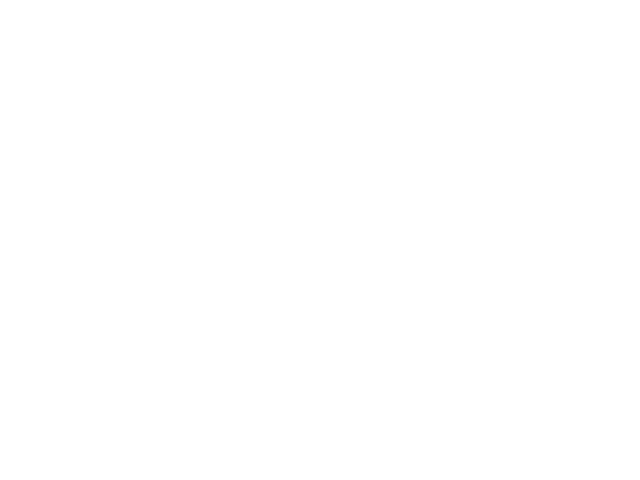

(0, 1)

In [762]:
plt.figure()
for z in range(3):
    plt.plot(top_score[k][0,z,0].mean(-1))
plt.ylim((0,1))

<IPython.core.display.Javascript object>


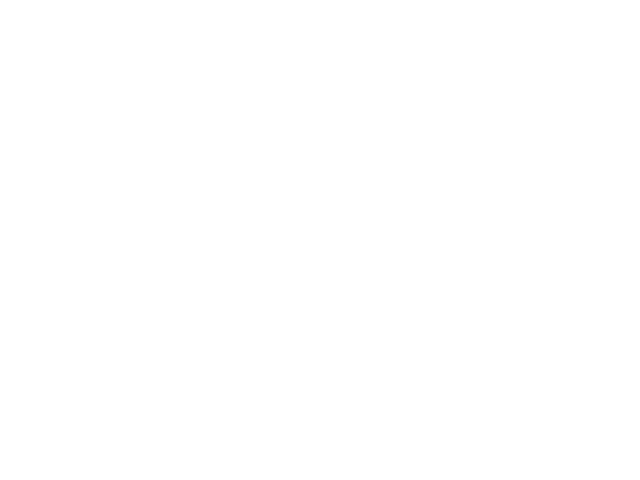

(-0.01, 0.4)

In [766]:
plt.figure()
iroll = 1
for i in range(nz):
    for j in range(i+1,nz):
        plt.scatter(top_score[k][0,i,iroll].mean(-1),top_score[k][0,j,iroll].mean(-1),s=5)
plt.xlim((-.01,0.4))
plt.ylim((-.01,0.4))

In [899]:
# Here, we plot the distribution of responses to zero-contrast vs. non-zero contrast stimuli, for all the on-target neurons in a particular mouse
k = 1
nroi = ds[keylist[k]]['decon'][()].shape[0]
nsize = 5
ncontrast = 6
nangle = 8
size = ds[keylist[k]]['stimulus_id'][()][0]
contrast = ds[keylist[k]]['stimulus_id'][()][1]
running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
angle = ds[keylist[k]]['stimulus_id'][()][-1]
pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
response = np.zeros((2,2,nroi,nsize,ncontrast,nangle))

# criterion = area>np.percentile(area,50)
# criterion = ctrx>np.percentile(ctrx,ctr_cutoff)
criteria = (ctrx>np.percentile(ctrx,ctr_cutoff),eye_mvt>np.percentile(eye_mvt[~np.isnan(eye_mvt)],50))
# criterion = eye_dist>np.percentile(eye_dist,50)
# criterion = eye_mvt>np.percentile(eye_mvt[~np.isnan(eye_mvt)],50)

for icrit in range(2):
    for z in range(2):
        for s in range(nsize):
            for c in range(ncontrast):
                for i in range(nangle):
                    stim_of_interest = k_and(angle==i,size==s,contrast==c,running_speed_cm_s>30,criteria[icrit]==z)
                    response[icrit,z,:,s,c,i] = np.nanmean(ds[keylist[k]]['decon'][()][:,stim_of_interest],1)

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


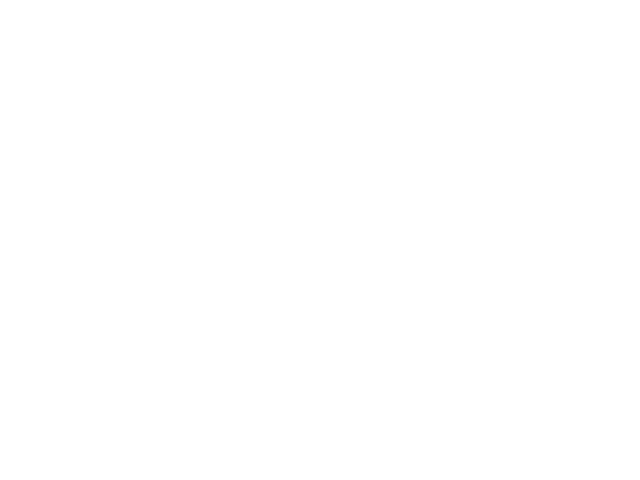

In [854]:
plt.figure()
plt.hist(ctrx,100,color='c')
ctr_cutoff = 60
plt.plot((np.percentile(ctrx,ctr_cutoff),np.percentile(ctrx,ctr_cutoff)),(0,70),c='k')
plt.ylabel('# of trials')
plt.xlabel('eye location (pix)')
plt.title('Thresholding based on eye position')
plt.savefig('eye_position_hist.pdf')

In [791]:
r2final = np.zeros((data.shape[0],))
for ind in range(data.shape[0]): #np.where(lkat)[0]:
    r2final[ind] = compute_r2_n_times(ctrx[stim_of_interest_no_contrast],data[ind][stim_of_interest_no_contrast],100)
    print((ind,r2final[ind]))

(0, -7.6003693516460771e+28)
(1, -0.466430303972734)
(2, -0.31171318891671768)
(3, -0.36673798954206738)
(4, -3.5689770201393265)
(5, -0.25492745365610475)
(6, -0.26454892411025949)
(7, -1.3656393752785512)
(8, -1.0265312000020868)
(9, -0.2311324816145188)
(10, -0.63594603060397936)
(11, -0.55566905682144518)
(12, -0.3887446790062723)
(13, -0.43325114428024714)
(14, -1.8042569393797242e+29)
(15, -1.1062235227356161)
(16, -0.086778934061420857)
(17, -0.29720235419725249)
(18, -0.11919184887082815)
(19, -0.18320986058227309)
(20, -1.4468733459684565e+30)
(21, -0.36455822397903442)
(22, -1.2654527289947235)
(23, -0.30188401561078554)
(24, -5.6626574045464166e+27)
(25, -2.5725270627346846)
(26, -0.88492765912870552)
(27, -0.35263168990102056)
(28, -0.52742687987088765)
(29, -0.16901006478049069)
(30, -0.70403944728828471)
(31, -0.20729104452892144)
(32, -0.34271782043820209)
(33, -0.21427891166318749)
(34, -0.85815225507259141)
(35, -0.28146302488657571)
(36, -0.7146371053270143)
(37, -0.0

(298, -1.4421219867664537e+28)
(299, -1.1491163875422055)
(300, -0.6914506972470652)
(301, -1.4997421313630321)
(302, -0.46917643116098789)
(303, -4.3223743229229346)
(304, -1.1315678257270969)
(305, -0.54590885298849789)
(306, -0.42363219155827869)
(307, -1.3350395659841645)
(308, -0.36798694194771031)
(309, -1.3601330657552539)
(310, -1.2706077862456364)
(311, -0.64102765913834725)
(312, -0.26751448323669197)
(313, -0.63181115038585534)
(314, -1.0442238307222975e+30)
(315, -3.6539781131949191e+28)
(316, -0.15598157680735916)
(317, -0.67179913667006408)
(318, -0.21011406536174193)
(319, -0.64874359248870828)
(320, -0.49109539564620652)
(321, -0.61341793206801931)
(322, -0.27111276287106678)
(323, -6.4083200879309707)
(324, -0.36578281235995397)
(325, -0.37371560322867803)
(326, -0.45168294672138681)
(327, -0.84627284856087992)
(328, -0.39173752590112554)
(329, -0.18532153204222526)
(330, -0.49402392493275105)
(331, -0.45022128439046627)
(332, -0.5040949470090712)
(333, -0.382031024089

(592, -0.20092829734653853)
(593, -0.98657783058959769)
(594, -0.21071390136828341)
(595, -1.4989077388065113)
(596, -0.38639103157964572)
(597, -0.22640084824175846)
(598, -0.54373316858200771)
(599, -0.88500996912343799)
(600, -1.3959920746729662e+29)
(601, -0.15097016442668243)
(602, -1.5853696893437643)
(603, -0.20544412113107566)
(604, -0.47657955352183329)
(605, -0.1725912970630061)
(606, -0.46073093915669544)
(607, -0.29531565677627131)
(608, -1.5079121654230698)
(609, -0.22170034078435857)
(610, -1.6668490337920256)
(611, -0.6410847546543893)
(612, -0.39170318386486613)
(613, -0.40785725181602911)
(614, -0.17807602608241668)
(615, -0.20966744943155308)
(616, -1.3880867359262645)
(617, -0.49977926888373458)
(618, -0.81010264052797731)
(619, -0.33529158418654637)
(620, -0.32986480398031809)
(621, -0.36717844093077756)
(622, -1.3970171312122008)
(623, -1.6304396601675248)
(624, -0.26814604404236686)
(625, -0.70624246312717287)
(626, -0.41477140382101968)
(627, -0.78489230607553906

(886, -0.11625688482493057)
(887, -0.12073825856947352)
(888, -0.40302571979759644)
(889, -0.18953067122533993)
(890, -0.1800482034177556)
(891, -0.15919973407110008)
(892, -1.4823504083906851)
(893, -3.2591287683133601)
(894, -0.18566629077310368)
(895, -0.18774844347600819)
(896, -0.21028336554084959)
(897, -0.31482228725293138)
(898, -0.11823292132877861)
(899, -0.27363318132843167)
(900, -0.97426891080592881)
(901, -0.37936138185276319)
(902, -0.50071667613084003)
(903, -0.45038385488496058)
(904, -0.35643527055084828)
(905, -0.37647182163578435)
(906, -0.38688655619462115)
(907, -0.13047165462971524)
(908, -0.40936549927924754)
(909, -0.23163861661260898)
(910, -0.19483168340560456)
(911, -0.69896636281491131)
(912, -0.43416230535233052)
(913, -0.9364360732616358)
(914, -0.20528087850280483)
(915, -0.32856457940123673)
(916, -0.16780441853134662)
(917, -0.52440017401150907)
(918, -0.70705037320790542)
(919, -0.97340294943399153)
(920, -0.73673322033544875)
(921, -1.281528696859978

(1174, -0.14534414094008685)
(1175, -0.80240562564372253)
(1176, -0.36955579817387907)
(1177, -0.25447317357654559)
(1178, -0.3194862877069794)
(1179, -0.31951169990457723)
(1180, -0.93272776168725524)
(1181, -8.4129288014174985e+29)
(1182, -0.36857595432813012)
(1183, -0.30881897708404238)
(1184, -0.52668327002375348)
(1185, -7.9129528841953851)
(1186, -0.23114555402120698)
(1187, -0.8613814933965489)
(1188, -0.45407145420945344)
(1189, -1.3706108739526903)
(1190, -0.23513055713912634)
(1191, -0.43877861540684515)
(1192, -2.5174272959217823)
(1193, -0.28316477344432023)
(1194, -0.11260510474003088)
(1195, -2.0319978348952965e+31)
(1196, -0.29606371171291002)
(1197, -3.1266861113310427e+29)
(1198, -1.0005345418425562)
(1199, -0.19324366101034796)
(1200, -0.59072723109673586)
(1201, -2.2171300733490535)
(1202, -1.1190185723130719)
(1203, -1.3865414546124877)
(1204, -0.036127564517476771)
(1205, -0.75107282035728806)
(1206, -0.078331264803273043)
(1207, -6.8027340574139676e+29)
(1208, -0

In [809]:
r2final_mvt = np.zeros((data.shape[0],))
for ind in range(data.shape[0]): #np.where(lkat)[0]:
    r2final_mvt[ind] = compute_r2_median(eye_mvt[stim_of_interest_no_contrast],data[ind][stim_of_interest_no_contrast],100)
    print((ind,r2final_mvt[ind]))

(0, -0.051245232513327299)
(1, -0.059349088533665606)
(2, -0.060681709318955501)
(3, -0.051006405837985713)
(4, -0.063051758050297335)
(5, -0.054347592782709953)
(6, -0.057202839214035961)
(7, -0.07141670859457111)
(8, -0.051031868854290063)
(9, -0.075765885439010139)
(10, -0.05919168578822015)
(11, -0.051659960356466028)
(12, -0.052997233154795376)
(13, -0.023969410565880145)
(14, -0.044262780543211866)
(15, -0.076234674754743381)
(16, -0.011243589578811775)
(17, -0.044647369910842255)
(18, -0.061360021926304187)
(19, -0.041572141345460029)
(20, -0.066433730488458298)
(21, -0.049785484375692801)
(22, -0.061873815712903735)
(23, -0.083021574605647686)
(24, 0.0)
(25, -0.089523363070306172)
(26, -0.14729947884857331)
(27, -0.050841123992018455)
(28, -0.052997283338132029)
(29, -0.010028617156293381)
(30, -0.049056155206077812)
(31, -0.030113327510078503)
(32, -0.049589735740420748)
(33, -0.030089472138204121)
(34, -0.051857963352262837)
(35, -0.052441526807133099)
(36, -0.056267356354062

(290, -0.054887830141644167)
(291, -0.044797652229670415)
(292, -0.050044172686184552)
(293, -0.054209951149871483)
(294, -0.048753188278849779)
(295, -0.059442374710606427)
(296, -0.051858285136946292)
(297, -0.038795056912791503)
(298, -0.06697003502152088)
(299, -0.16940925101553489)
(300, 0.026035220917223018)
(301, -0.070178755028253825)
(302, -0.076173835160386505)
(303, -0.047337235710433301)
(304, -0.080801467743418731)
(305, -0.0394011122723264)
(306, -0.041106373634747229)
(307, -0.0726617744379916)
(308, -0.053207834444748359)
(309, -0.17776584224517511)
(310, -0.058018857500244769)
(311, -0.042628335388215144)
(312, -0.029333749637080853)
(313, -0.077164394713155393)
(314, -0.039566107573158871)
(315, -0.054273750138485455)
(316, -0.051166808746407)
(317, -0.058895266000447699)
(318, -0.036559182873174723)
(319, -0.14279880350561208)
(320, -0.023233773276531783)
(321, -0.051236201556339178)
(322, -0.071443970668326695)
(323, -0.081244251098469333)
(324, -0.06678713165221916

(575, -0.058808000905735347)
(576, -0.04745164496543286)
(577, -0.048423094663687105)
(578, -0.038398432101353991)
(579, -0.052647574076410408)
(580, 0.015088209625073346)
(581, -0.064900646360876002)
(582, -0.060861325640098274)
(583, -0.047942016204666149)
(584, -0.093940314453625107)
(585, -0.024365620499808671)
(586, -0.035404977792970471)
(587, -0.065859928810789059)
(588, -0.050619240219330119)
(589, -0.068726522163946591)
(590, -0.037043567633962105)
(591, -0.012457942295452329)
(592, -0.032487309327097647)
(593, -0.058659067634886208)
(594, -0.046246811234368246)
(595, -0.061807622904532789)
(596, -0.050683051591132677)
(597, -0.056403911220379466)
(598, -0.051151050765532058)
(599, -0.05550689382586077)
(600, -0.052594730589123895)
(601, -0.030232814638797345)
(602, -0.092373114601313533)
(603, -0.049079571402048272)
(604, -0.053887170177071397)
(605, -0.050288094196850319)
(606, -0.085609229476109105)
(607, -0.0090787092031826278)
(608, -0.088878349524315947)
(609, -0.0605683

(860, -0.050769794440601812)
(861, -0.03209495370324178)
(862, -0.090789773986165667)
(863, -0.076450746617721055)
(864, -0.04042311804471671)
(865, -0.064181968634056785)
(866, -0.029849014377020505)
(867, -0.05822442577519249)
(868, -0.051698326773175041)
(869, -0.046877961555905678)
(870, -0.024296206176426194)
(871, -0.050485294561604666)
(872, -0.014663993310236045)
(873, -0.053439860992886223)
(874, -0.056340977571392059)
(875, -0.066759279280521722)
(876, -0.027603579256307409)
(877, -0.067167126360423934)
(878, -0.020499186823573601)
(879, 1.0)
(880, -0.053450764243386073)
(881, -0.054652412263676675)
(882, -0.062142496194526775)
(883, -0.056967625523839938)
(884, 0.0080503240833448564)
(885, -0.097649109185593552)
(886, -0.055095997931110641)
(887, -0.063145994603315436)
(888, -0.053320545207242553)
(889, -0.045491770830004052)
(890, -0.067574546375547606)
(891, -0.046001880761335934)
(892, -0.066819437272809701)
(893, -0.062416810419141155)
(894, -0.054303231738657254)
(895, 

(1140, -0.057555412541466011)
(1141, -0.056390099324832077)
(1142, -0.11489249959725911)
(1143, -0.0095265289154474186)
(1144, 0.015014344978298316)
(1145, -0.04586059369472284)
(1146, -0.062725516138974979)
(1147, -0.32239496600427403)
(1148, -0.059608216473938547)
(1149, -0.067107880677206799)
(1150, -0.046494243920674971)
(1151, -0.05375537964842575)
(1152, 0.0)
(1153, -0.054451591409999112)
(1154, -0.05066833199886811)
(1155, -0.10062123466560635)
(1156, -0.046175774932124991)
(1157, -0.049244131516119338)
(1158, -0.066079096971265183)
(1159, -0.054375908954356178)
(1160, -0.080251983402696847)
(1161, -0.037795644548579865)
(1162, -0.15655350692842918)
(1163, -0.17720554187743198)
(1164, -0.052879976540861851)
(1165, -0.049336751665262413)
(1166, -0.04248085800914142)
(1167, -0.04346658203186643)
(1168, -0.054943306773284684)
(1169, -0.076252674060529824)
(1170, -0.059458816666583703)
(1171, -0.043896098243272119)
(1172, -0.044616730695667184)
(1173, -0.055847702788636933)
(1174, -

In [813]:
# lkat = np.logical_and(r2final > 0,r2final < 1) #np.logical_and(top_score[k][0,1,1].mean(-1)>0.1,top_score[k][0,1,1].mean(-1)<1)
# for ind in np.where(lkat)[0]:
#     ut.imshow_in_pairs(np.nanmean(response[0,ind:ind+1],-1),np.nanmean(response[1,ind:ind+1],-1))

<IPython.core.display.Javascript object>


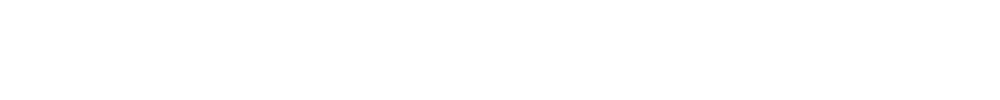

<IPython.core.display.Javascript object>


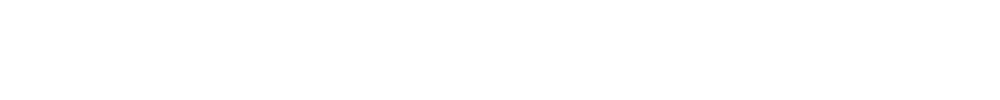

148

In [909]:
lkat = np.logical_and(r2final_mvt > 0.03,r2final_mvt < 1) #top_score[k][0,2,0].mean(-1)>0.05
ut.imshow_in_pairs(np.nanmean(response[0,0,lkat],-1),np.nanmean(response[0,1,lkat],-1))
ut.imshow_in_pairs(np.nanmean(response[1,0,lkat],-1),np.nanmean(response[1,1,lkat],-1))
np.where(lkat)[0][2]

<IPython.core.display.Javascript object>


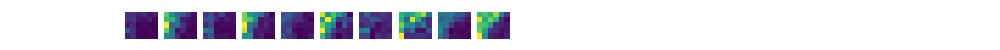

<IPython.core.display.Javascript object>


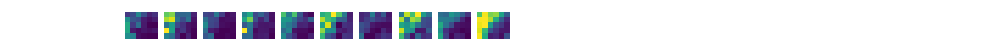

In [902]:
lkat = np.logical_and(r2final > 0.03,r2final < 1) #top_score[k][0,2,0].mean(-1)>0.05
ut.imshow_in_pairs(np.nanmean(response[0,0,lkat],-1),np.nanmean(response[0,1,lkat],-1))
ut.imshow_in_pairs(np.nanmean(response[1,0,lkat],-1),np.nanmean(response[1,1,lkat],-1))

In [903]:
(np.where(lkat)[0][2],np.where(lkat)[0][4])

(586, 964)

<IPython.core.display.Javascript object>


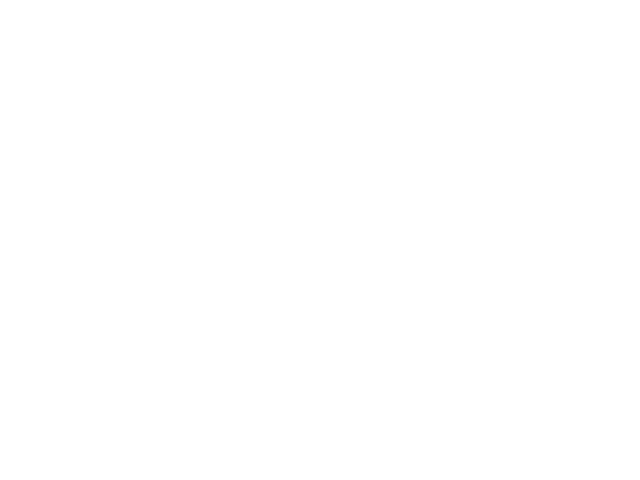

<IPython.core.display.Javascript object>


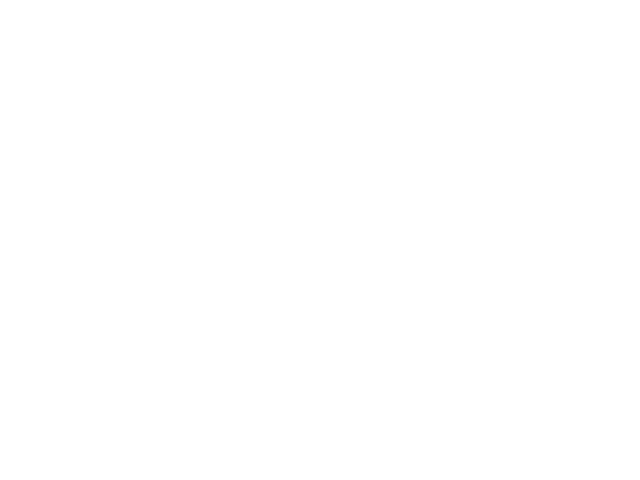

<IPython.core.display.Javascript object>


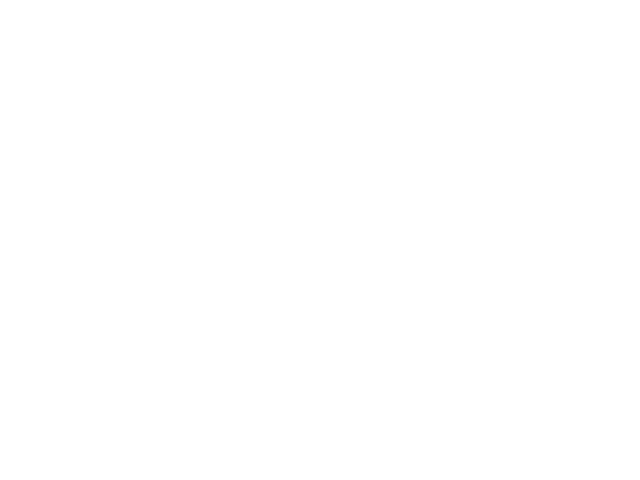

In [910]:
z = 0

usize = (5,8,13,22,36)
ucontrast = (0,6,12,25,50,100)
def show_size_contrast(arr,vmin=None,vmax=None):
    plt.imshow(arr,vmin=vmin,vmax=vmax)
    plt.ylabel('size (deg)')
    plt.xlabel('contrast (%)')
    plt.xticks(np.arange(arr.shape[1]),ucontrast)
    plt.yticks(np.arange(arr.shape[0]),usize)

def show_comparison(ind):
    to_show = np.nanmean(response[z,:,ind],-1)
    plt.subplot(1,2,1)
    plt.title('Eye nasal')
    show_size_contrast(to_show[0],vmin=0,vmax=to_show.max())
    plt.subplot(1,2,2)
    plt.title('Eye temporal')
    show_size_contrast(to_show[1],vmin=0,vmax=to_show.max())
    plt.tight_layout()
    
ind = 964 #np.where(lkat)[0][29] # 14
plt.figure()
show_comparison(ind)
plt.savefig('example_roi_temporal_facilitated_1.pdf')

ind = 586
plt.figure()
show_comparison(ind)
plt.savefig('example_roi_temporal_facilitated_2.pdf')

ind = 148
plt.figure()
show_comparison(ind)
plt.savefig('example_roi_temporal_facilitated_3.pdf')

<IPython.core.display.Javascript object>


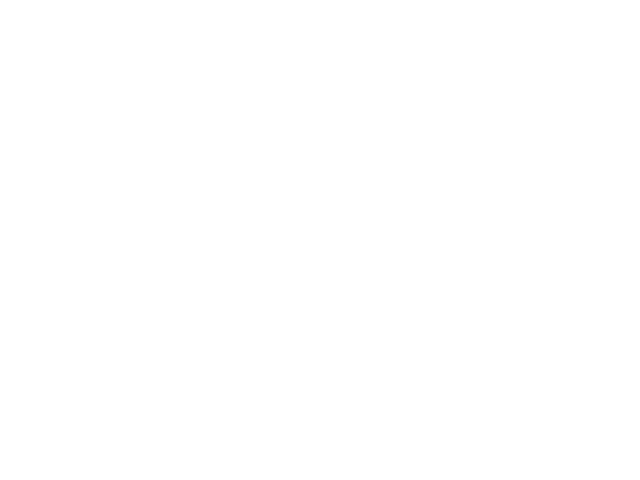

<IPython.core.display.Javascript object>


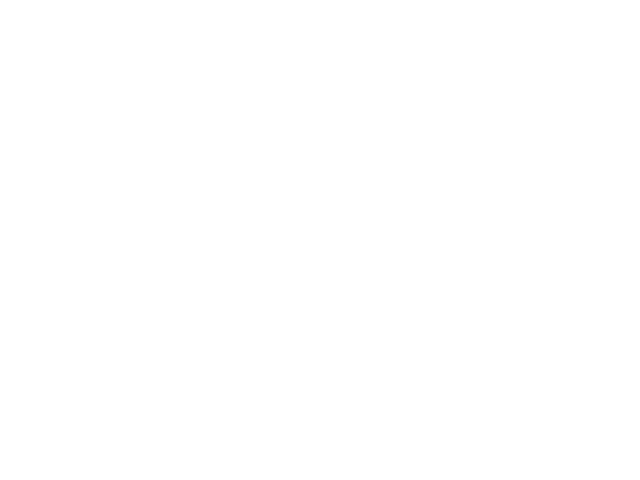

<IPython.core.display.Javascript object>


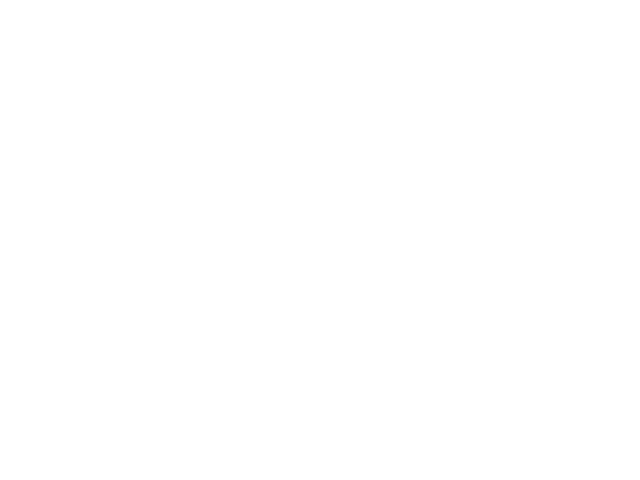

In [911]:
z = 1

usize = (5,8,13,22,36)
ucontrast = (0,6,12,25,50,100)
def show_size_contrast(arr,vmin=None,vmax=None):
    plt.imshow(arr,vmin=vmin,vmax=vmax)
    plt.ylabel('size (deg)')
    plt.xlabel('contrast (%)')
    plt.xticks(np.arange(arr.shape[1]),ucontrast)
    plt.yticks(np.arange(arr.shape[0]),usize)

def show_comparison(ind):
    to_show = np.nanmean(response[z,:,ind],-1)
    plt.subplot(1,2,1)
    plt.title('Eye stationary')
    show_size_contrast(to_show[0],vmin=0,vmax=to_show.max())
    plt.subplot(1,2,2)
    plt.title('Eye moving')
    show_size_contrast(to_show[1],vmin=0,vmax=to_show.max())
    plt.tight_layout()

    
ind = 964 #np.where(lkat)[0][29] # 14
plt.figure()
show_comparison(ind)
plt.savefig('example_roi_mvt_facilitated_1.pdf')

ind = 586
plt.figure()
show_comparison(ind)
plt.savefig('example_roi_mvt_facilitated_2.pdf')

ind = 148
plt.figure()
show_comparison(ind)
plt.savefig('example_roi_mvt_facilitated_3.pdf')

<IPython.core.display.Javascript object>


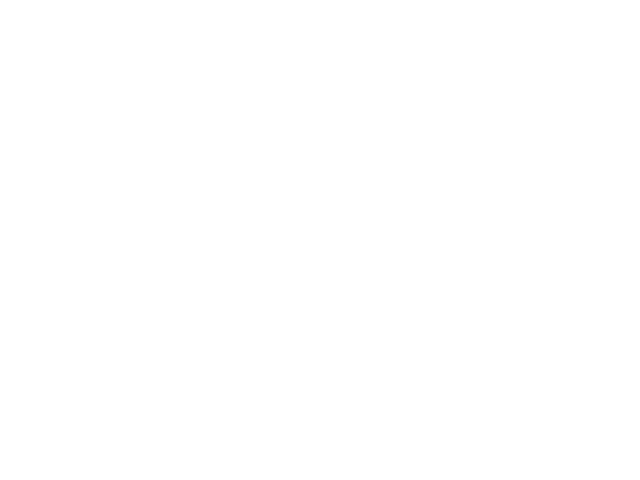

<IPython.core.display.Javascript object>


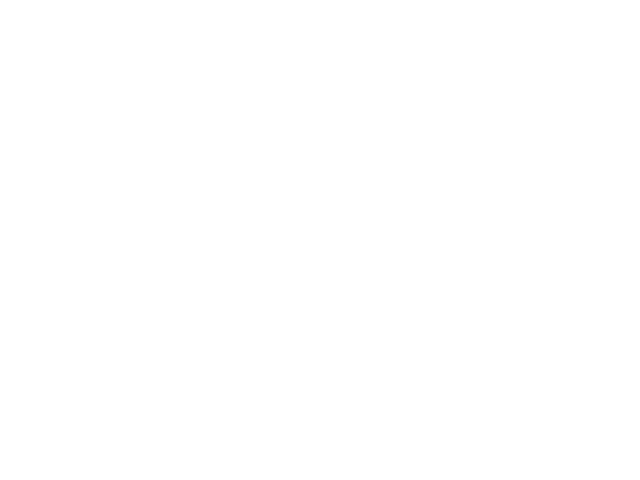

In [885]:
plt.figure()
these_trials = np.where(eye_mvt<np.percentile(eye_mvt[~np.isnan(eye_mvt)],50))[0]
plt.plot(ctrx_trialwise[these_trials[:10],::2].T) #,alpha=0.05,c='c')
plt.figure()
these_trials = np.where(eye_mvt>np.percentile(eye_mvt[~np.isnan(eye_mvt)],50))[0]
plt.plot(ctrx_trialwise[these_trials[:10],::2].T) #,alpha=0.05,c='c')

In [869]:
ind

964

<IPython.core.display.Javascript object>


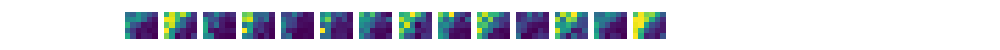

In [820]:
lkat = np.logical_and(r2final > 0.01,r2final < 1) #top_score[k][0,2,0].mean(-1)>0.05
ut.imshow_in_pairs(np.nanmean(response[0,lkat],-1),np.nanmean(response[1,lkat],-1))

In [653]:
def compute_r2_n_times(x,y,n):
    r2 = 0
    for i in range(n):
        r2 = r2 + compute_r2(x,y).mean()/n
    return r2

In [801]:
def compute_r2_median(x,y,n):
    r2 = np.zeros((n,))
    for i in range(n):
        r2[i] = np.median(compute_r2(x,y))
    return np.median(r2)

In [803]:
# compute_r2(running_speed_cm_s[running_speed_cm_s>30],eye_mvt[running_speed_cm_s>30]).mean()
# compute_r2_n_times(running_speed_cm_s[stim_of_interest_no_contrast],eye_mvt[stim_of_interest_no_contrast],10)
compute_r2_median(running_speed_cm_s[running_speed_cm_s>30],eye_mvt[running_speed_cm_s>30],100)

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


0.059409146614697206

In [805]:
compute_r2_median(running_speed_cm_s[running_speed_cm_s>30],ctrx[running_speed_cm_s>30],100)

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.00043847005762762126

In [806]:
compute_r2_median(running_speed_cm_s,ctrx,100)

0.093184904694622539

In [807]:
compute_r2_median(running_speed_cm_s,eye_mvt,100)

0.18293083666406981

In [649]:
np.logical_and(stim_of_interest_no_contrast,~(running_speed_cm_s>30)).sum()

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0

<IPython.core.display.Javascript object>


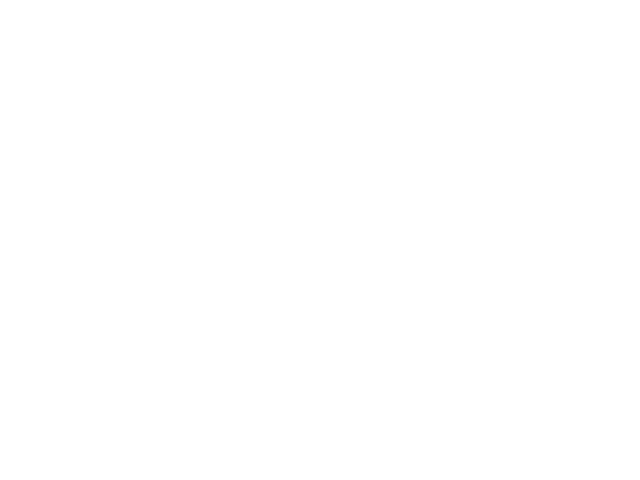

<IPython.core.display.Javascript object>


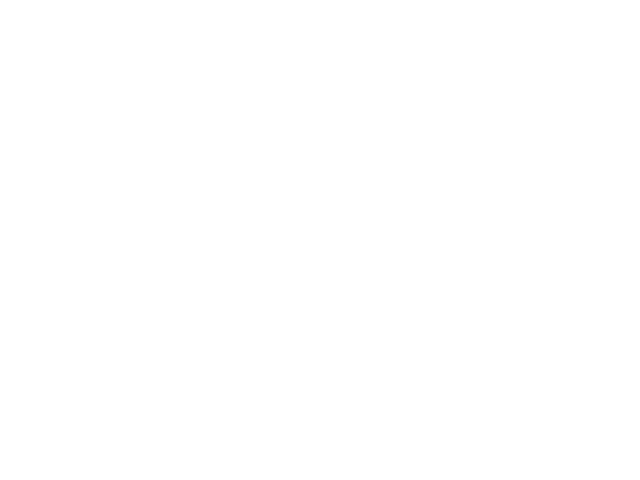

In [912]:
plt.figure()
plt.scatter(running_speed_cm_s,eye_mvt,s=5,c='g',label='$R^2$ = 0.17')
plt.xlabel('run speed (cm/s)')
plt.ylabel('abs. eye movement during trial (pix)')
plt.fill((30,30,80,80),(-0.1,8.1,8.1,-0.1),alpha=0.1,c='k',label='$R^2$ = 0.05')
plt.legend()
plt.savefig('speed_vs_eye_mvt.pdf')

plt.figure()
plt.scatter(running_speed_cm_s,ctrx,s=5,c='c',label='$R^2$ = 0.09')
plt.xlabel('run speed (cm/s)')
plt.ylabel('pupil x location (pix)')
plt.fill((30,30,80,80),(307.9,314.1,314.1,307.9),alpha=0.1,c='k',label='$R^2$ = 0.00')
plt.legend()
plt.savefig('speed_vs_eye_pos.pdf')

In [915]:
ds[keylist[1]].keys()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [918]:
ds[keylist[1]][()].dtype

dtype([('mouse_id', 'O'), ('stimulus_id', 'O'), ('stimulus_size_deg', 'O'), ('stimulus_contrast', 'O'), ('stimulus_direction', 'O'), ('cell_id', 'O'), ('cell_type', 'O'), ('calcium_responses_au', 'O'), ('decon', 'O'), ('rf_mapping_pval', 'O'), ('rf_distance_deg', 'O'), ('rf_ctr', 'O'), ('running_speed_cm_s', 'O'), ('ctr', 'O')])

In [920]:
dsf = sio.loadmat('/home/mossing/Documents/notebooks/size_contrast/pyr_l23_data_struct_full.mat',squeeze_me=True) #,struct_as_record=True)

In [930]:
plt.close('all')

In [955]:
dsf[keylist[1]]['decon'][()][ind].shape

(1400, 24)

In [961]:
zsc[stim_of_interest_no_contrast].shape

(166, 23)

In [973]:
nclusters = 8
km = sklearn.cluster.KMeans(n_clusters=nclusters).fit(zsc[stim_of_interest_no_contrast])

<IPython.core.display.Javascript object>


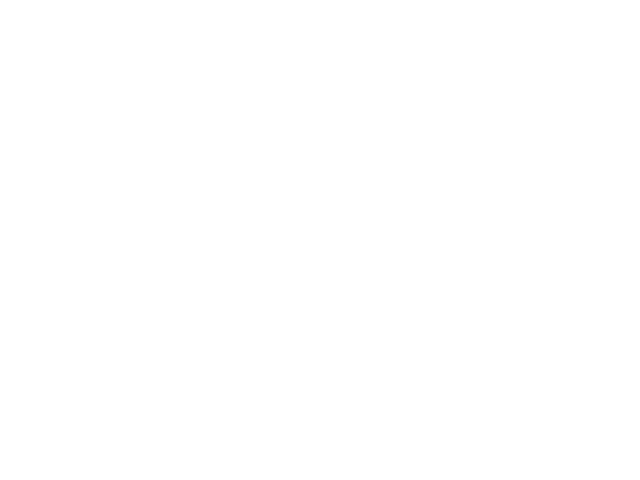

In [989]:
plt.figure()
for ll in range(nclusters):
    plt.subplot(2,4,ll+1)
    plt.plot(zsc[stim_of_interest_no_contrast][km.labels_==ll].T)
    plt.ylim((-5,5))

<IPython.core.display.Javascript object>


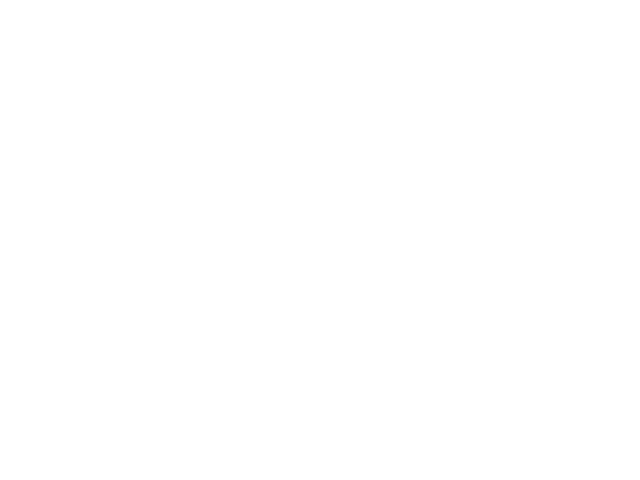

In [994]:
plt.figure()
plt.plot(zsf[trials].T,alpha=0.1,c='k')
plt.plot(zsf[trials].mean(0),alpha=1,c='k')
plt.plot(zsc[trials].T,alpha=0.1,c='c')
plt.plot(zsc[trials].mean(0),alpha=1,c='c')

<IPython.core.display.Javascript object>


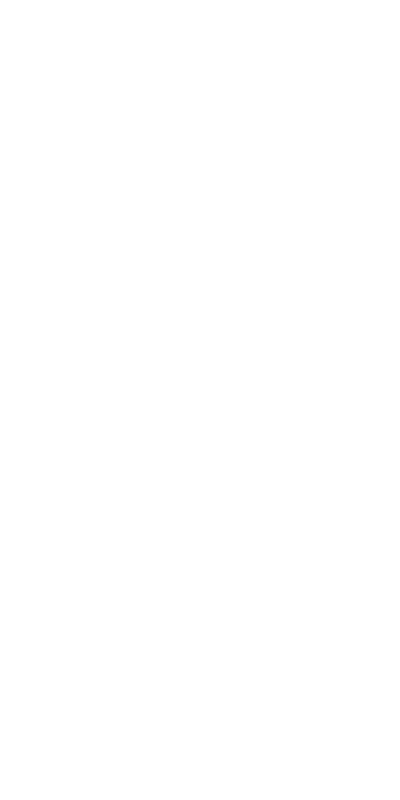

In [1012]:
ind = 964
plt.figure(figsize=(4,8))
trials = np.where(stim_of_interest_no_contrast)[0] #[km.labels_==2] # 6 # 4
t = 0
zsf = sst.zscore(dsf[keylist[1]]['decon'][()][ind],axis=None)
temp = ctrx_trialwise.copy()[:,::2]
temp[np.isnan(temp)] = np.nanmean(temp)
zsc = sst.zscore(temp,axis=None)
for t in range(len(trials)):
    plt.subplot(20,10,t+1)
    plt.plot(zsf[trials[t]])
    plt.plot(zsc[trials[t]])
    plt.plot(np.zeros_like(zsf[trials[t]]),c='k',alpha=0.2)
    plt.axis('off')
    plt.ylim((-3,5))

In [1039]:
x = zsc[trials].copy()
dx = np.diff(x,1)
x = x[:,1:]
y = zsf[trials,2:].copy()

In [1040]:
for r in np.arange(-10,11):
    X = np.roll(x,(0,r))
    DX = np.roll(dx,(0,r))
    Y = np.roll(y,(0,r))
    print(compute_r2(np.concatenate((X.flatten()[:,np.newaxis],DX.flatten()[:,np.newaxis]),axis=1),Y.flatten()).mean())

0.0197006367253
0.0222340380994
0.0111386231336
0.00848990342262
0.0210933860667
0.0166508508838
0.0219813669112
0.0168448034441
0.0127089796021
0.021121507538
0.0262261167742
0.0140354633763
0.00868967411599
0.0104737897327
0.0105166698541
0.0124878484742
0.0159346490522
0.0159527676254
0.0210858777947
0.0178366184215
0.0095322724385


<IPython.core.display.Javascript object>


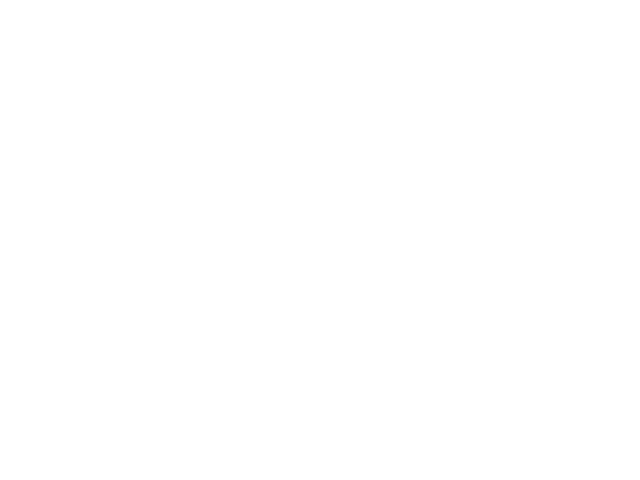

In [1020]:
plt.figure()
plt.scatter(x.flatten(),y.flatten(),s=5)
plt.scatter(dx.flatten(),y.flatten(),s=5)

<IPython.core.display.Javascript object>


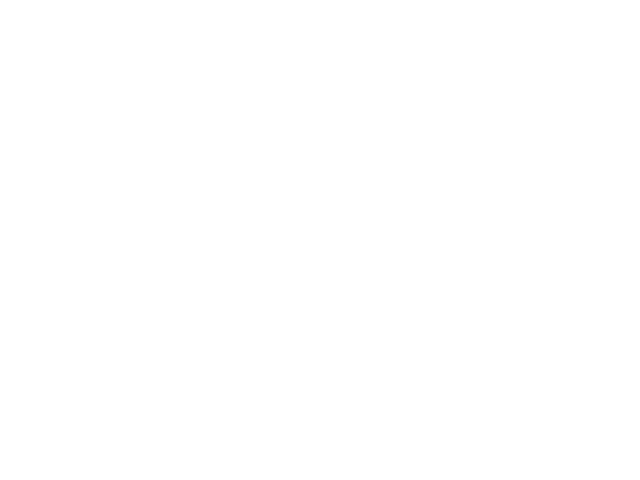

In [948]:
ind = 586
plt.figure()
trials = np.where(stim_of_interest_no_contrast)[0]
t = 0
zsf = sst.zscore(dsf[keylist[1]]['F'][()][ind])
temp = ctrx_trialwise.copy()[:,::2]
temp[np.isnan(temp)] = np.nanmean(temp)
zsc = sst.zscore(temp)
for t in range(64):
    plt.subplot(8,8,t+1)
    plt.plot(zsf[trials[t]])
    plt.plot(zsc[trials[t]])
    plt.plot(np.zeros_like(zsf[trials[t]]),c='k',alpha=0.2)
    plt.axis('off')
    plt.ylim((-5,5))

<IPython.core.display.Javascript object>


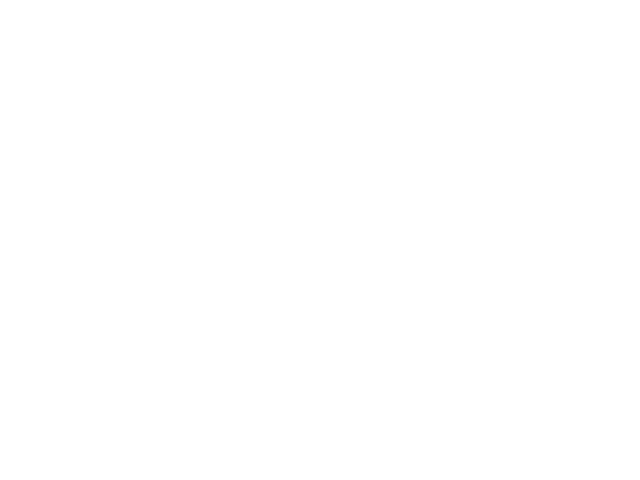

In [951]:
ind = 148
plt.figure()
trials = np.where(stim_of_interest_no_contrast)[0]
t = 0
zsf = sst.zscore(dsf[keylist[1]]['F'][()][ind])
temp = ctrx_trialwise.copy()[:,::2]
temp[np.isnan(temp)] = np.nanmean(temp)
zsc = sst.zscore(temp)
for t in range(64):
    plt.subplot(8,8,t+1)
    plt.plot(zsf[trials[t]])
    plt.plot(zsc[trials[t]])
    plt.plot(np.zeros_like(zsf[trials[t]]),c='k',alpha=0.2)
    plt.axis('off')
    plt.ylim((-5,5))